# DUSP1 & GR Confirmation and Visualization Notebook

This notebook integrates DUSP1 smiFISH and GR ICC data using modular classes for data loading, SNR-based classification, measurement extraction, filtering, visualization, and normalization. It performs:

- **DUSP1 spot and cluster detection**, quality filtering, and measurement.
- **GR quantification and gating** from ICC images.
- **Visualization and inspection** of background-corrected measurements.
- **Per-condition normalization** using background-dependent scaling.

---

### **Input**
- Big-FISH CSV files (`spots`, `clusters`)
- CellProperties CSV files (`cell_props`, `cell_results`)
- GR ICC cell properties from `GR_Confirmation`

---

### **Workflow Overview**

1. **Load Experimental Data**
   - Use `DUSP1AnalysisManager` or `AnalysisManager` to identify and load HDF5 or CSV datasets.

2. **Classify Spots by Signal Quality (SNR Analysis)**
   - Use `SNRAnalysis` to apply MG, absolute, weighted, or combined SNR methods to label high-confidence spots.

3. **Extract and Quantify Cell-level Measurements**
   - Use `DUSP1Measurement` and `measure_GR()` to obtain nuclear and cytoplasmic counts and intensities.

4. **Apply Filtering Criteria**
   - Use `DUSP1_filtering` to prune poor-quality spots, clusters, and cells.

5. **Save Results**
   - Export `FinalSpots`, `FinalClusters`, `FinalCellProps`, and `SSITcellresults` for downstream use.

6. **Visualization and Correlation Inspection**
   - Use `DUSP1DisplayManager` and seaborn/matplotlib plots to inspect image overlays, distributions, and background-intensity relationships.
   - Use `GRConfirmation` to validate GR ICC metrics and visualize intensity distributions.

7. **GR-ICC Per-condition Normalization**
   - Fit linear models between background and intensity per (Dex, Time) condition.
   - Apply reference-background normalization to obtain scaled nuclear and cytoplasmic intensities.

---

### **Core Classes**

- **`DUSP1AnalysisManager`** – Loads HDF5 or CSV datasets and handles indexing by analysis name.
- **`SNRAnalysis`** – Performs SNR-based classification of smiFISH spots.
- **`DUSP1Measurement`** – Aggregates spot and cluster metrics to the cell level.
- **`DUSP1_filtering`** – Applies thresholds to prune poor-quality data.
- **`DUSP1DisplayManager`** – Visualizes images, segmentation overlays, and crops.
- **`PostProcessingPlotter`** – Creates line, ridge, and bar plots summarizing smFISH results.
- **`GR_Confirmation`** – Loads, validates, and extracts ICC GR intensity metrics.
- **`GR_DisplayBasic`** – Basic visualization utilities for GR ICC overlays and inspection.

---

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime
from time import sleep

# Today's date
today = datetime.date.today()
# Format date as 'Jun03' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1_filtering, DUSP1DisplayManager, PostProcessingPlotter, DUSP1DisplayManager, PostProcessingPlotterDUSP1
from src.Analysis_GR import AnalysisManager, GR_Confirmation, GR_DisplayBasic

/Users/ericron/Desktop/AngelFISH


**`DUSP1AnalysisManager`** 
   - Manages HDF5 file access.
   - Extracts file paths from a log directory (if no direct locations are provided).
   - Provides methods to select an analysis (by name) and load datasets from HDF5 files.
   - Saves datasets as CSV.

In [2]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'
save_dir = r'/Volumes/share/Users/Eric/GR_DUSP1_AllData/FinalAnalysis_GR_DUSP1_Sep04'
img_dir = r'/Volumes/share/Users/Eric/GR_DUSP1_AllData/FinalAnalysis_GR_DUSP1_Sep04/Images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Define filtering method and thresholds
method = 'mg_abs'            # options: 'mg', 'absolute', 'mg_abs', 'weighted', 'rf', 'none'
mac = True

In [ ]:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True) 
am.list_analysis_names()

**`Combine Analyses function`**

In [3]:
def make_combined_manager(loc, log_location, mac, analysis_names):
    """
    Build a single DUSP1AnalysisManager that “knows about” all of the N analyses.
    
    Parameters:
      - loc, log_location, mac: passed straight through to each temp manager
      - analysis_names: list of the analysis_name strings for each analysis
    Returns:
      - a DUSP1AnalysisManager whose .location and .analysis_names
        cover every file + analysis in analysis_names
    """
    all_paths = []
    all_anames = []

    for name in analysis_names:
        temp = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=mac)
        try:
            temp.select_analysis(name)
            # grab its now-filtered list of files + names
            all_paths   .extend(temp.location)
            all_anames  .extend(temp.analysis_names)
        finally:
            temp.close()    # <— guarantee no HDF5 leak
    # now build the combined
    combo = DUSP1AnalysisManager(location=all_paths, mac=mac)
    # manually inject the unioned analysis names
    combo.analysis_names = all_anames
    return combo

**`DUSP1 Replica D 3hr 100nM time-sweep R1 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224.h5 -> Analysis_DUSP1_D_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224.h5 -> Analysis_DUSP1_D_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224.h5 -> Analysis_DUSP1_D_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_

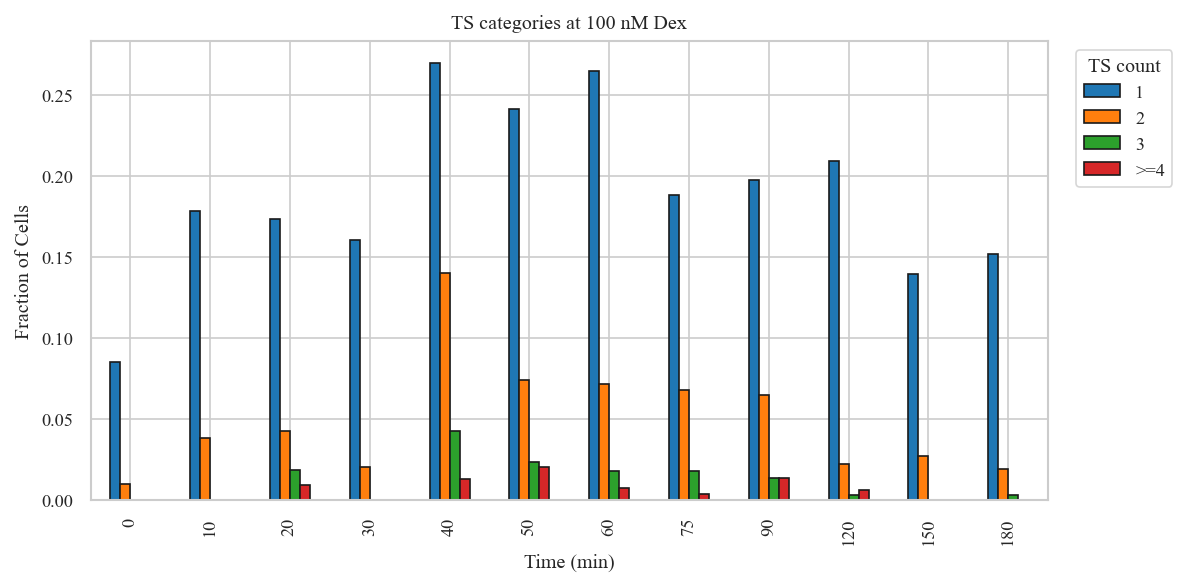

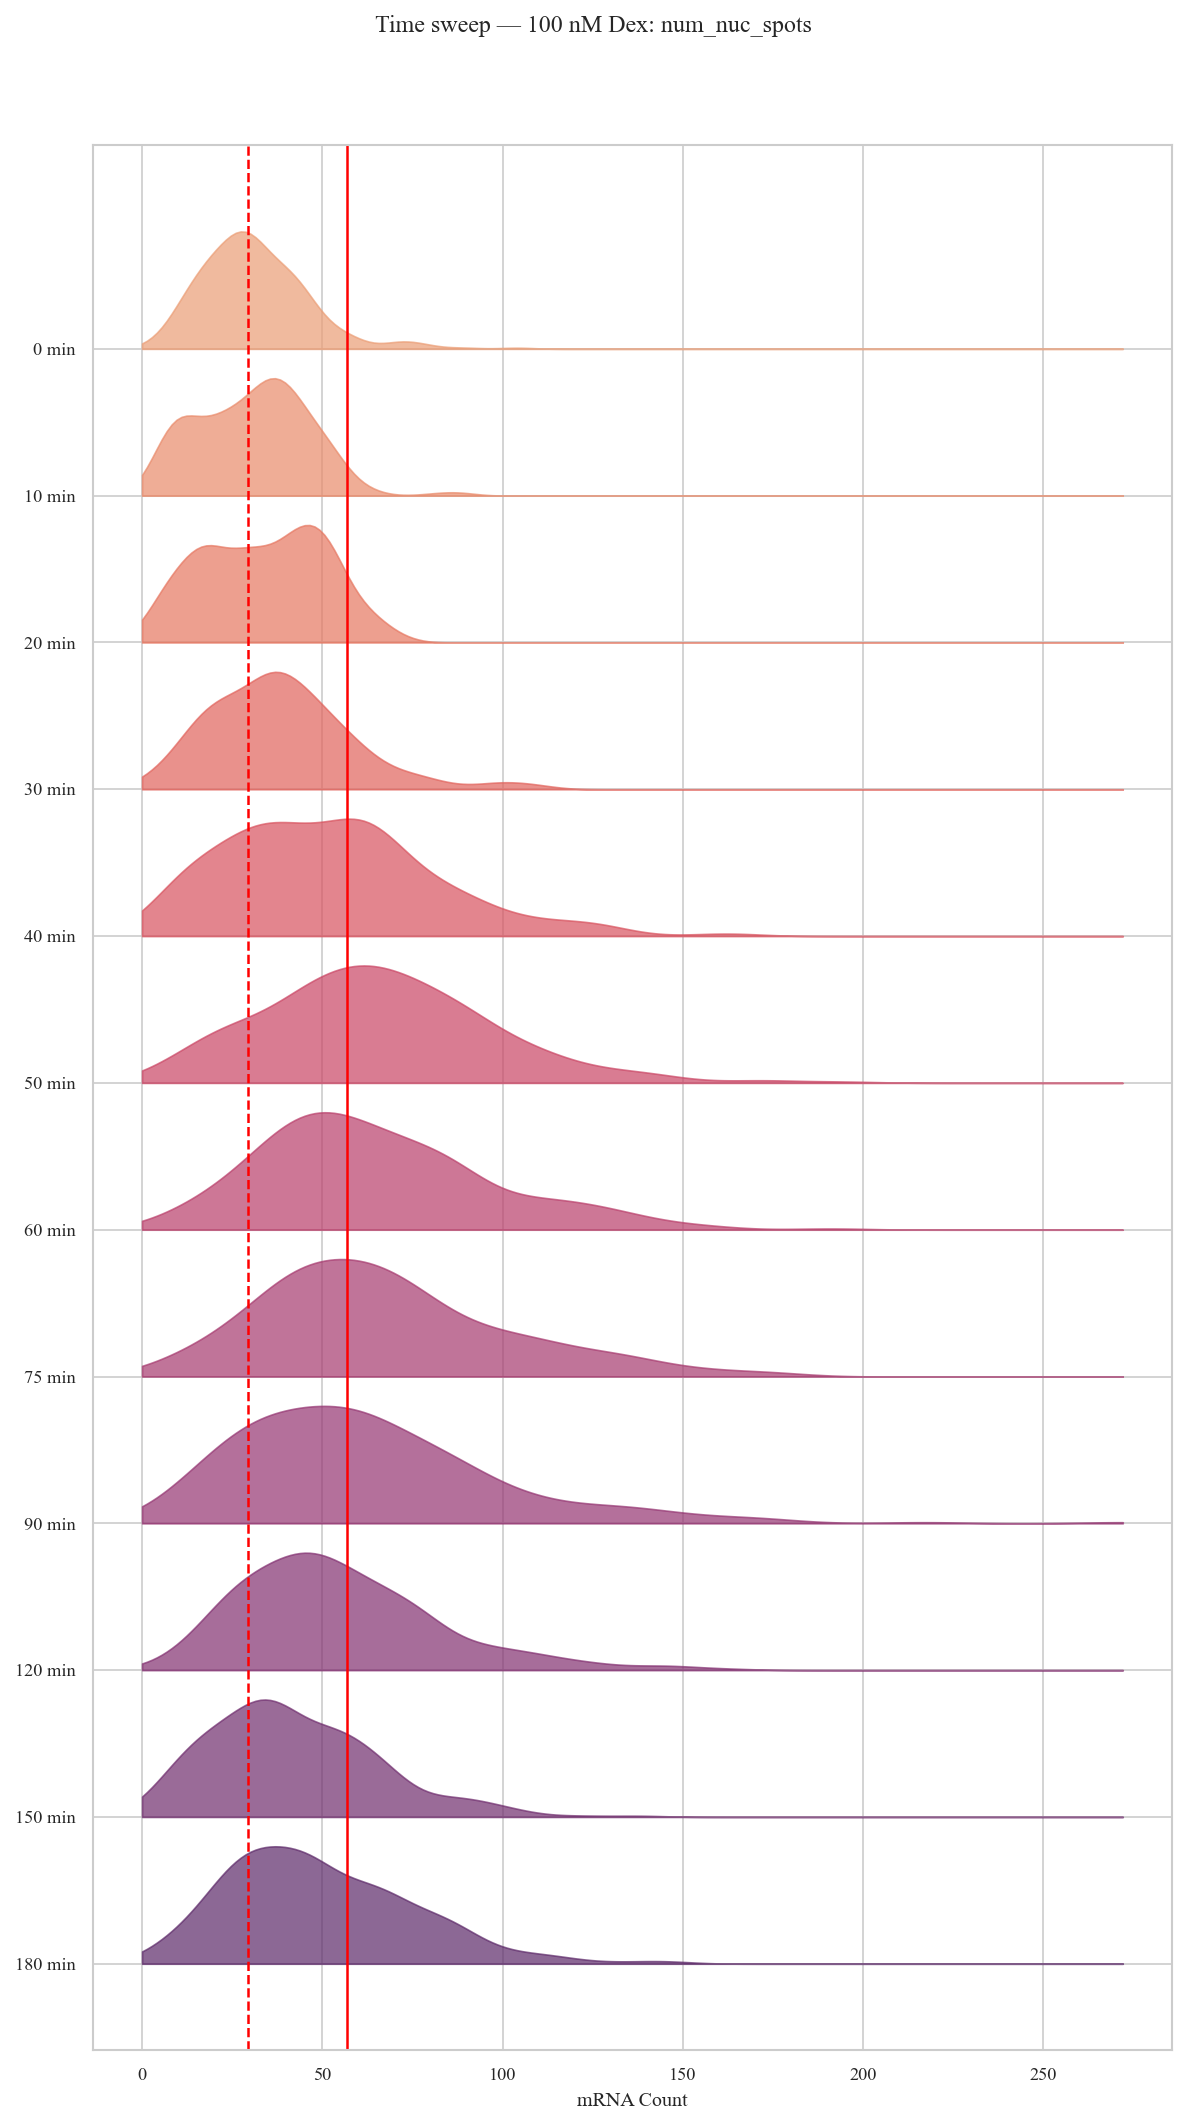

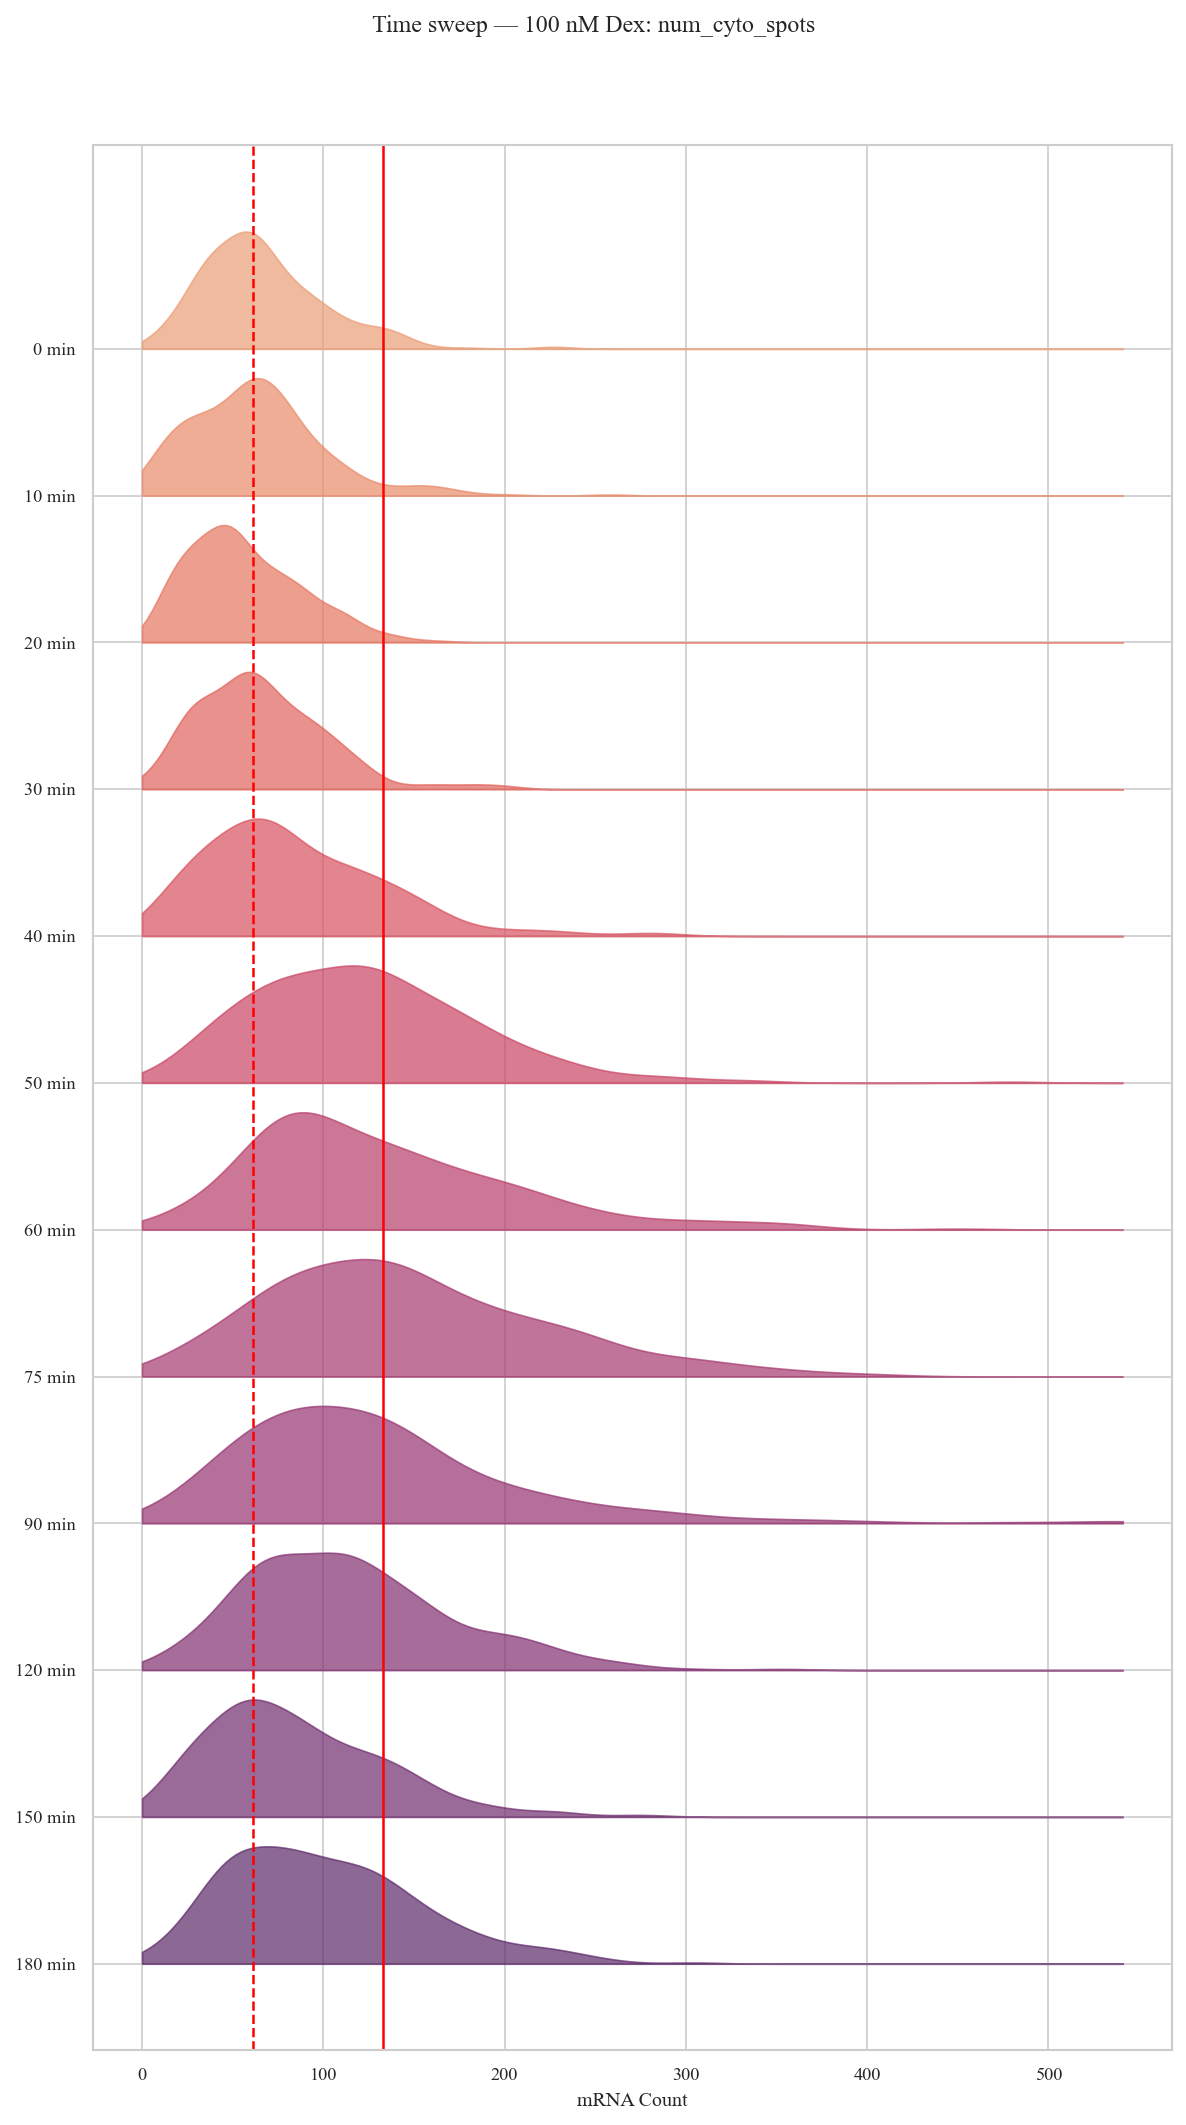

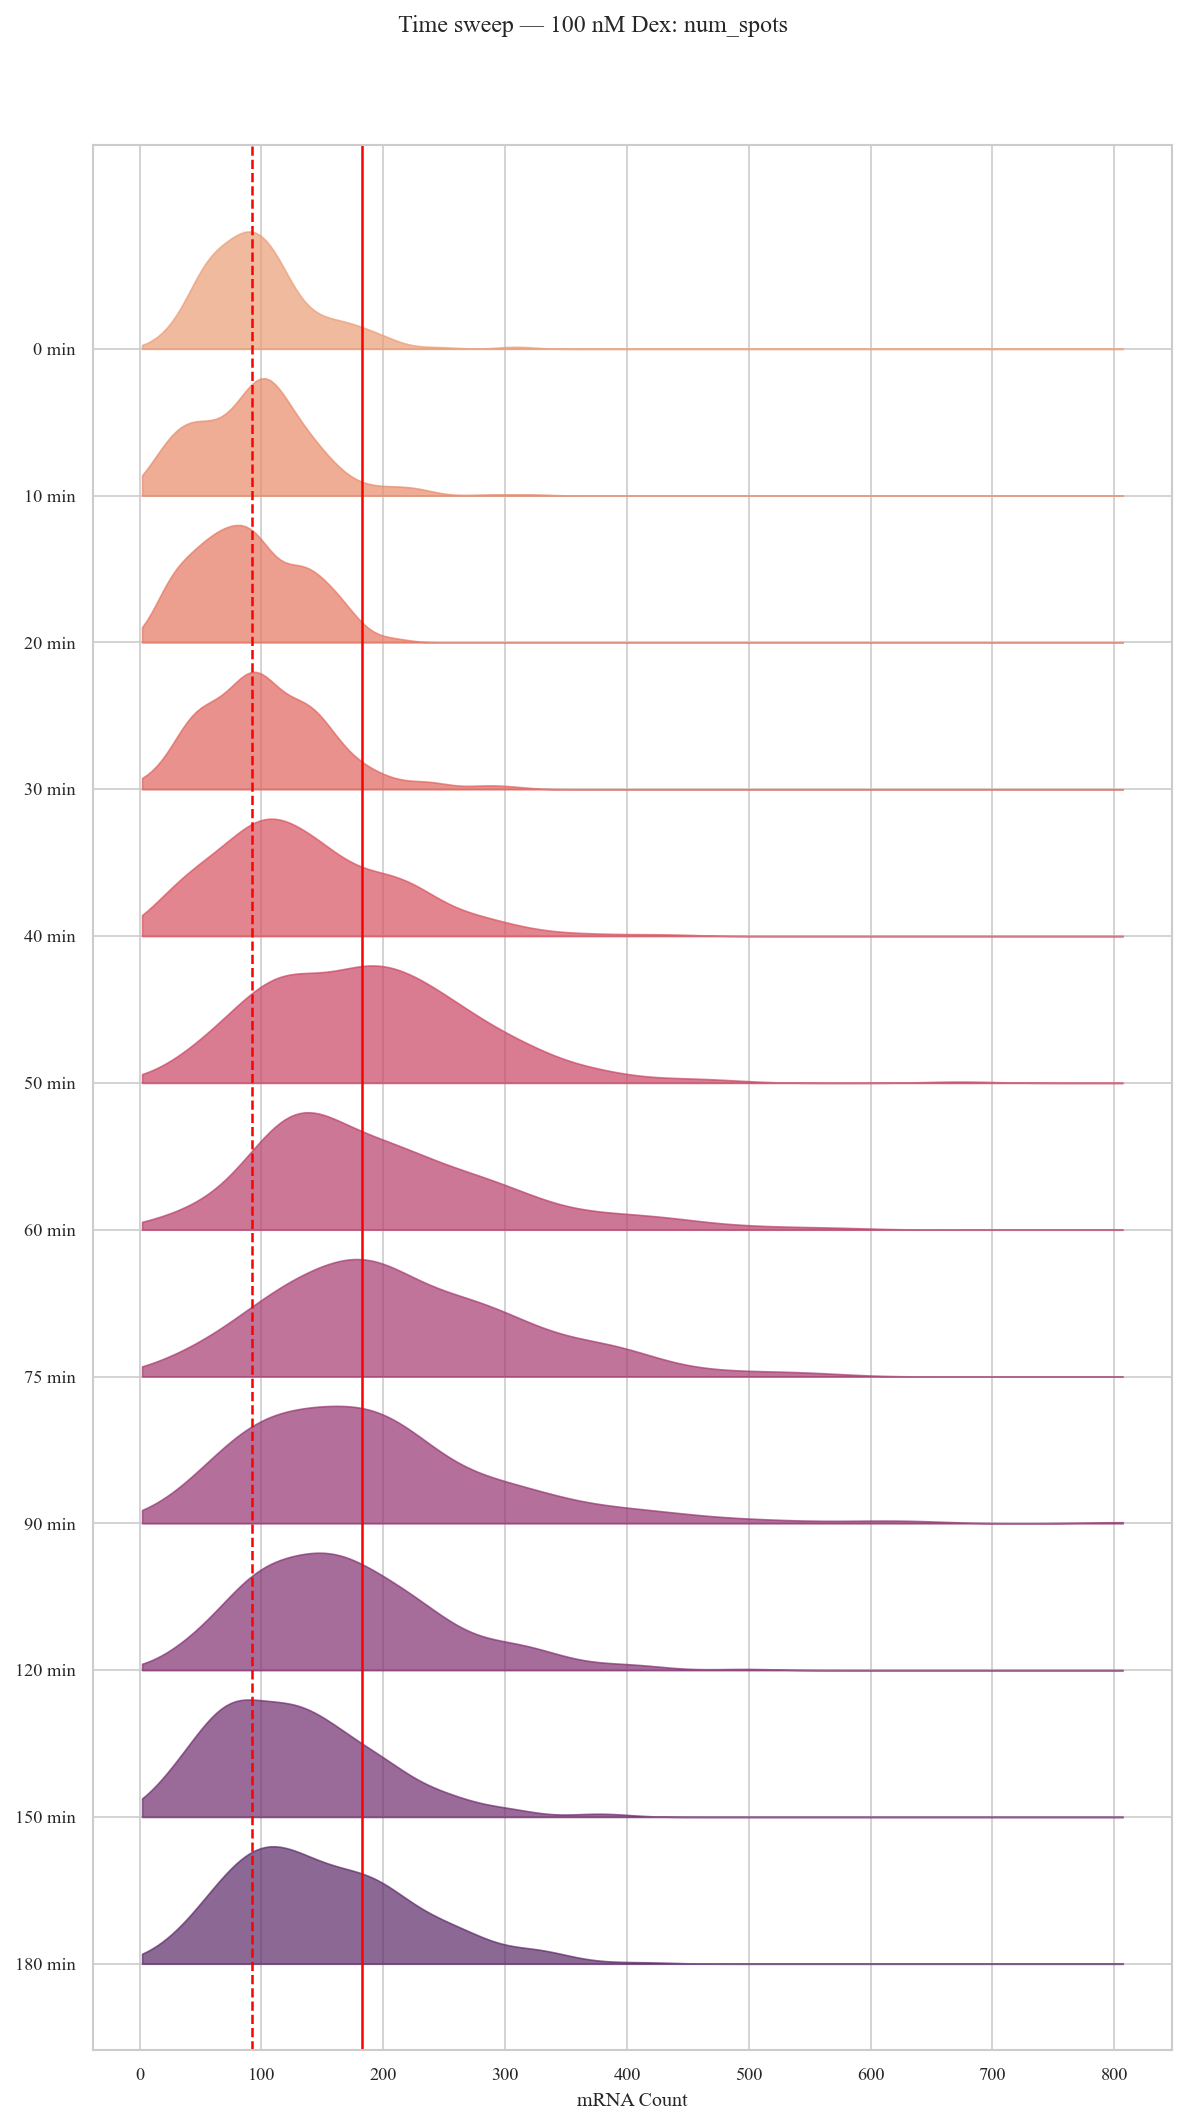

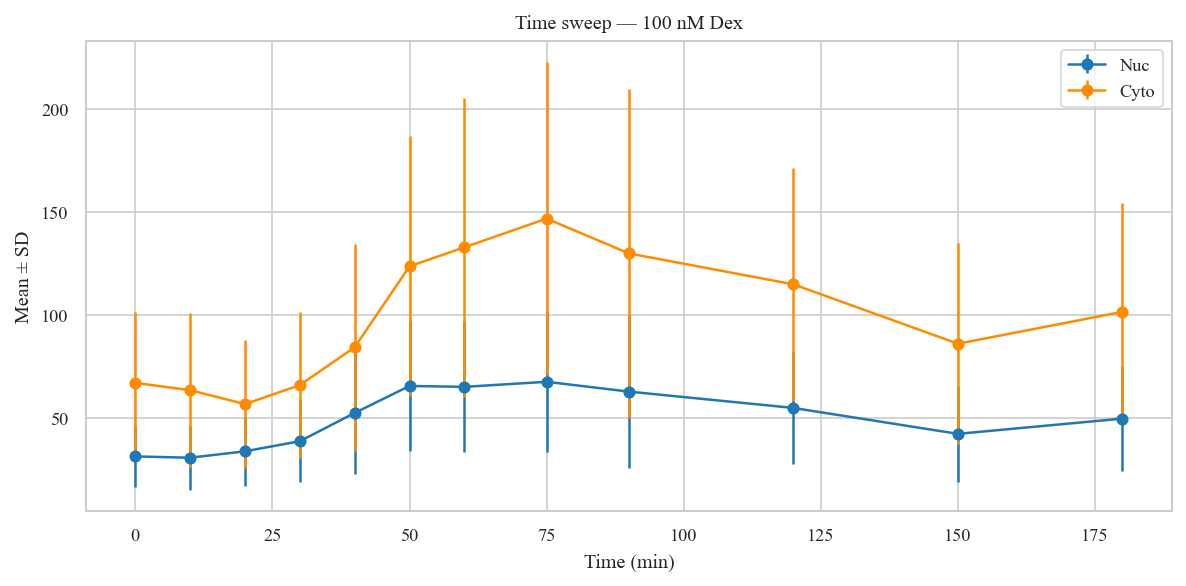

In [4]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_D_slide1_BFmean_061825',
    'DUSP1_D_slide2_BFmean_061825',
    'DUSP1_D_slide3_BFmean_061825',
    'DUSP1_D_slide4_BFmean_061825',
    'DUSP1_D_slide5_BFmean_061825',
    'DUSP1_D_slide6_BFmean_061825',
    'DUSP1_D_slide7_BFmean_061825',
    'DUSP1_D_slide8_BFmean_061825',
    'DUSP1_D_slide9_BFmean_061825',
    'DUSP1_D_slide10_BFmean_061825',
    'DUSP1_D_slide11_BFmean_061825',
    'DUSP1_D_slide12_BFmean_061825',        
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 10
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_D_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time sweep for 100nM Dex
print("\n>>> Time sweep for 100nM Dex")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica E 3hr 100nM time-sweep R2 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_0min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_0min.h5 -> Analysis_DUSP1_E_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_10min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_10min.h5 -> Analysis_DUSP1_E_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_20min.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_20min.h5 -> Analysis_DUSP1_E_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220420/DUSP1_100nM_Dex_R3_20220419_30min.h5
Reading DataFrame from: 

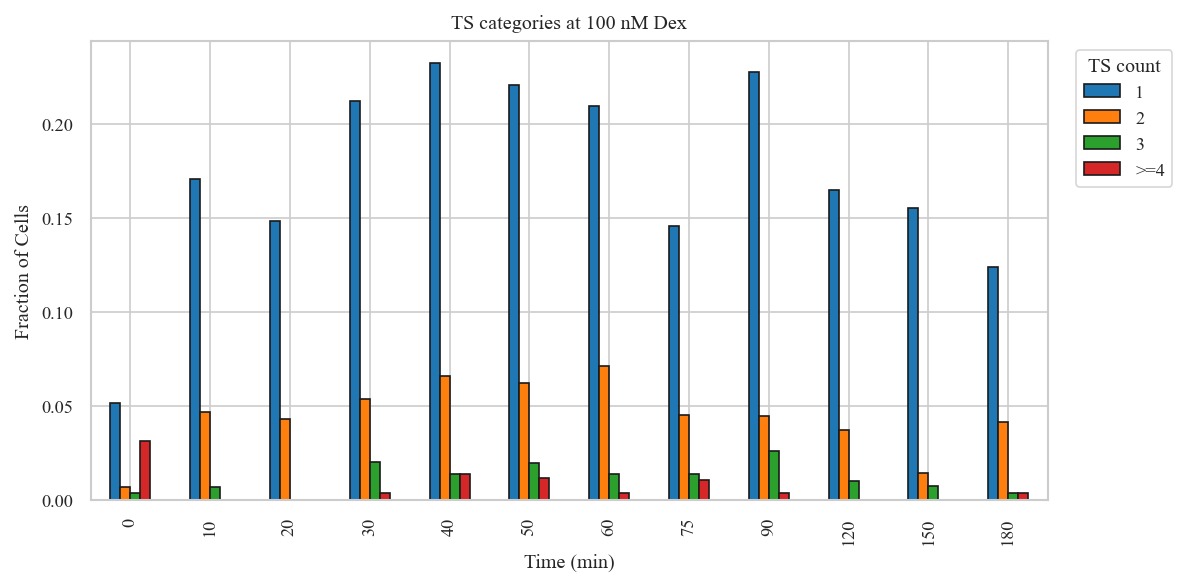

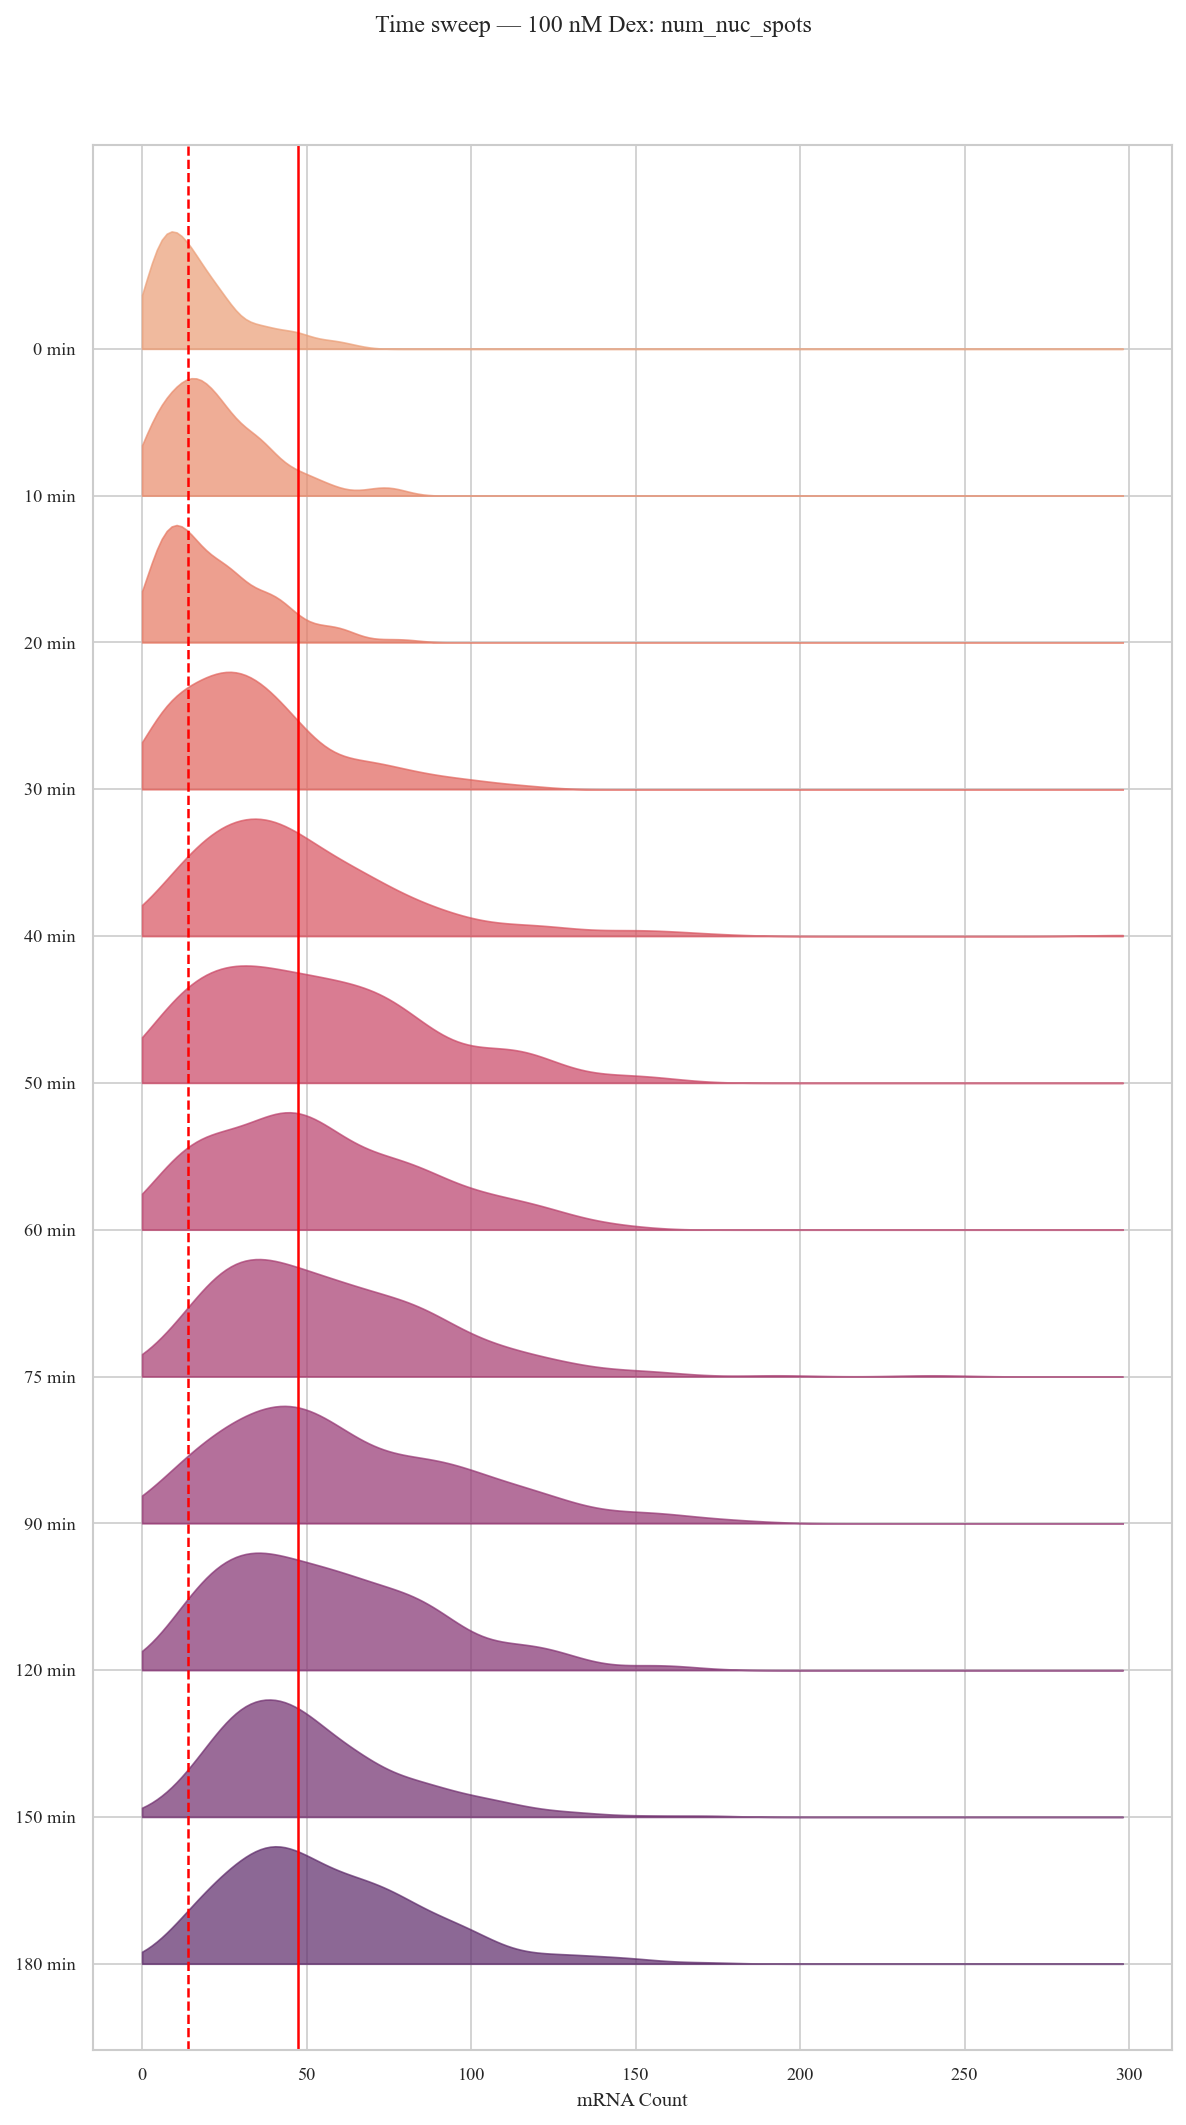

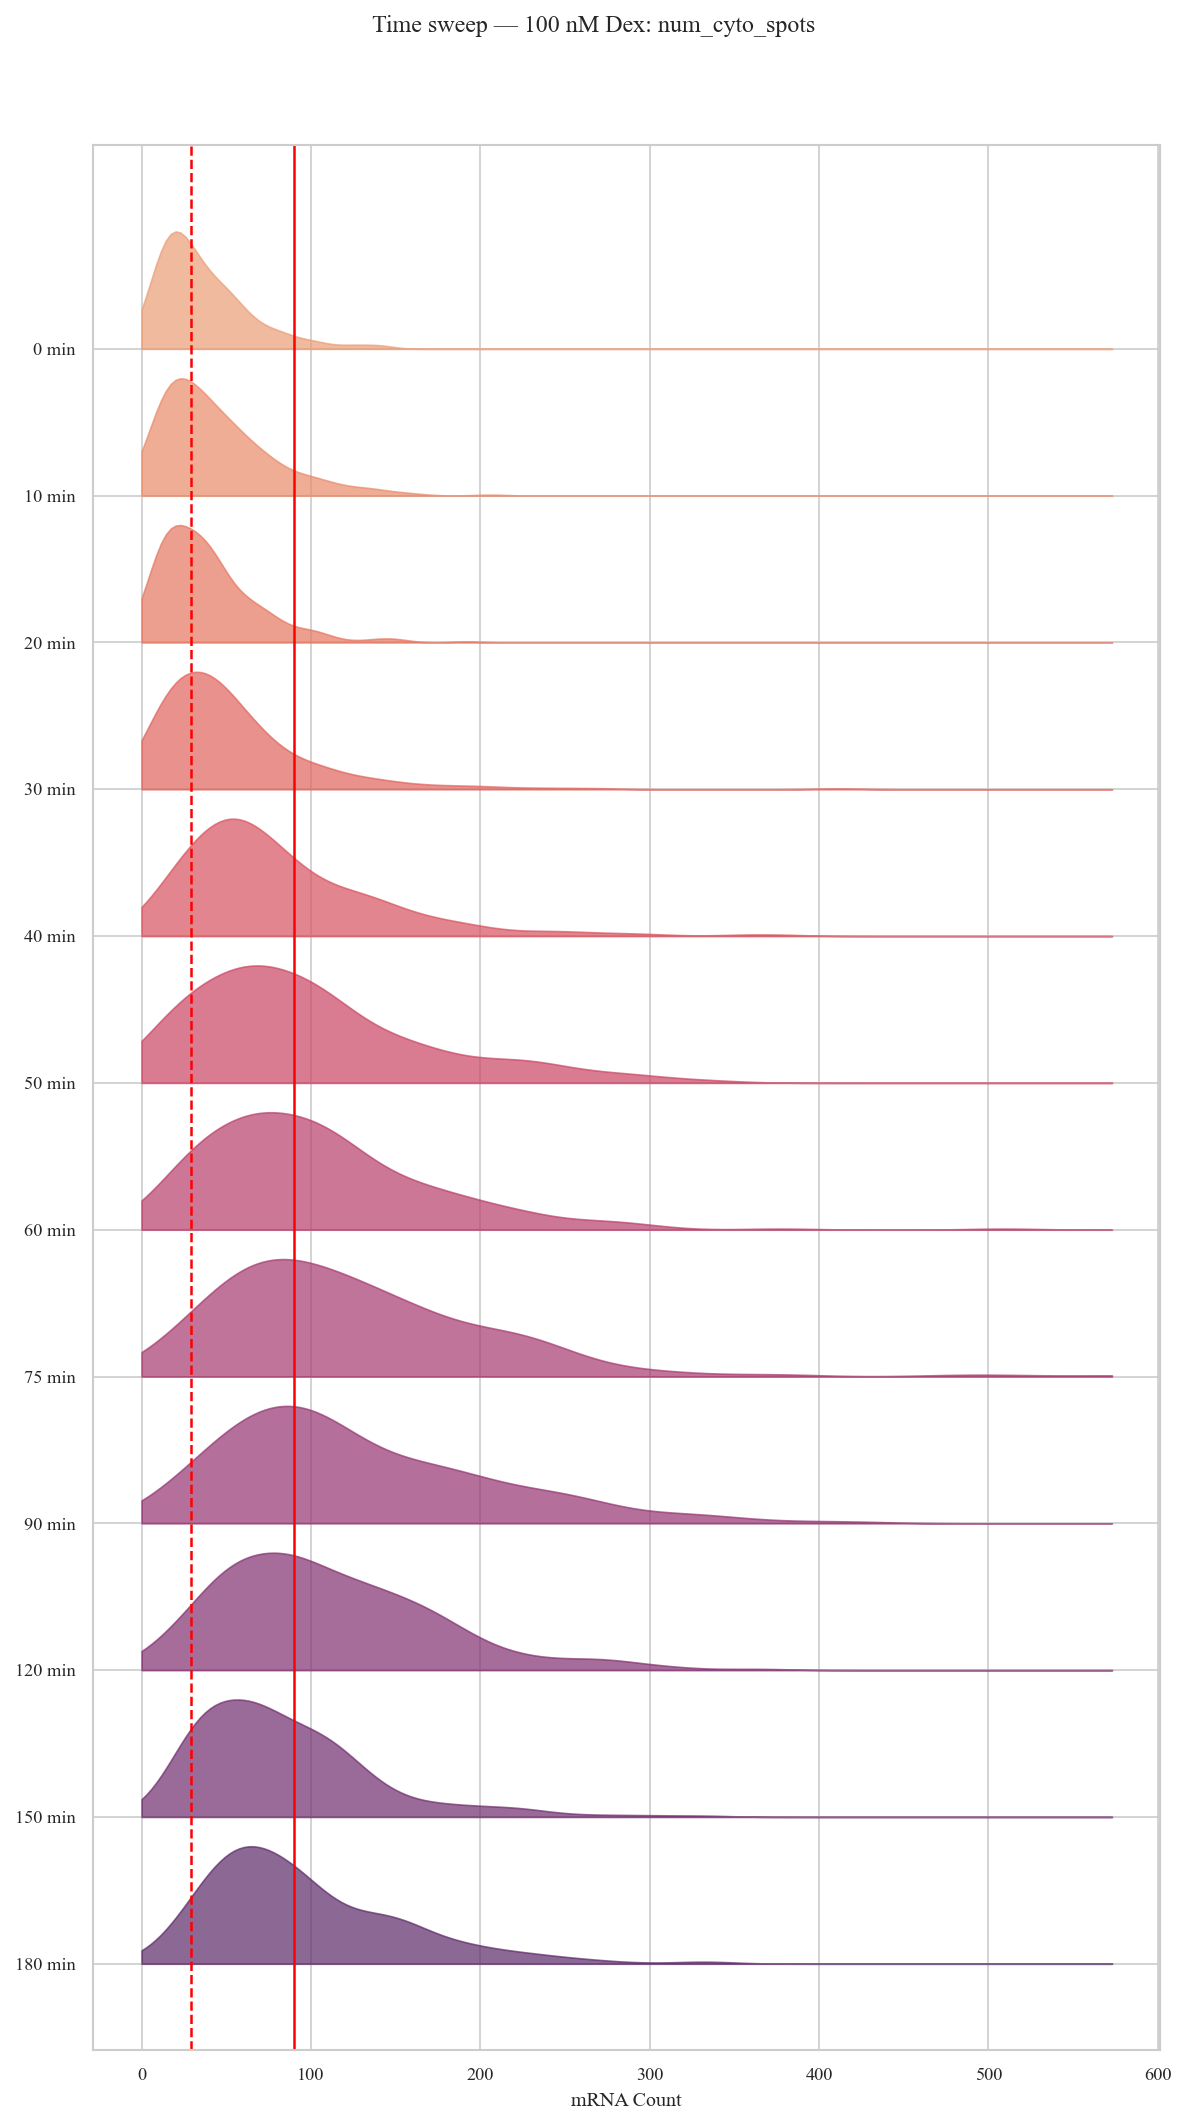

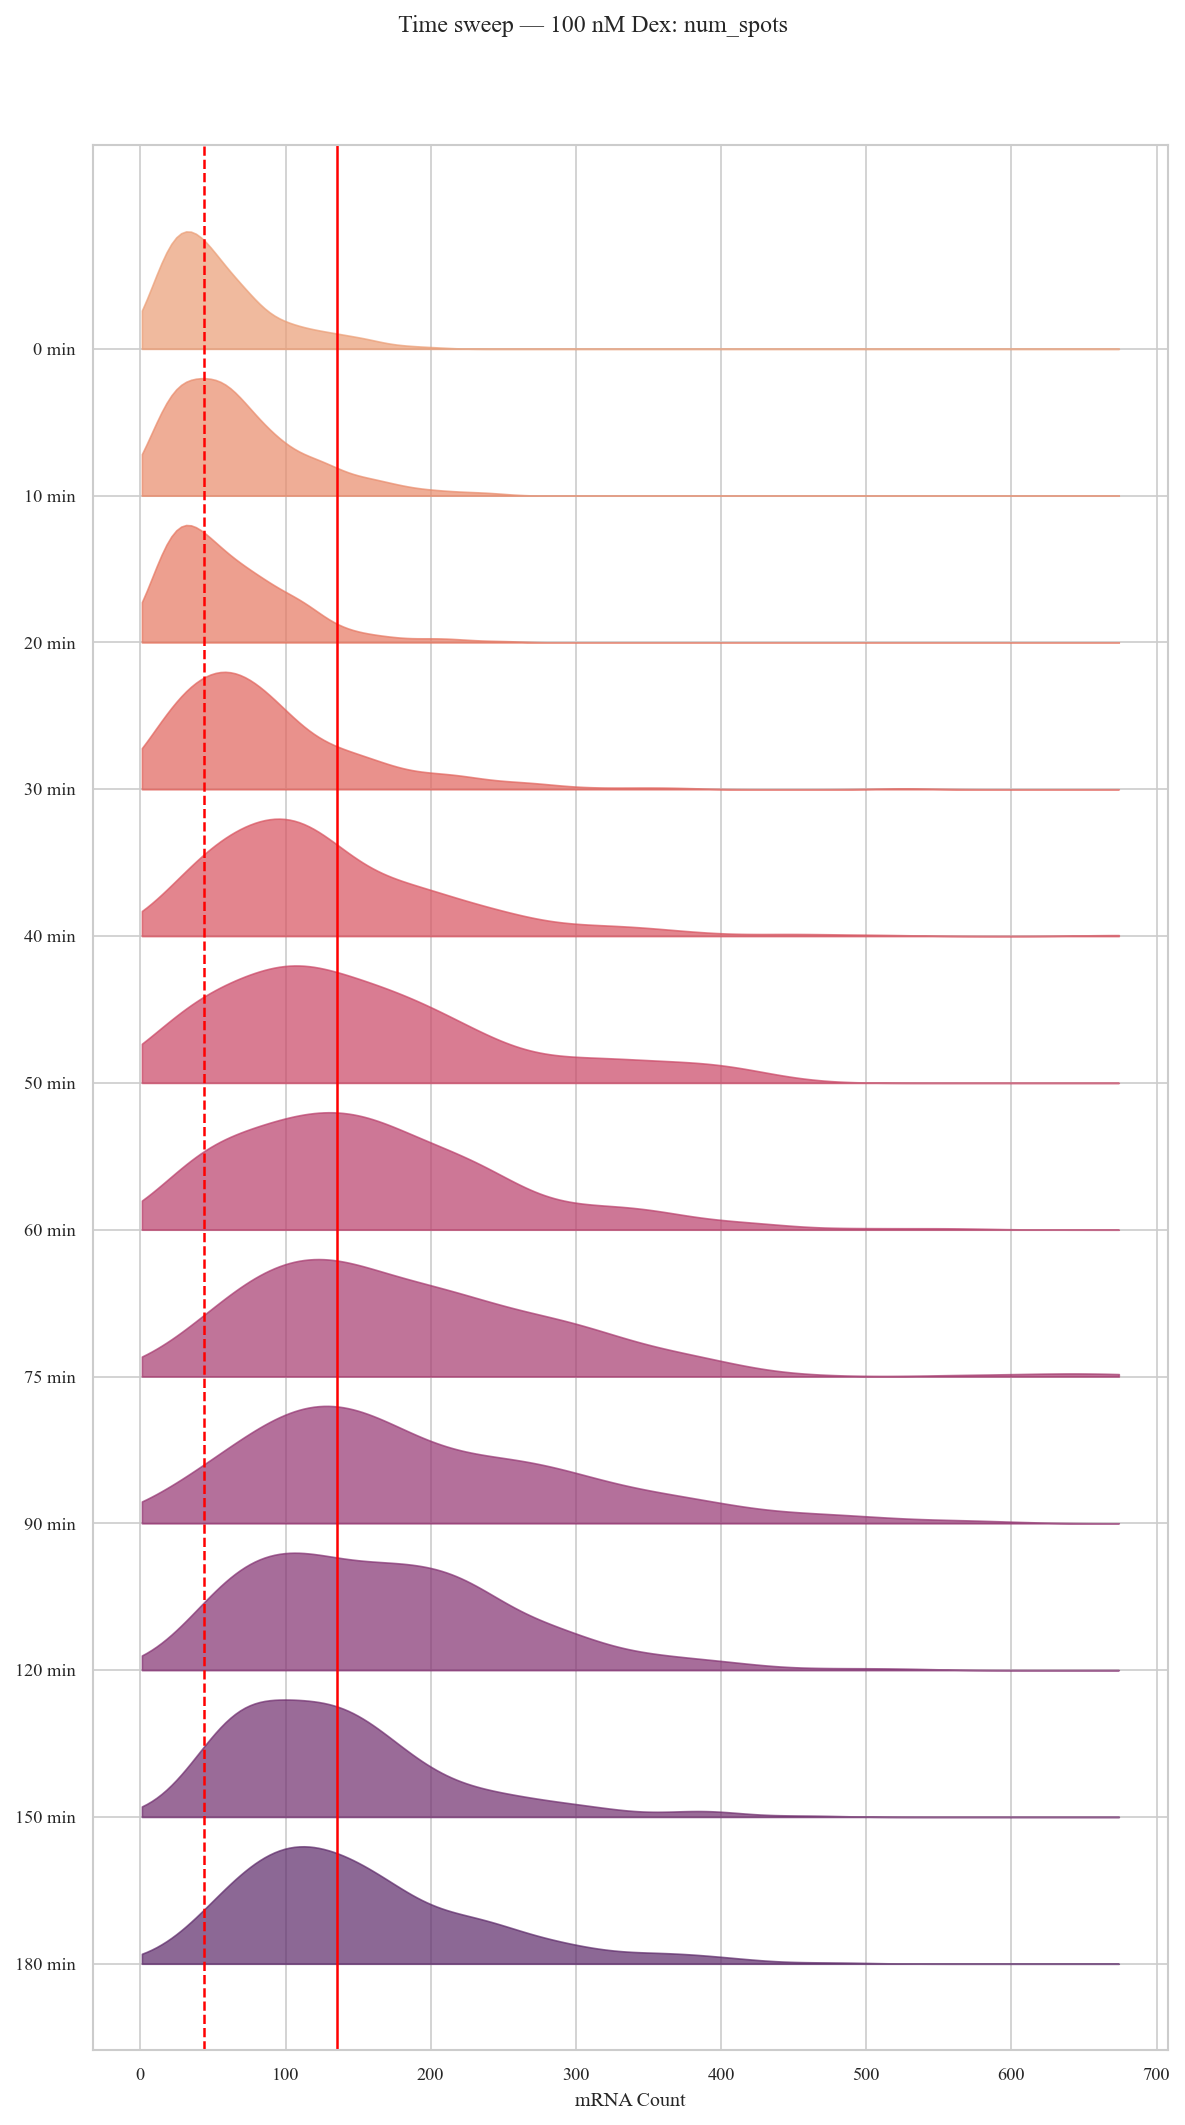

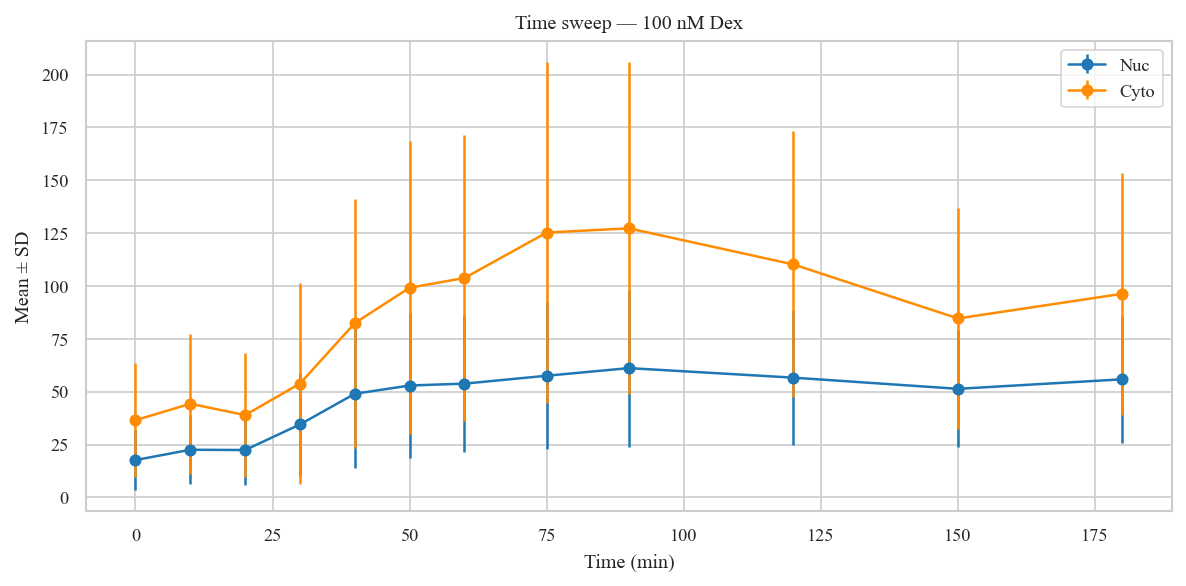

In [5]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_E_slide1_BFmean_061825',
    'DUSP1_E_slide2_BFmean_061825',
    'DUSP1_E_slide3_BFmean_061825',
    'DUSP1_E_slide4_BFmean_061825',
    'DUSP1_E_slide5_BFmean_061825',
    'DUSP1_E_slide6_BFmean_061825',
    'DUSP1_E_slide7_BFmean_061825',
    'DUSP1_E_slide8_BFmean_061825',
    'DUSP1_E_slide9_BFmean_061825',
    'DUSP1_E_slide10_BFmean_061825',
    'DUSP1_E_slide11_BFmean_061825',
    'DUSP1_E_slide12_BFmean_061825',        
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 20
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_E_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time sweep for 100nM Dex
print("\n>>> Time sweep for 100nM Dex")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica F 3hr 100nM time-sweep R3 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_0min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_0min_NoSpin_052722.h5 -> Analysis_DUSP1_F_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_10min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_10min_NoSpin_052722.h5 -> Analysis_DUSP1_F_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_20min_NoSpin_052722.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_20min_NoSpin_052722.h5 -> Analysis_DUSP1_F_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220602/DUSP1_Dex_100nM_30min_NoSpin_052722.h5
Reading Da

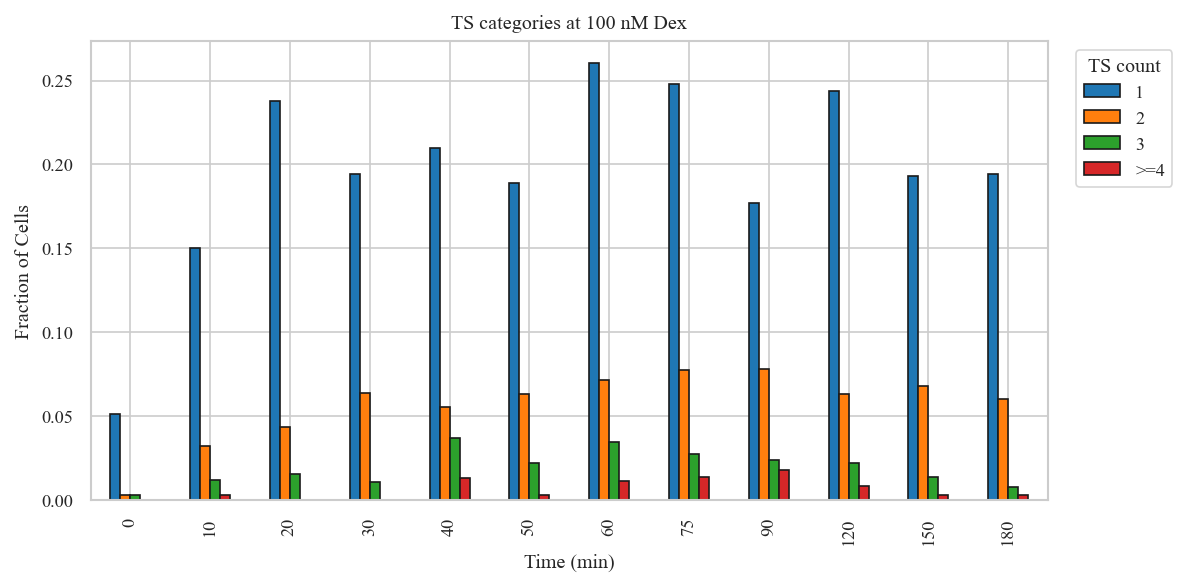

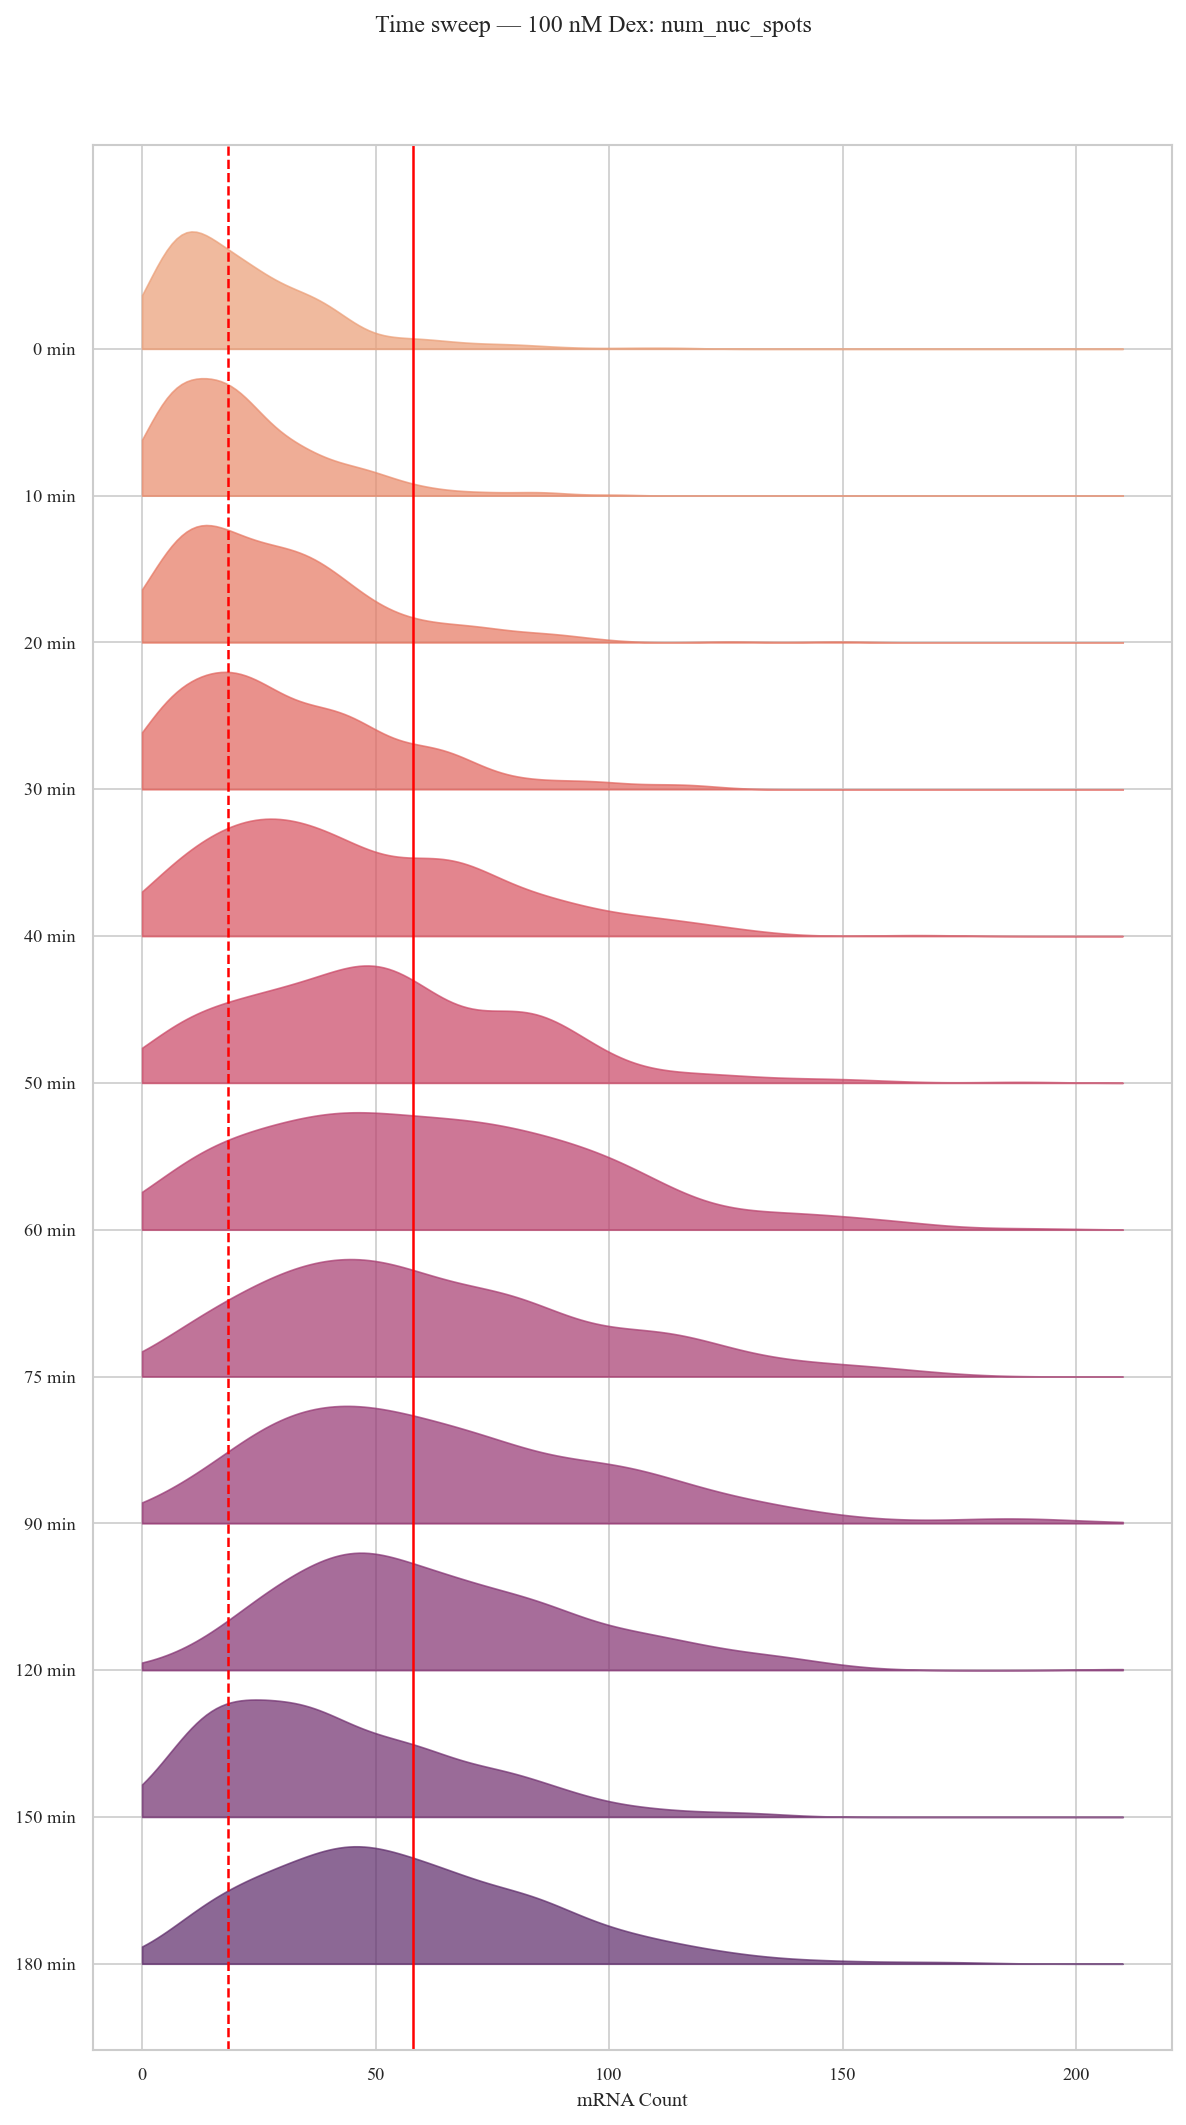

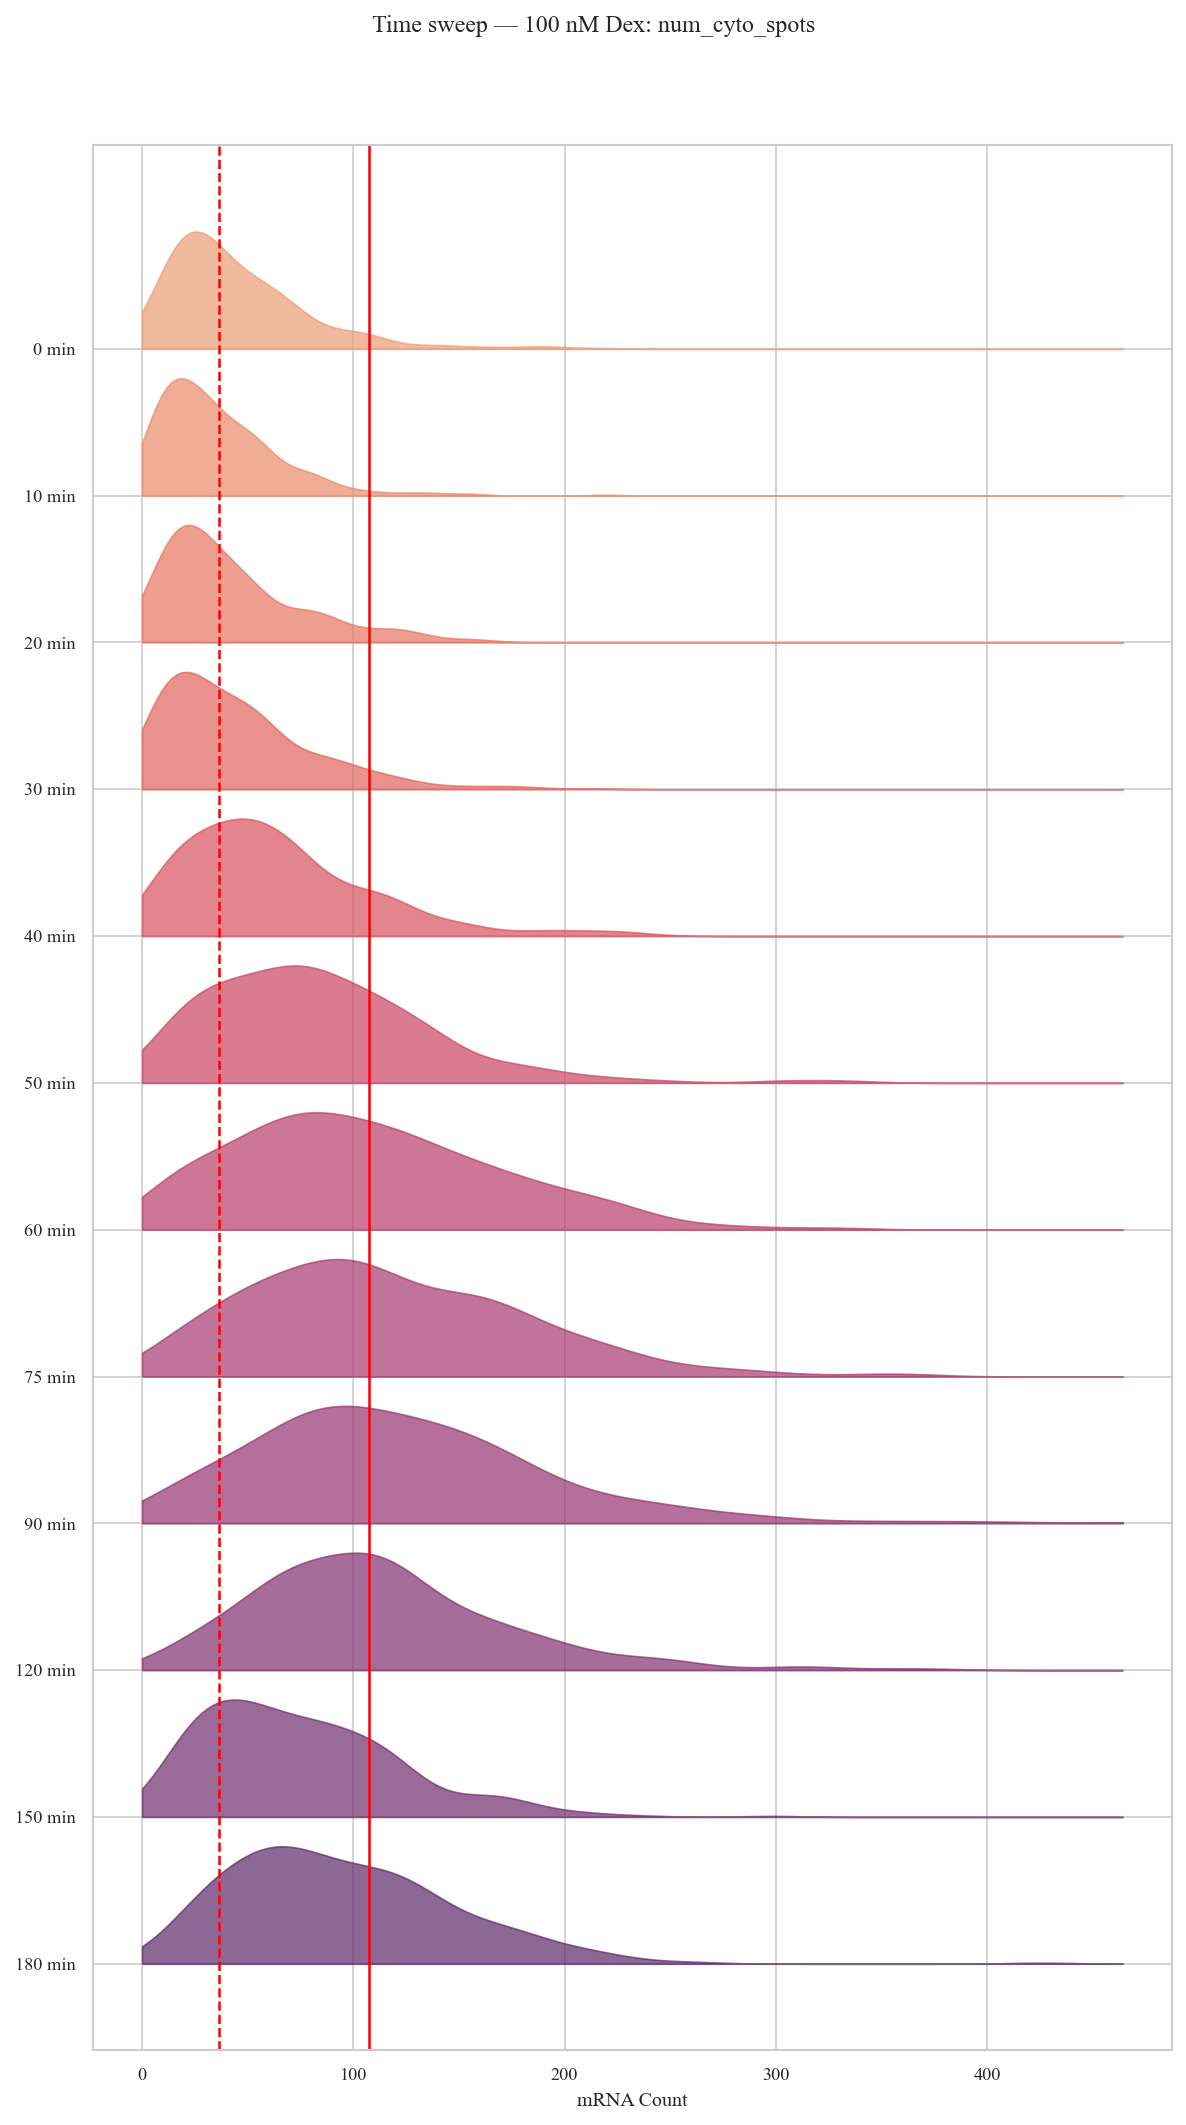

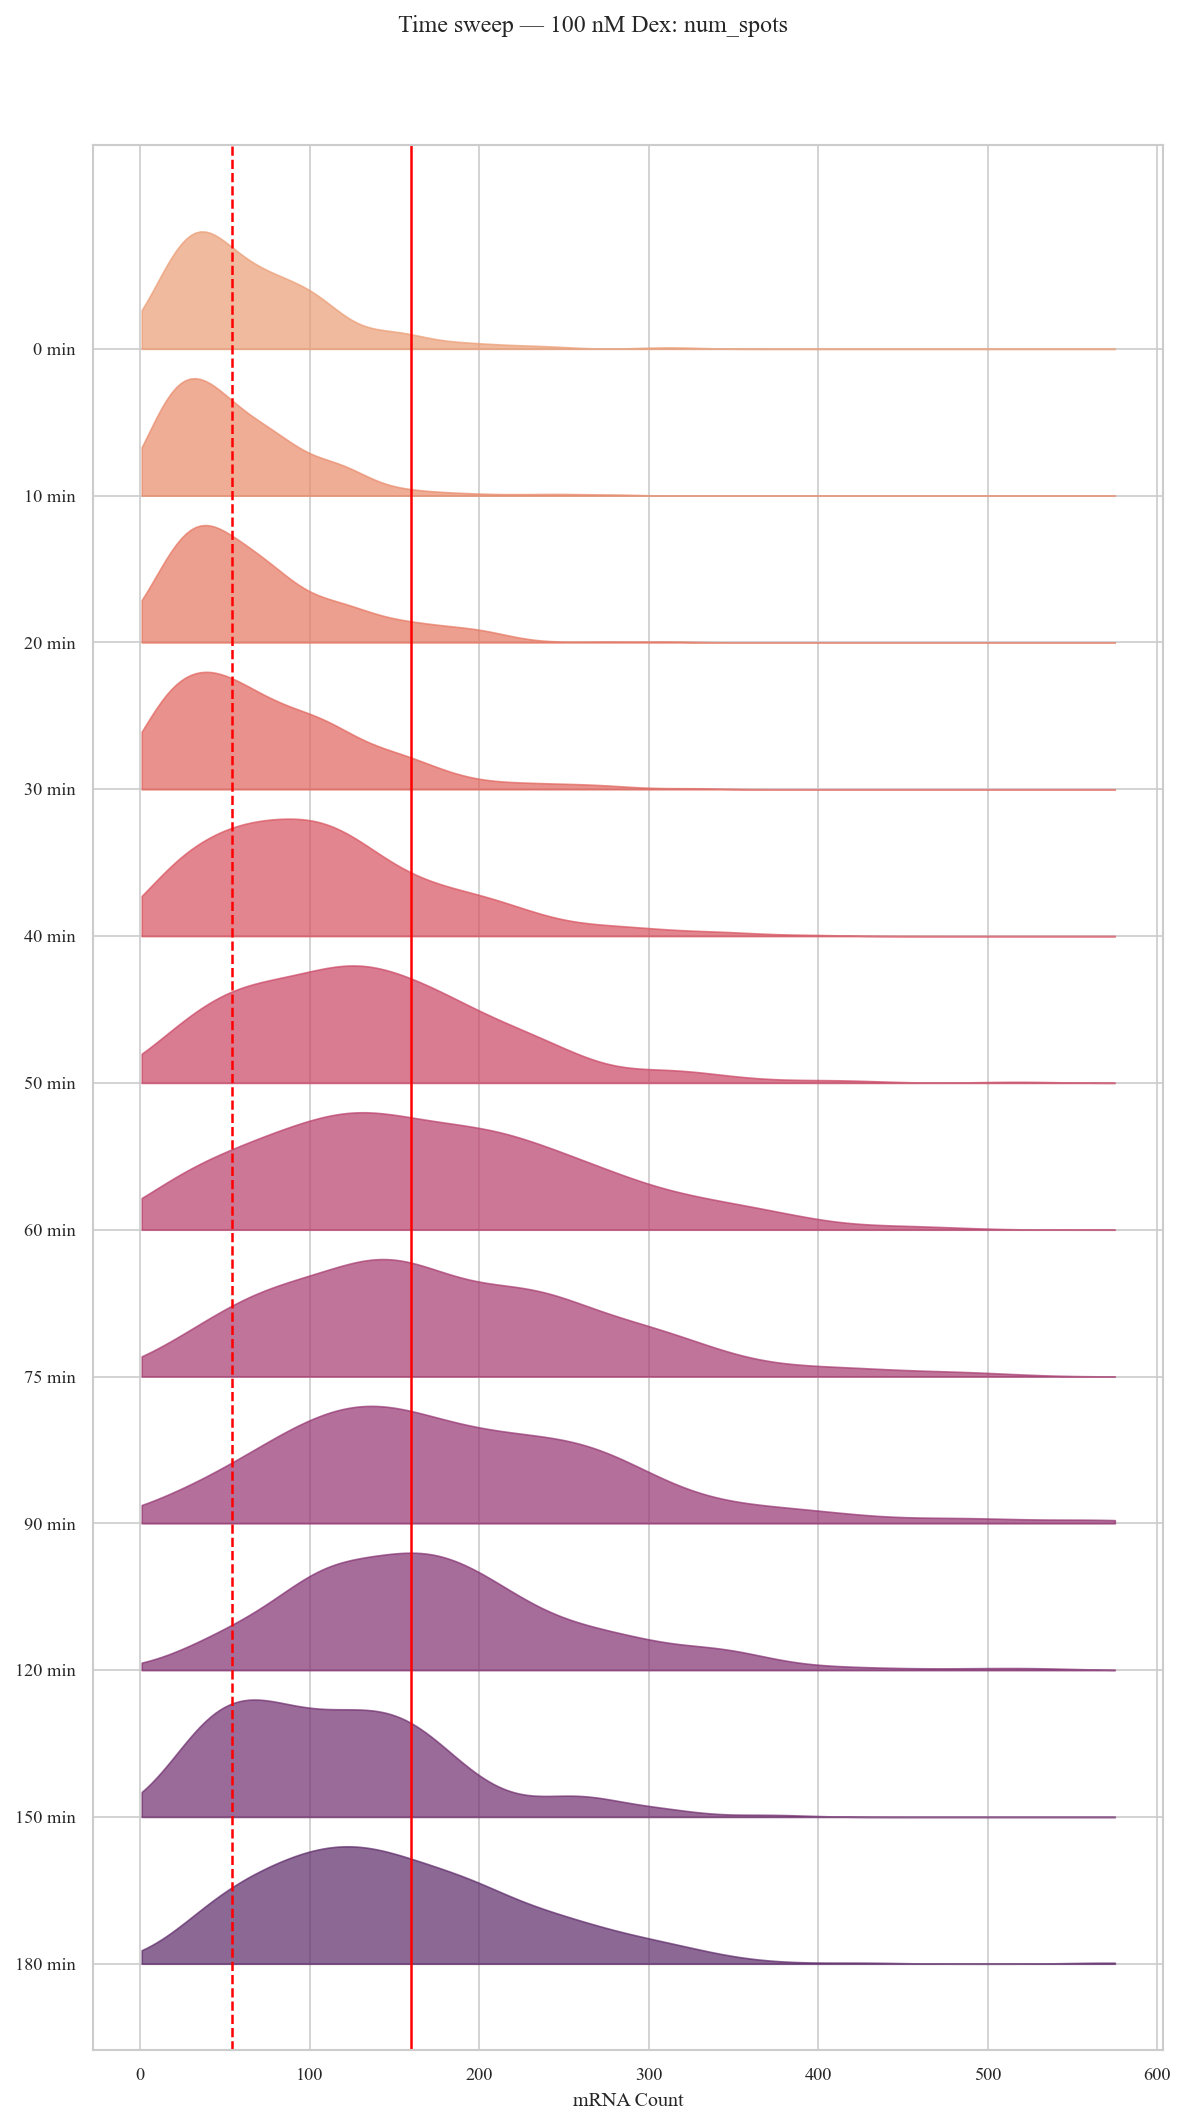

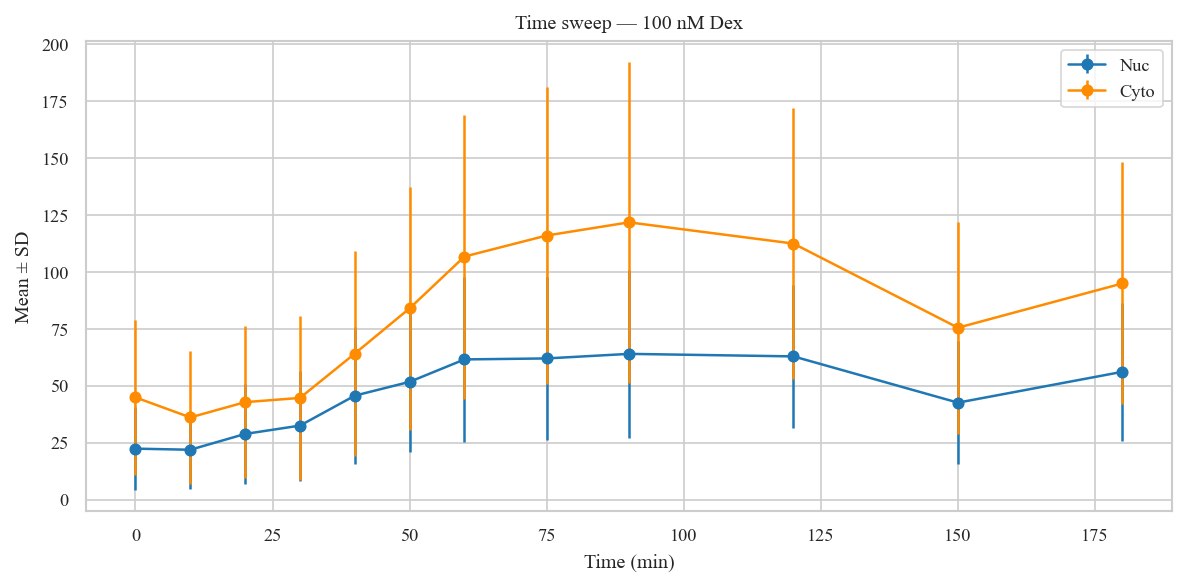

In [6]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_F_slide1_BFmean_061825',
    'DUSP1_F_slide2_BFmean_061825',
    'DUSP1_F_slide3_BFmean_061825',
    'DUSP1_F_slide4_BFmean_061825',
    'DUSP1_F_slide5_BFmean_061825',
    'DUSP1_F_slide6_BFmean_061825',
    'DUSP1_F_slide7_BFmean_061825',
    'DUSP1_F_slide8_BFmean_061825',
    'DUSP1_F_slide9_BFmean_061825',
    'DUSP1_F_slide10_BFmean_061825',
    'DUSP1_F_slide11_BFmean_061825',
    'DUSP1_F_slide12_BFmean_061825',       
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 30
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_F_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time sweep for 100nM Dex
print("\n>>> Time sweep for 100nM Dex")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica M 3hr 100nM time-sweep Partial Replica - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_0min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_0min_072022.h5 -> Analysis_DUSP1_M_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_150min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_150min_072022.h5 -> Analysis_DUSP1_M_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_180min_072022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6hr_180min_072022.h5 -> Analysis_DUSP1_M_slide3_BFmean_061825_2025-06-18/spotresults
Successfully loaded 3 DataFrames. Merging...
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220725/DUSP1_Dex_100nM_6h

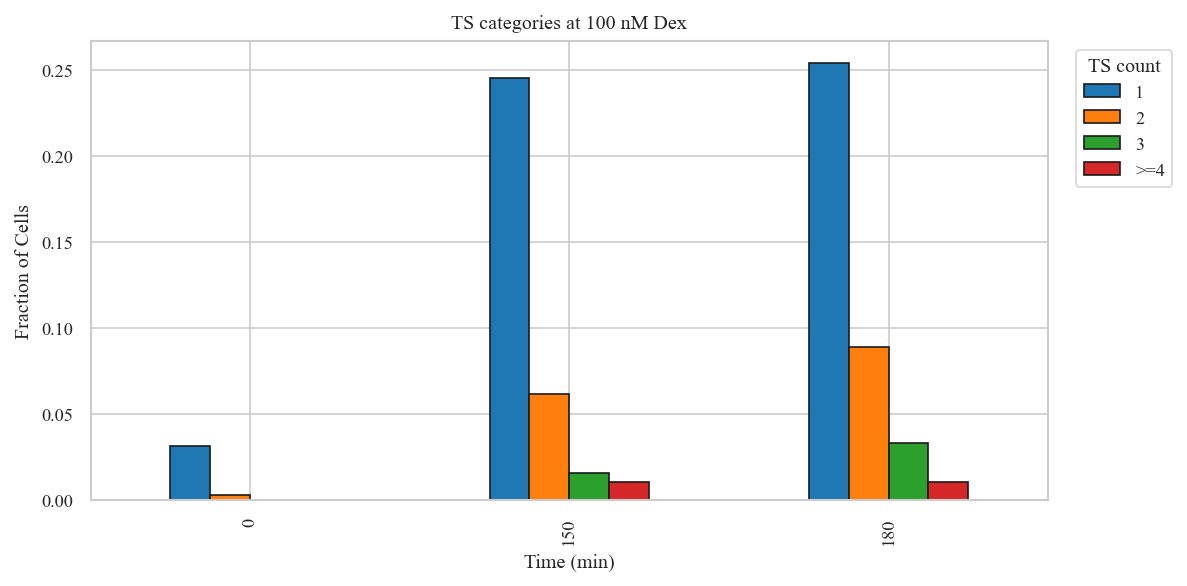

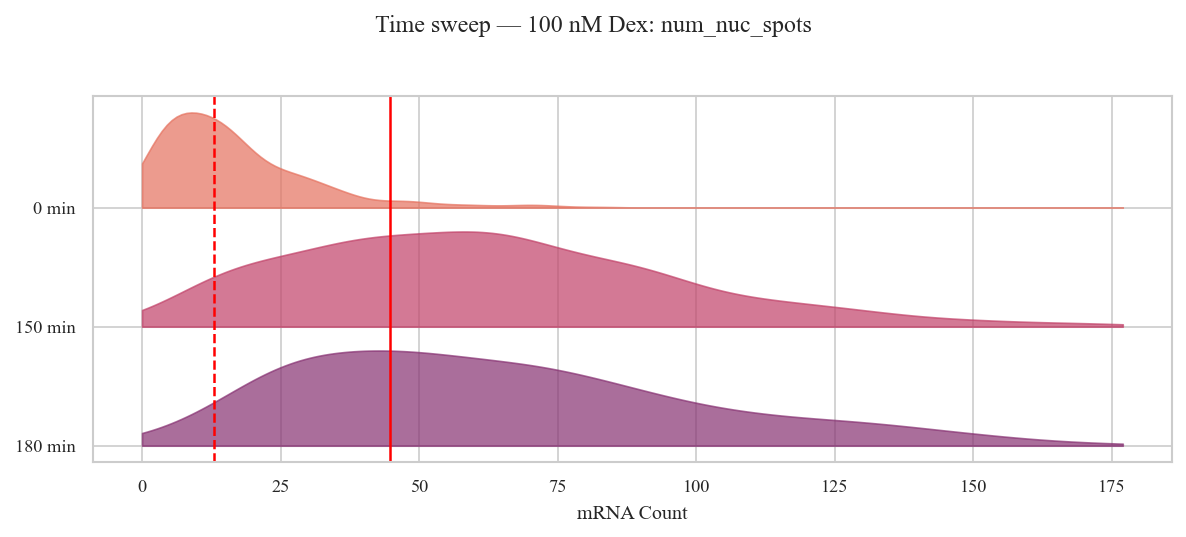

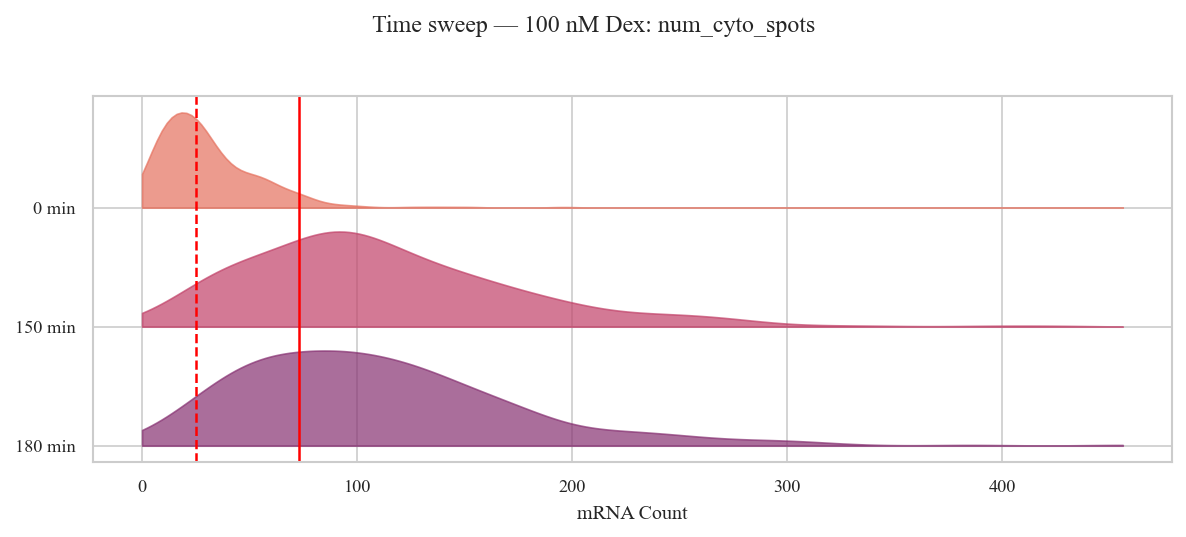

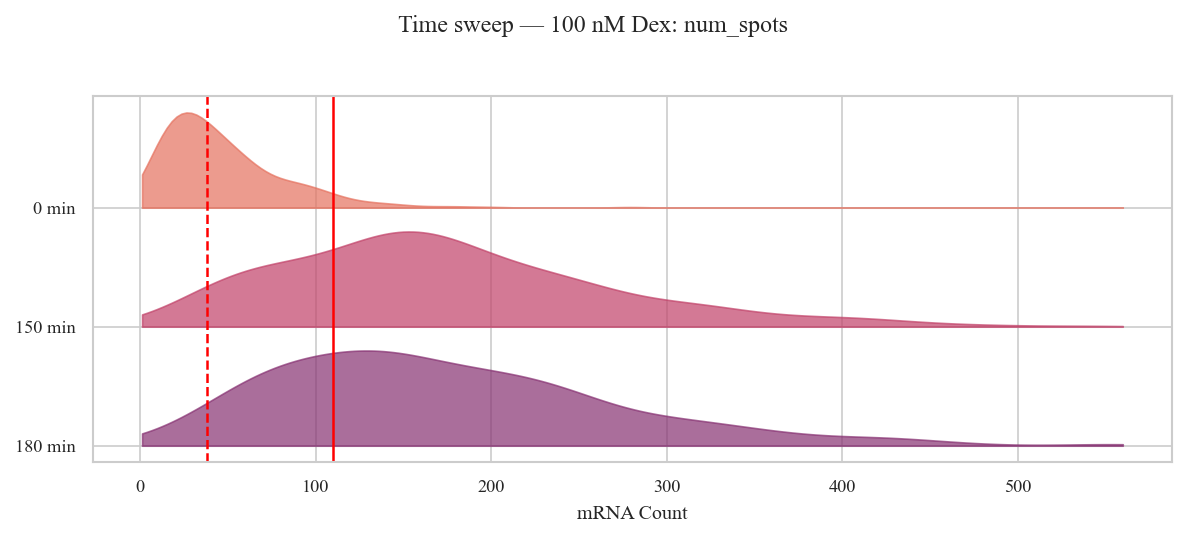

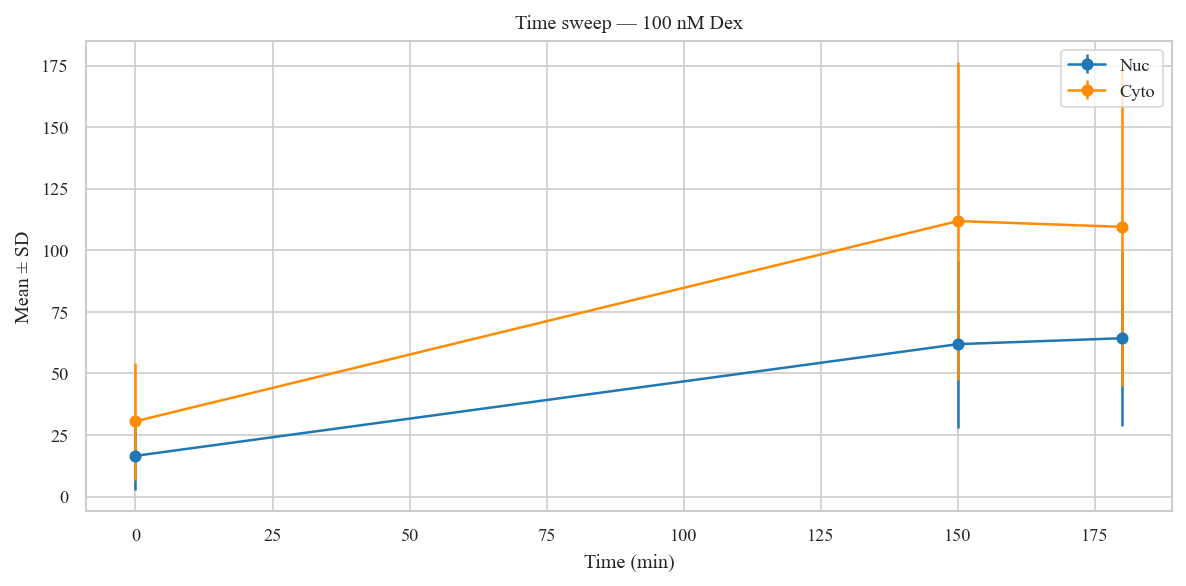

In [7]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_M_slide1_BFmean_061825',
    'DUSP1_M_slide2_BFmean_061825',
    'DUSP1_M_slide3_BFmean_061825',      
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 40
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_M_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time sweep for 100nM Dex
print("\n>>> Time sweep for 100nM Dex")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica N 3hr 100nM time-sweep Partial Replica - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_0min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_0min_081822.h5 -> Analysis_DUSP1_N_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_30min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_30min_081822.h5 -> Analysis_DUSP1_N_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_60min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220927/DUSP1_100nM_Dex_60min_081822.h5 -> Analysis_DUSP1_N_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220928/DUSP1_100nM_Dex_90min_081822.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_s

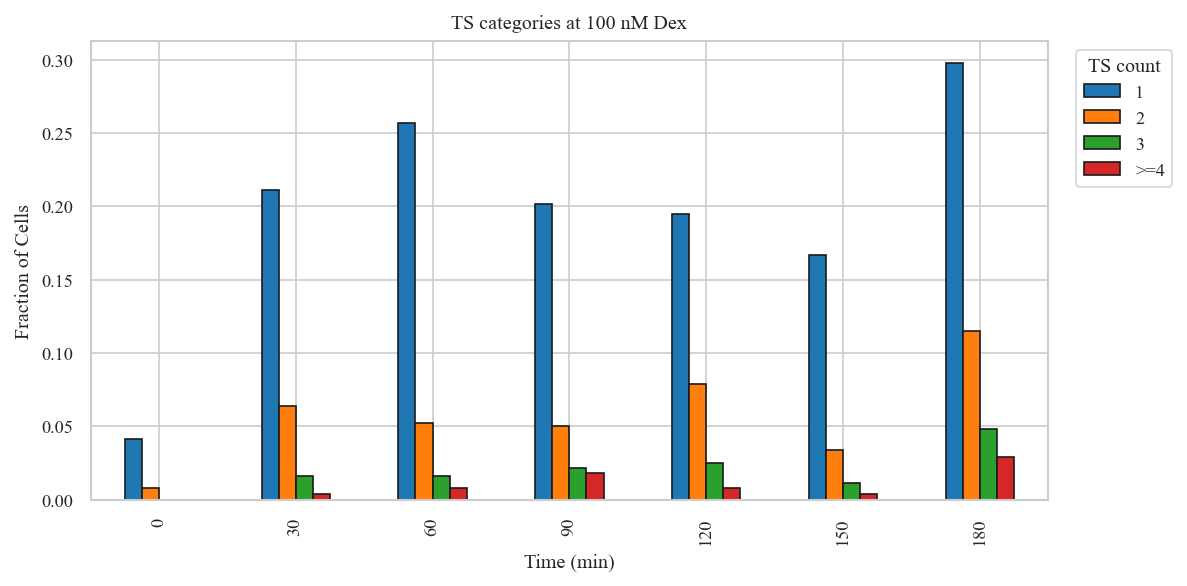

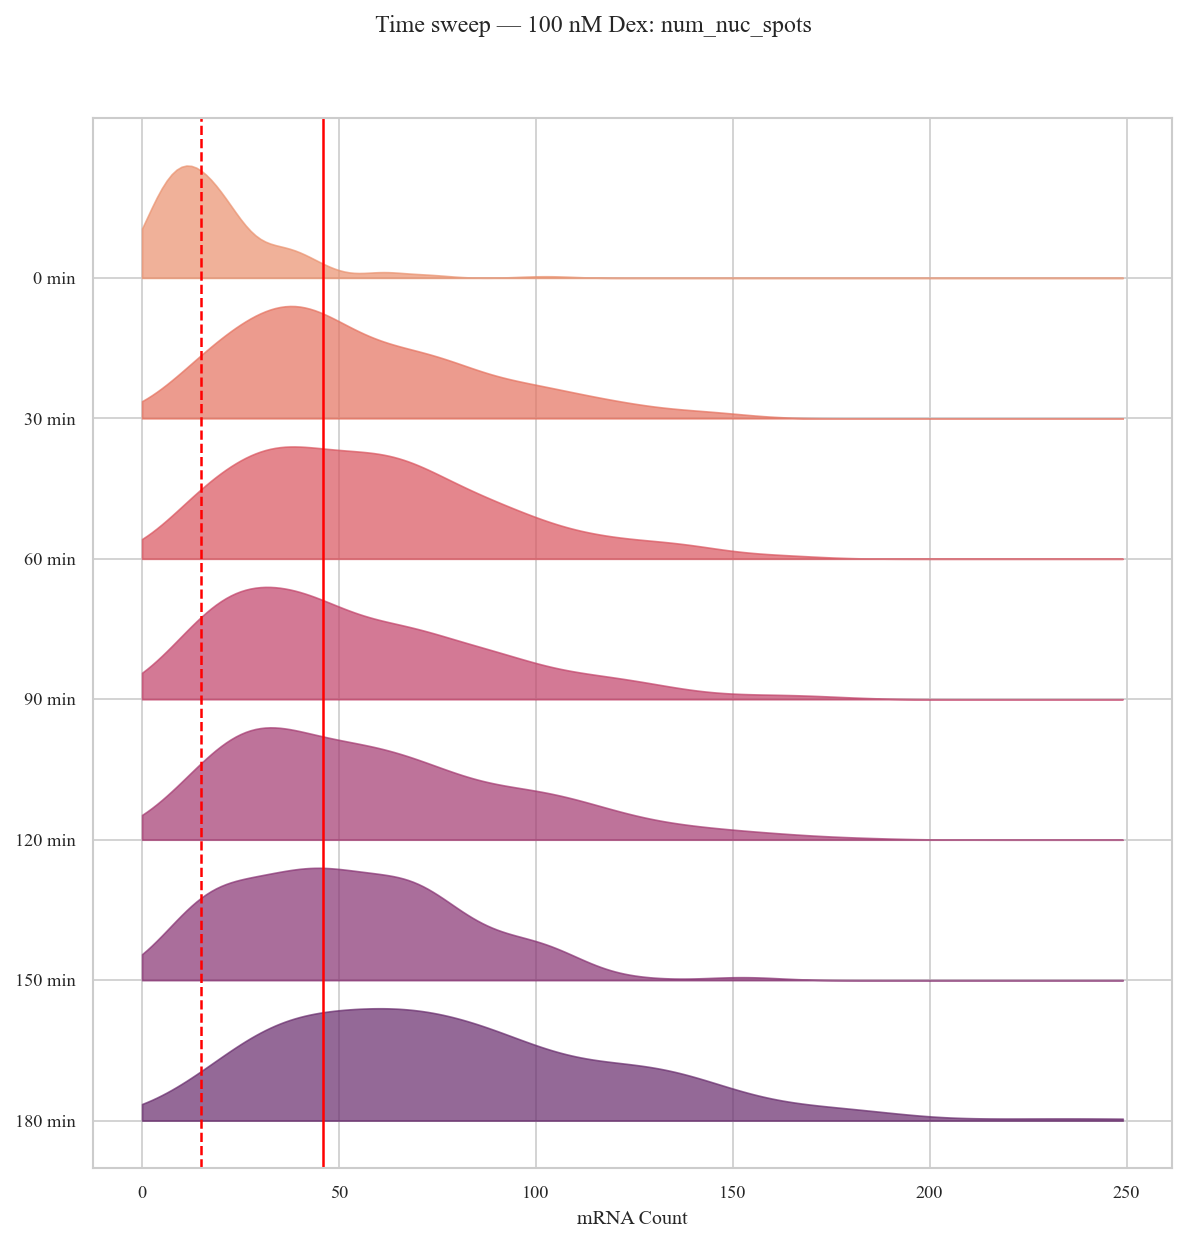

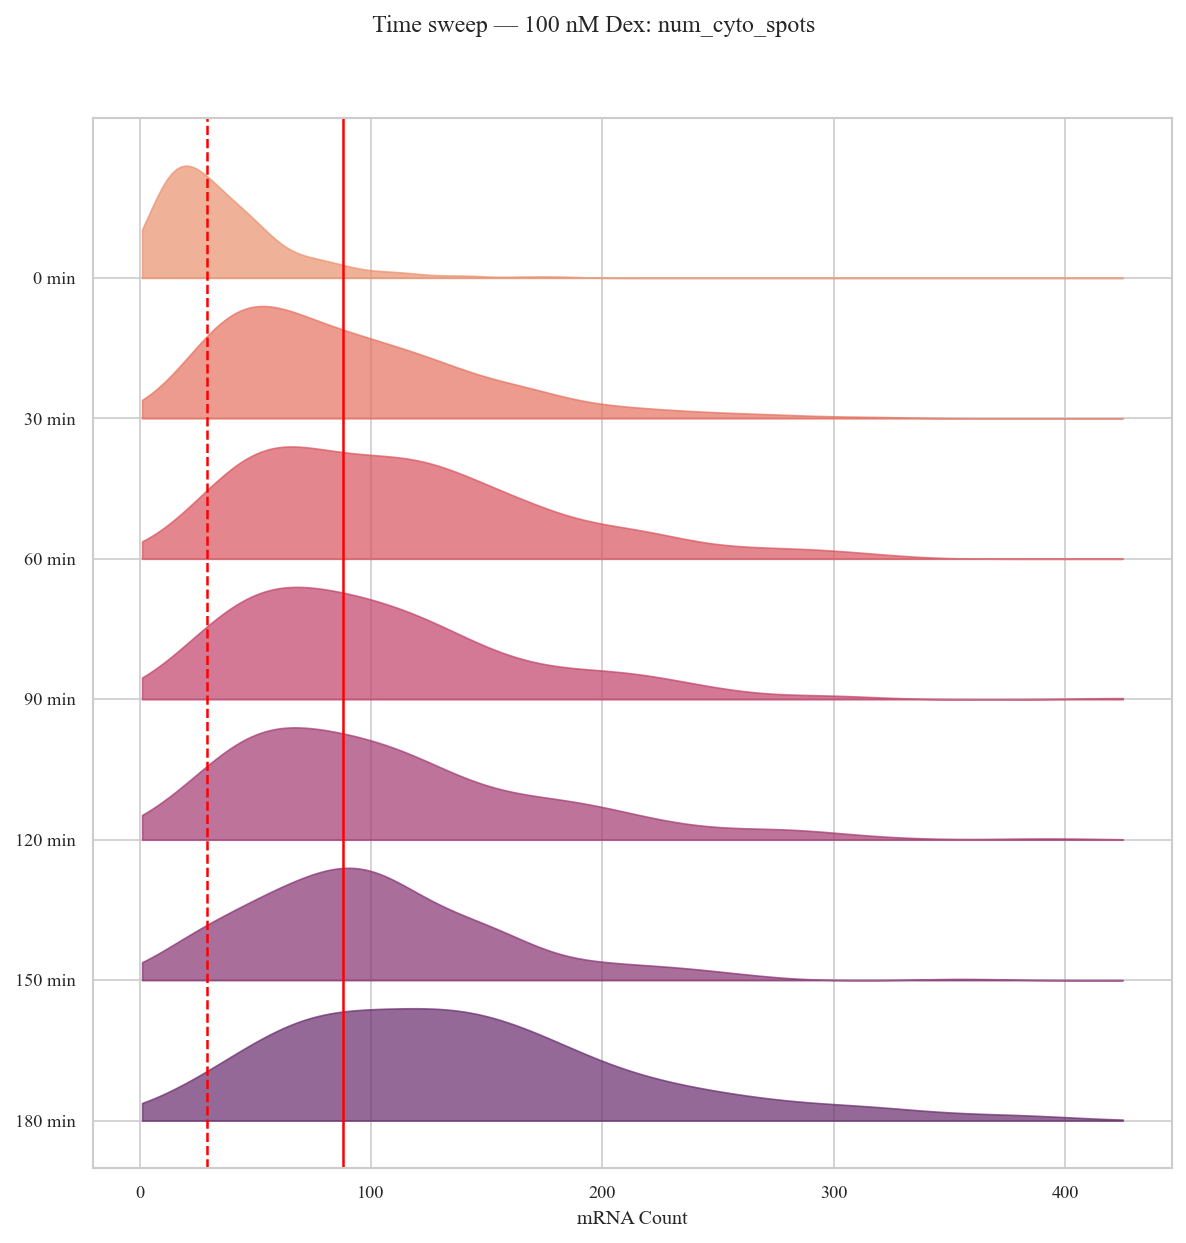

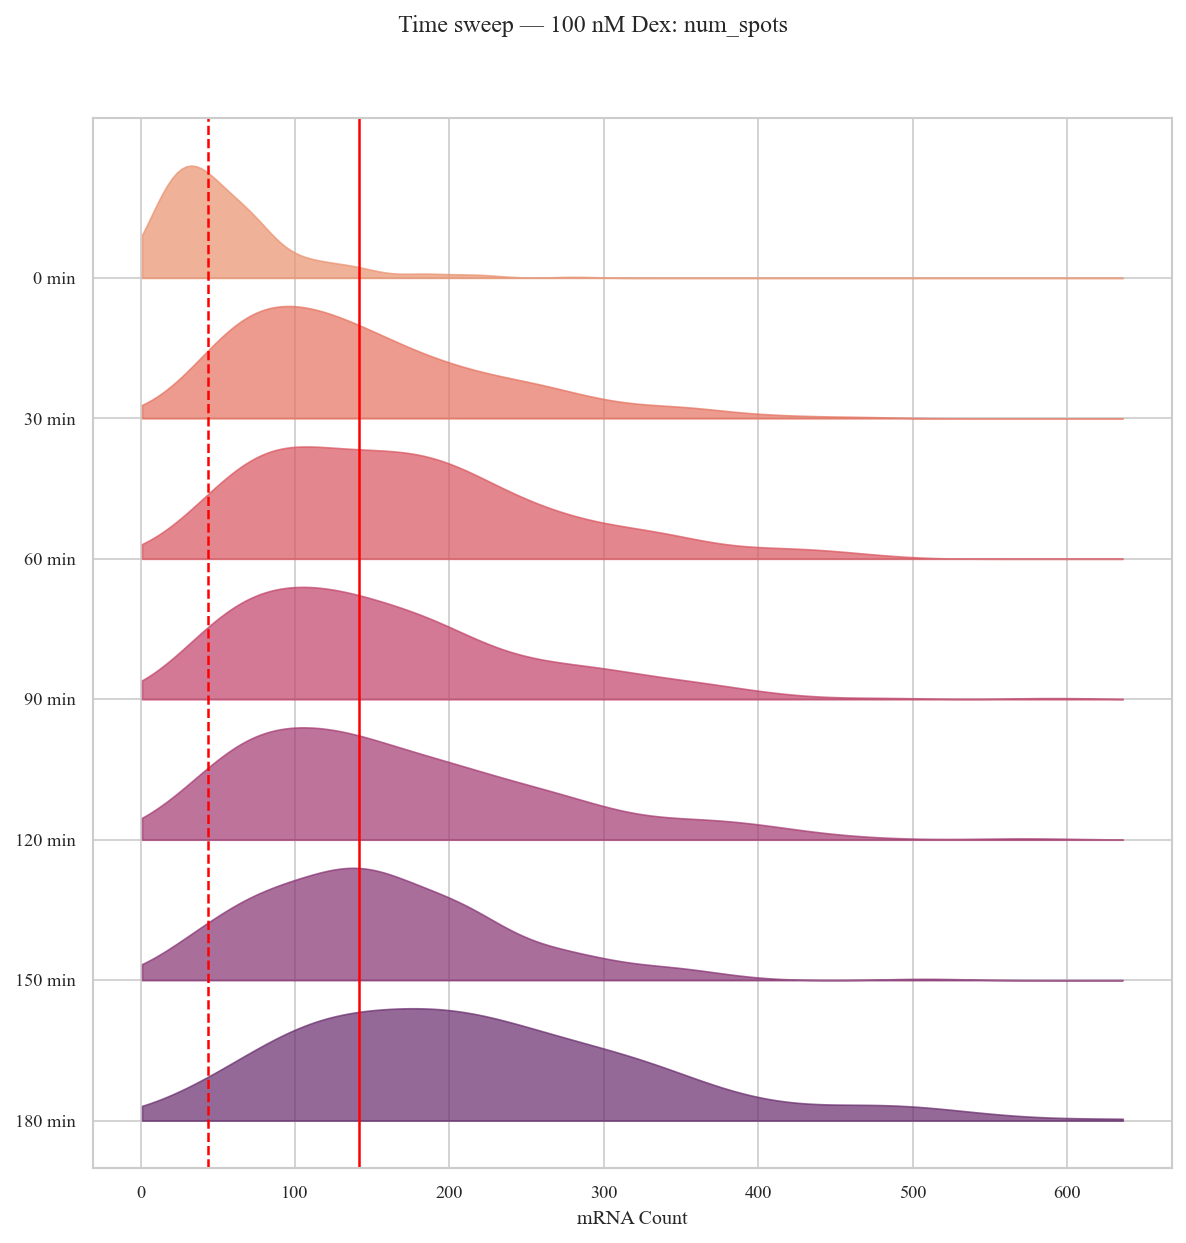

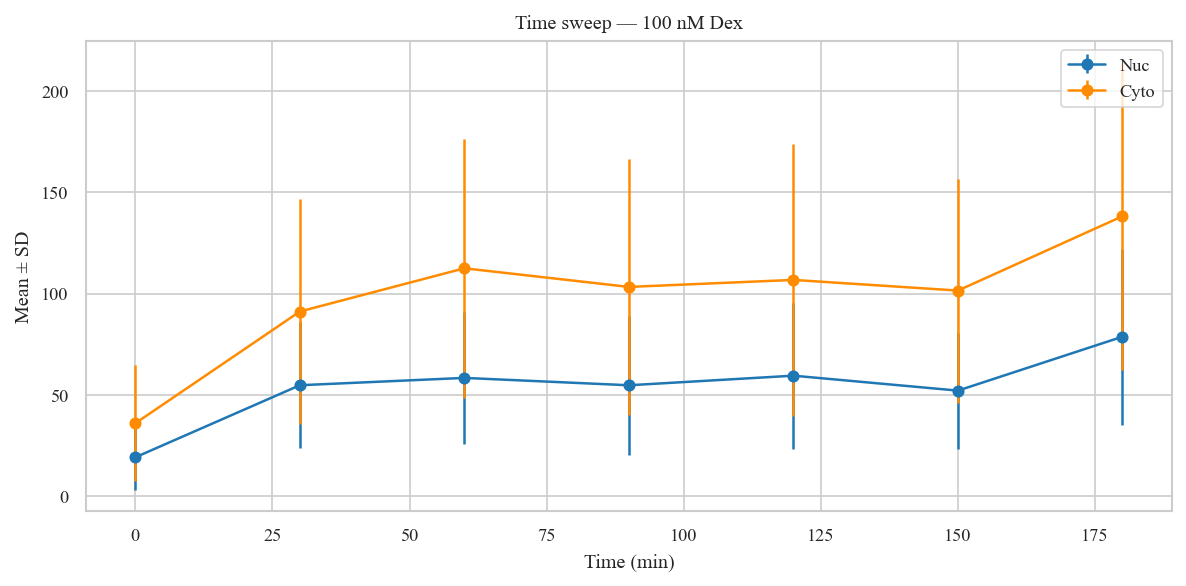

In [8]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_N_slide1_BFmean_061825',
    'DUSP1_N_slide2_BFmean_061825',
    'DUSP1_N_slide3_BFmean_061825',
    'DUSP1_N_slide4_BFmean_061825',
    'DUSP1_N_slide5_BFmean_061825',
    'DUSP1_N_slide6_BFmean_061825',
    'DUSP1_N_slide7_BFmean_061825',      
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 50
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_N_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time sweep for 100nM Dex
print("\n>>> Time sweep for 100nM Dex")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica J 3hr time-concentration sweep R1 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_0nM_Dex_0min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_0nM_Dex_0min_012623.h5 -> Analysis_DUSP1_J_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_30min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_30min_012623.h5 -> Analysis_DUSP1_J_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_50min_012623.h5 -> Analysis_DUSP1_J_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230306/DUSP1_300pM_Dex_75min_012623.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFIS

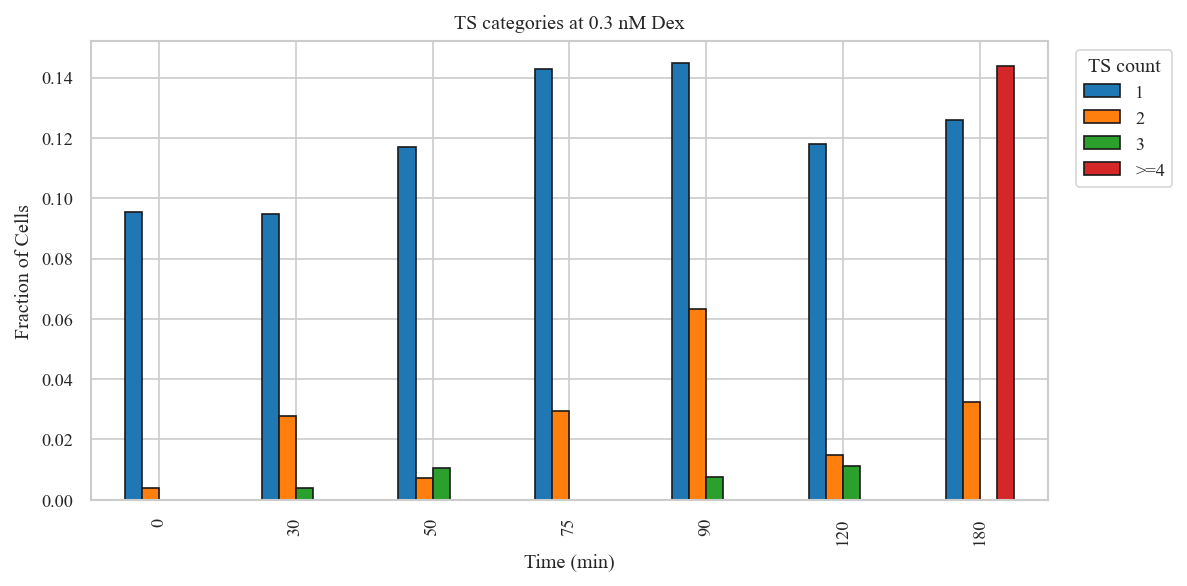

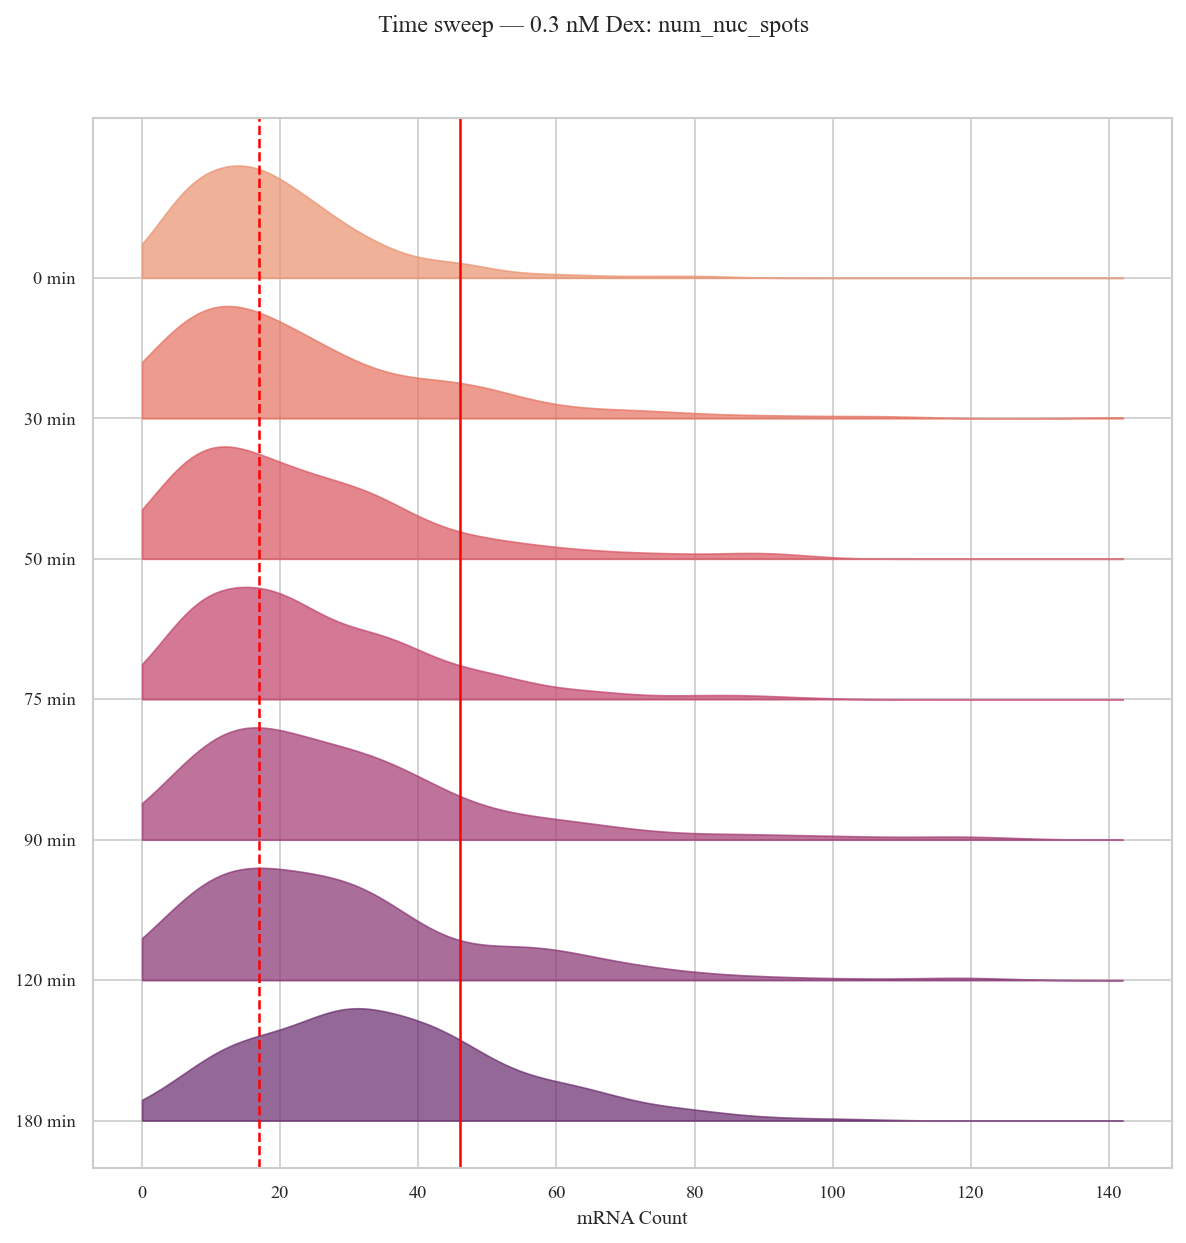

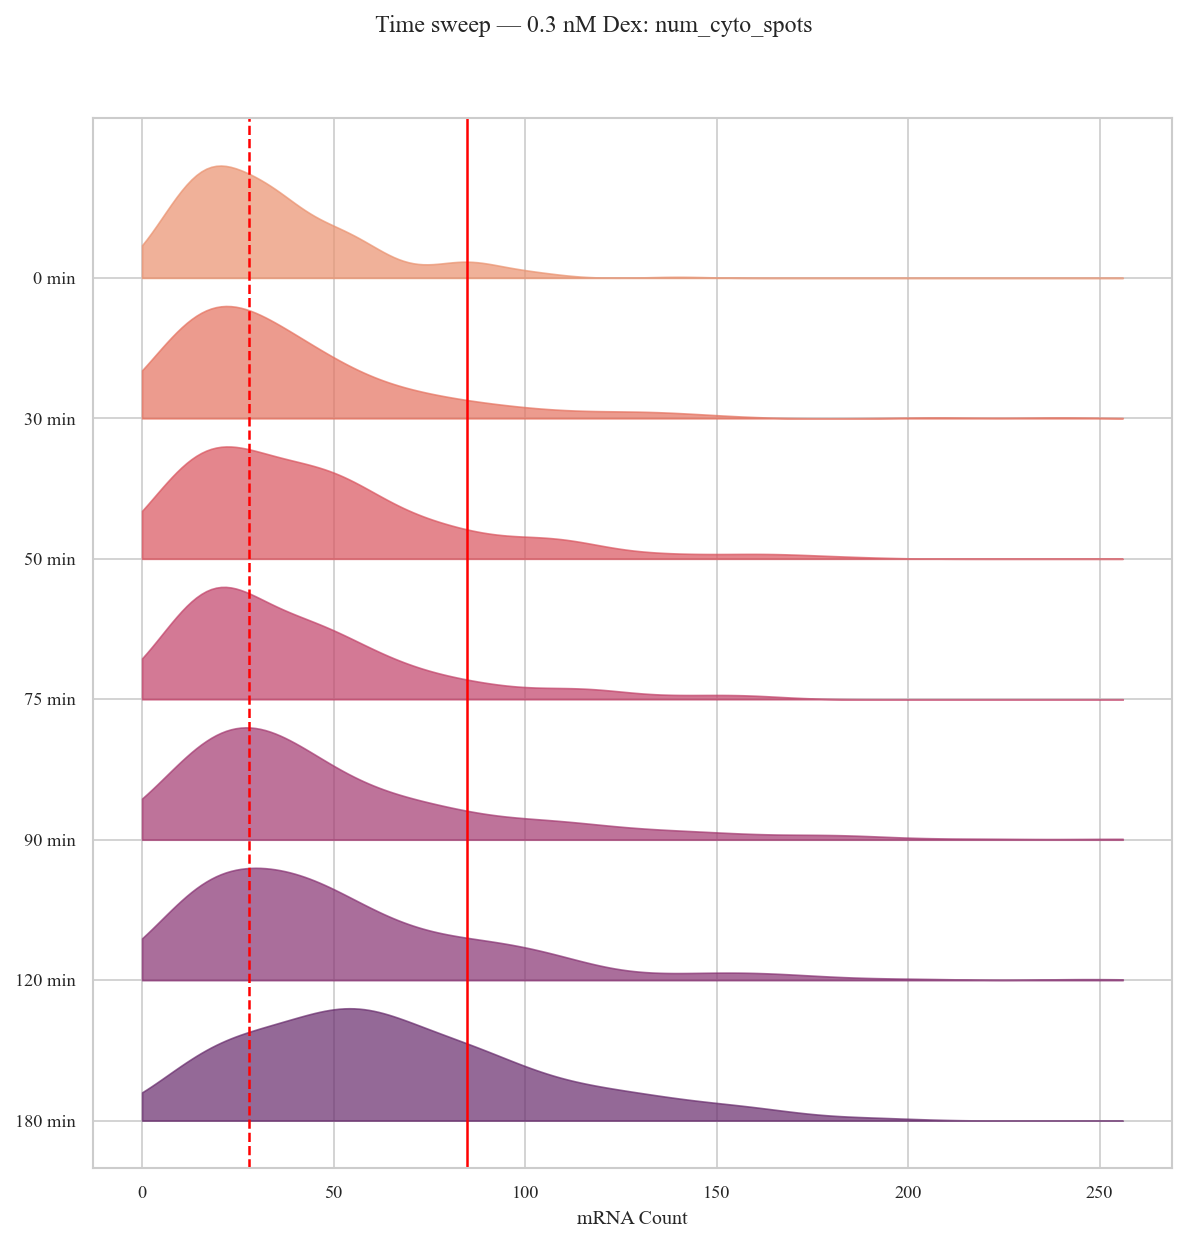

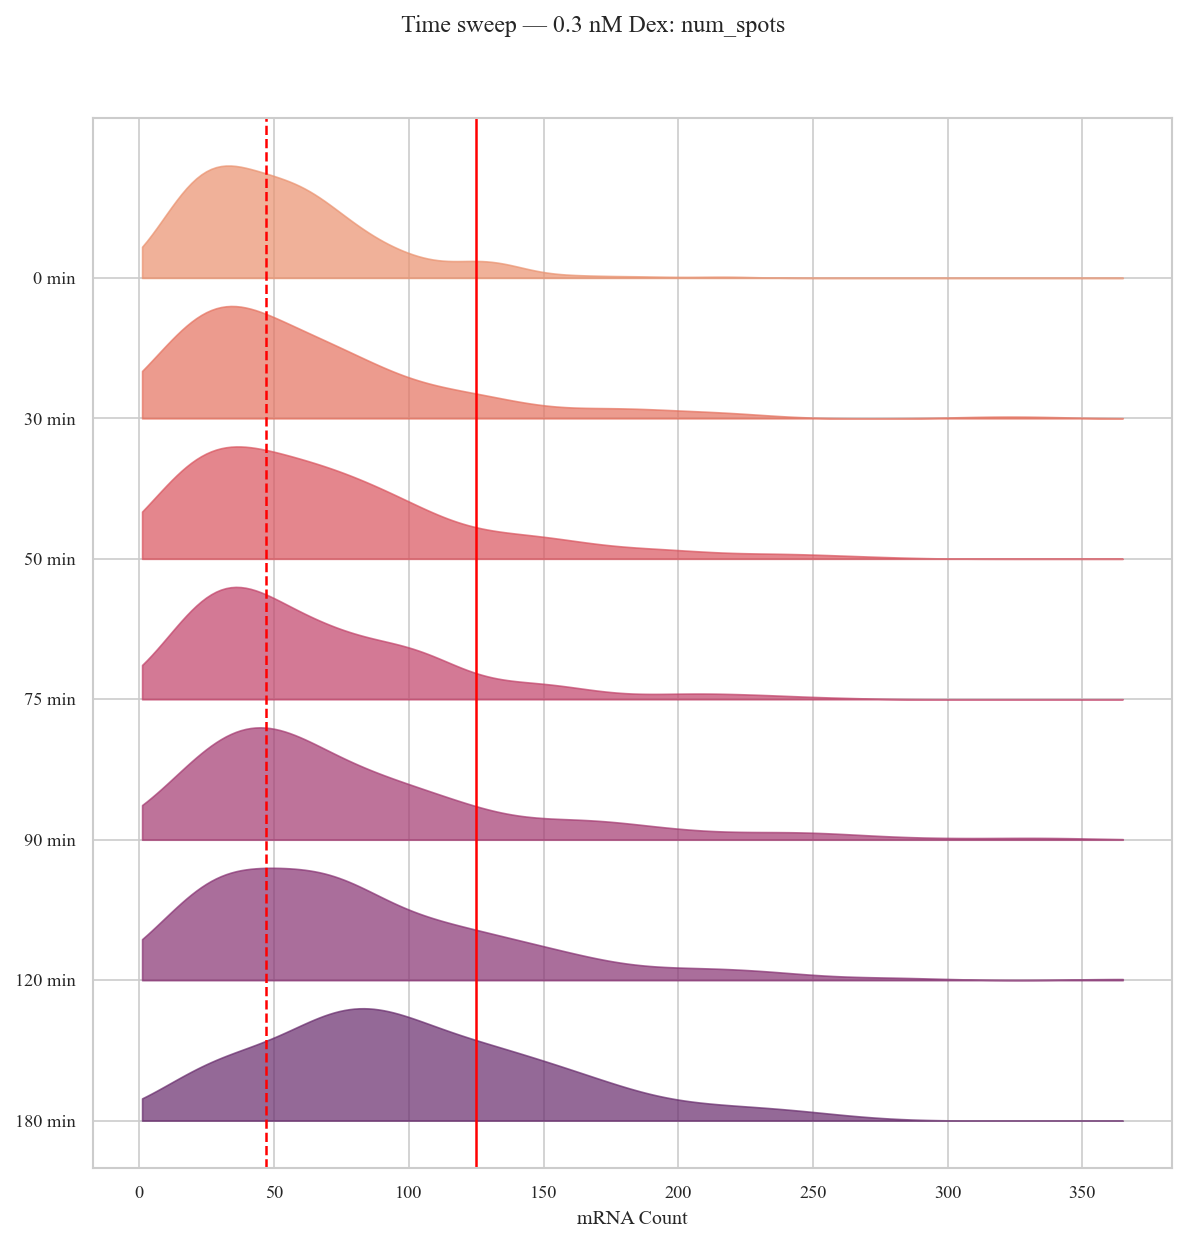

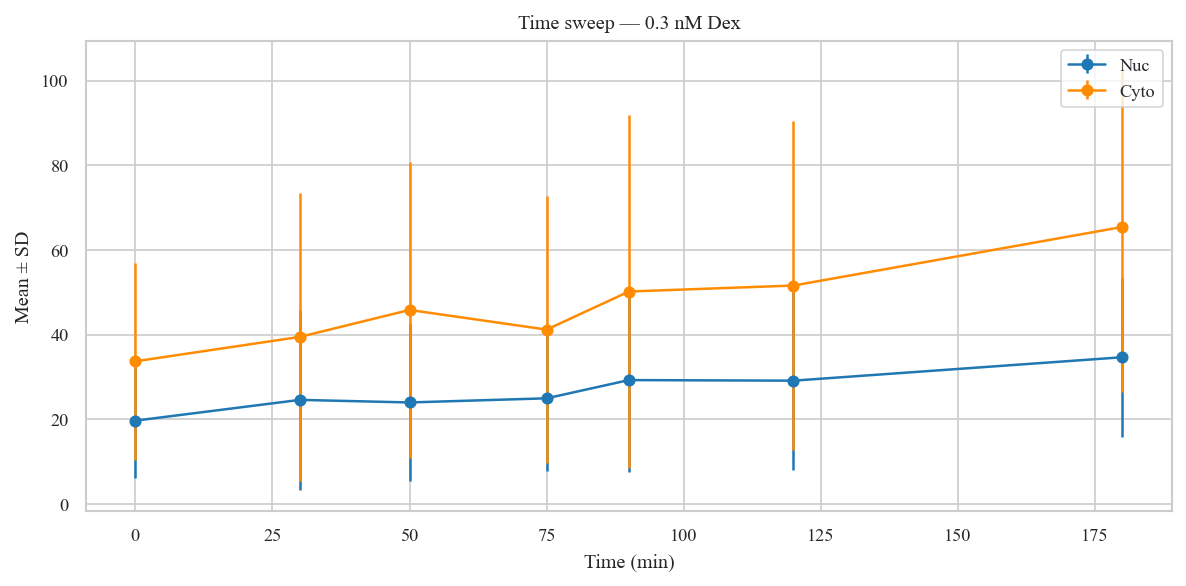


=== Time sweep for 1 nM Dex ===


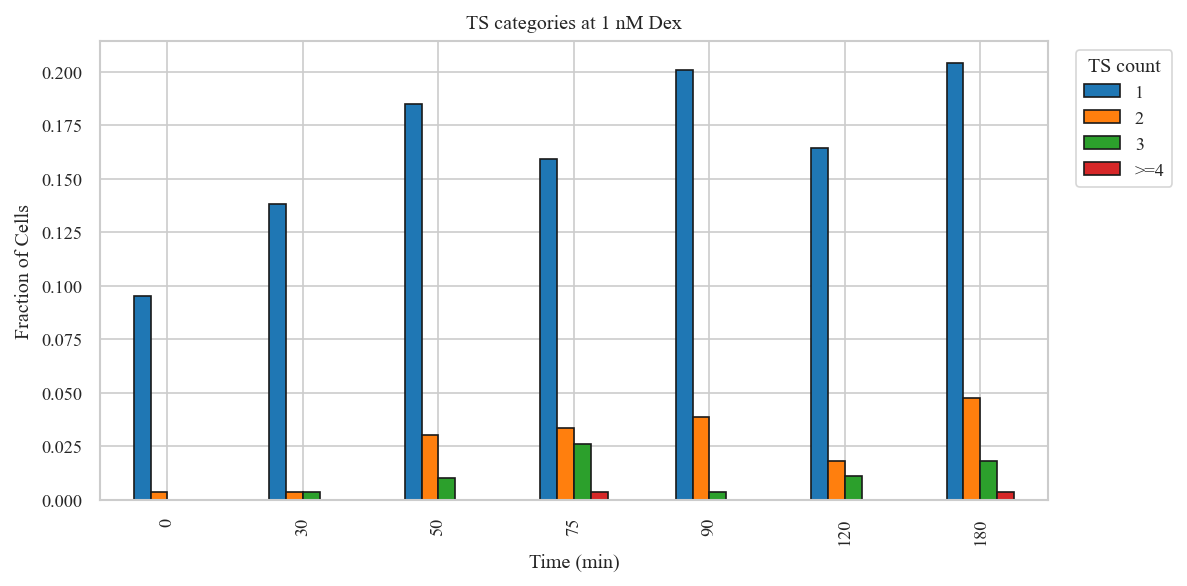

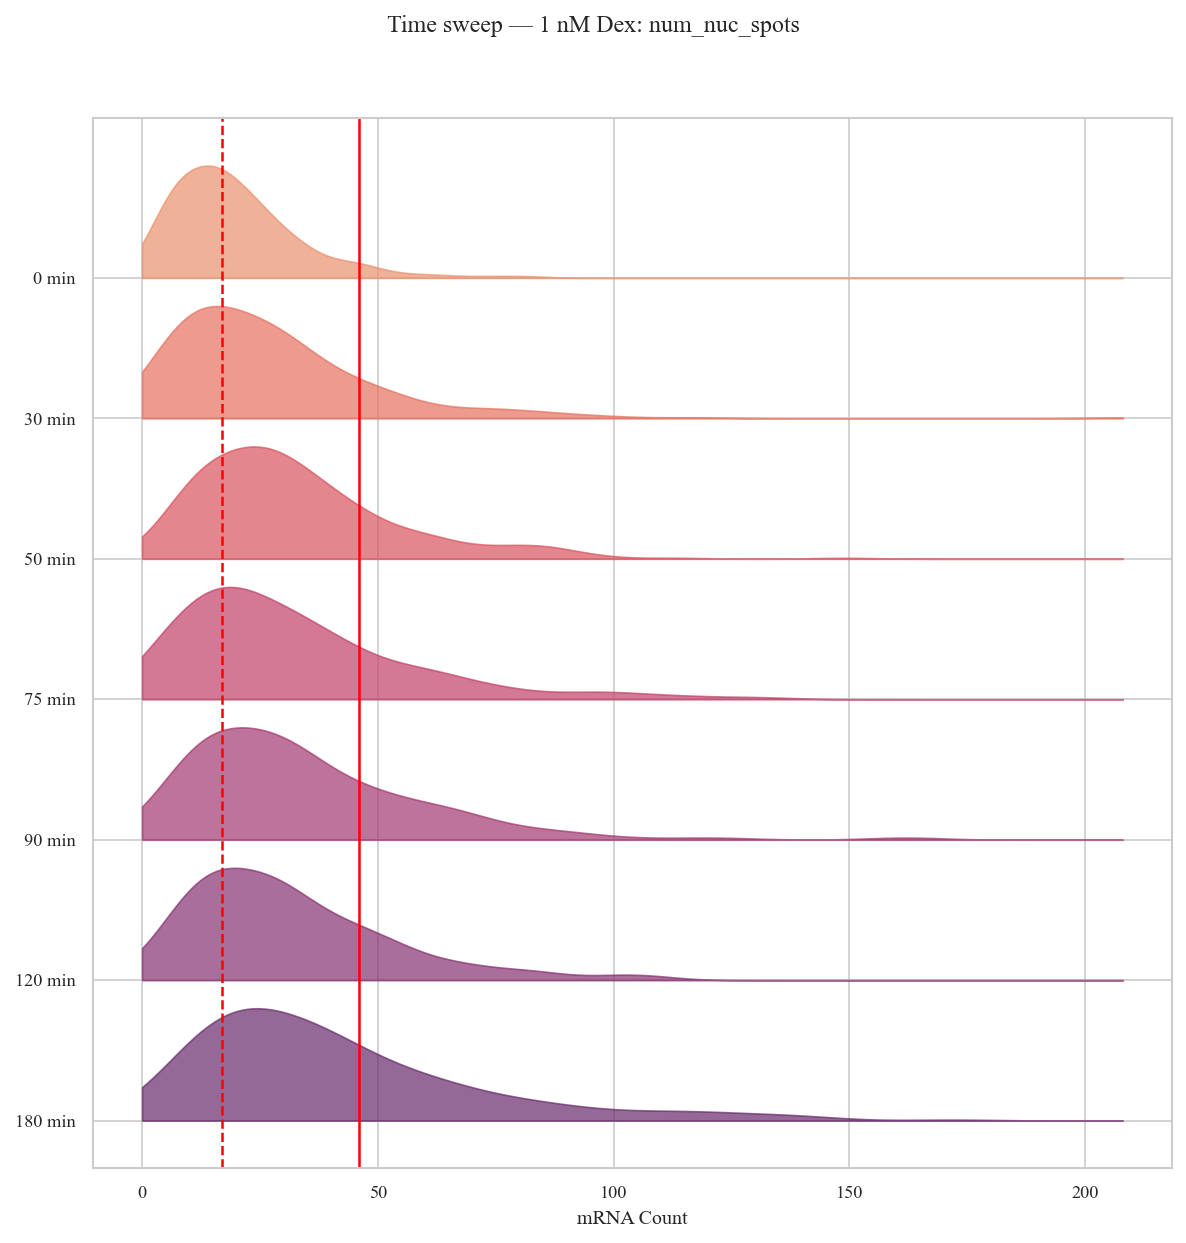

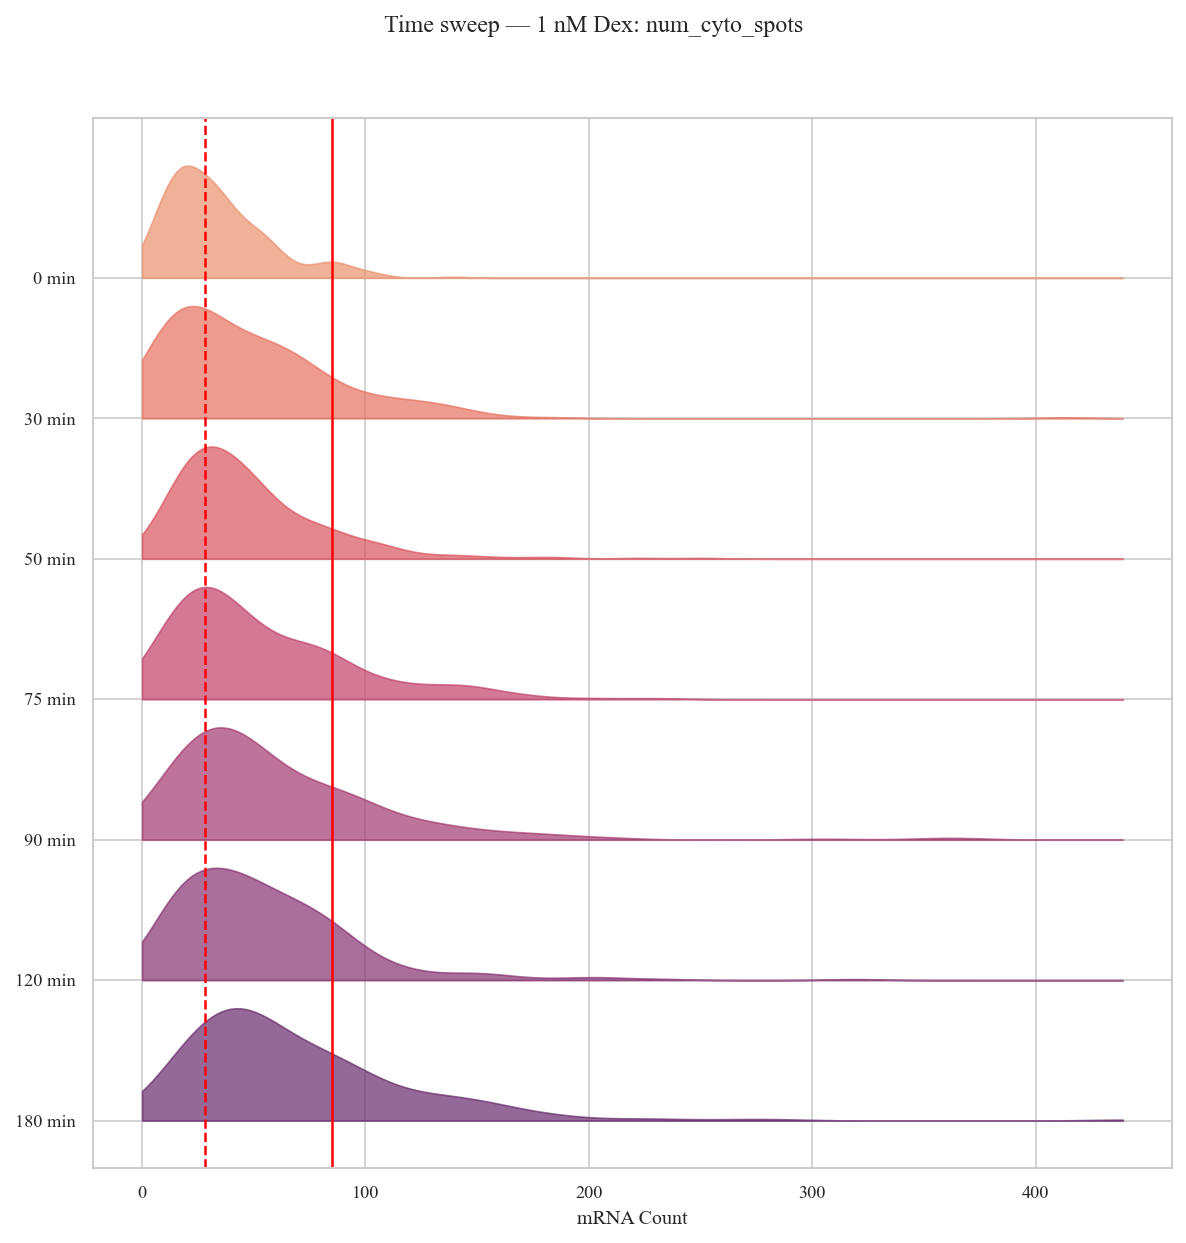

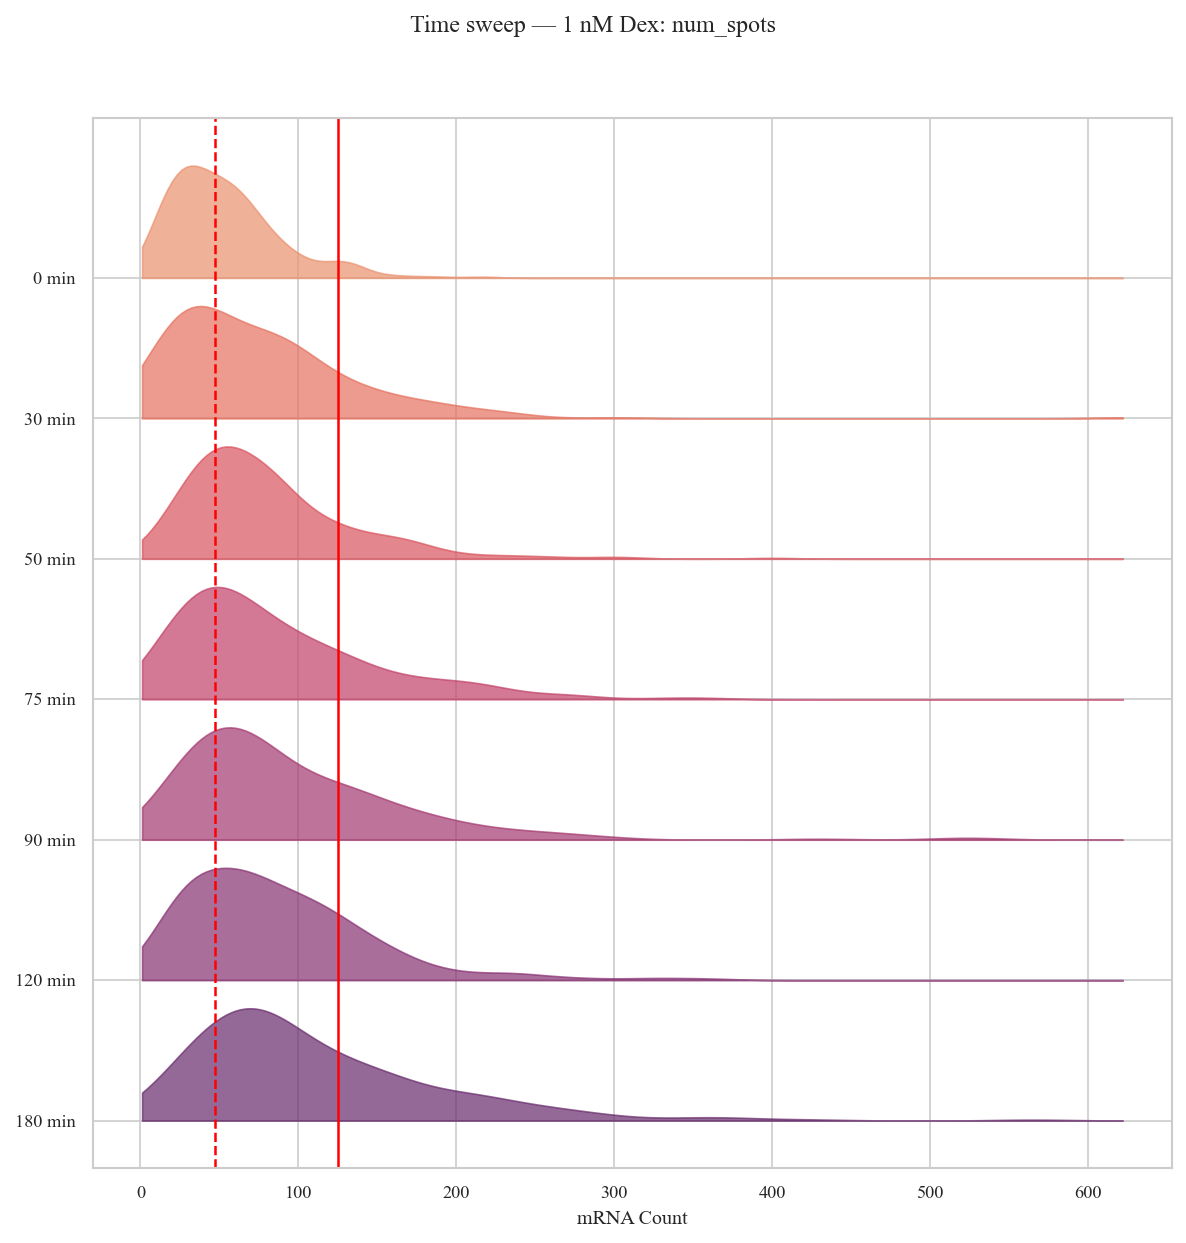

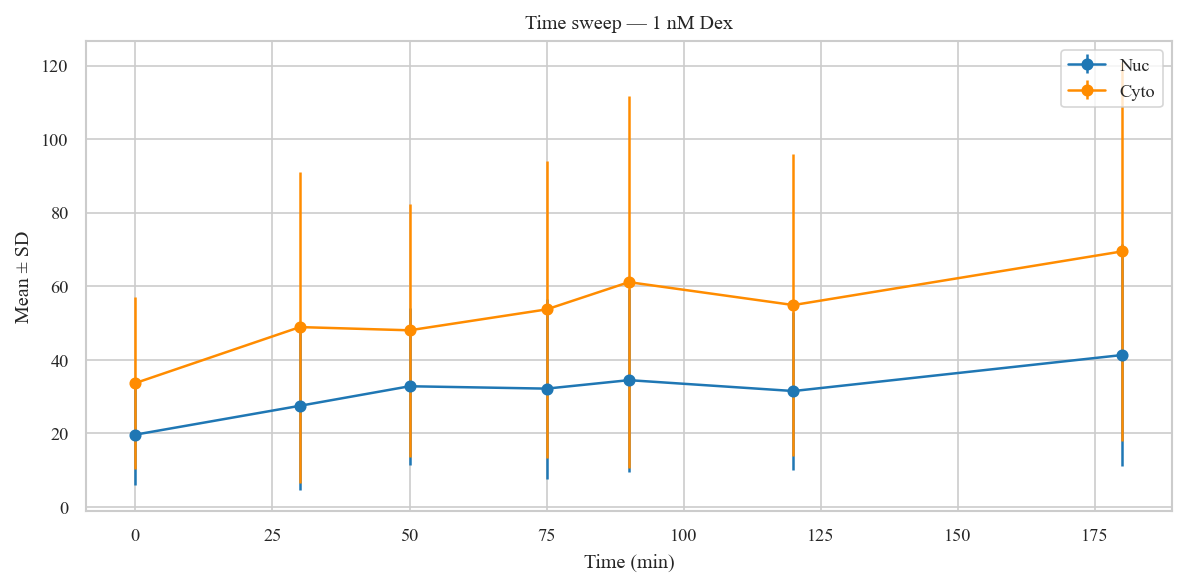


=== Time sweep for 10 nM Dex ===


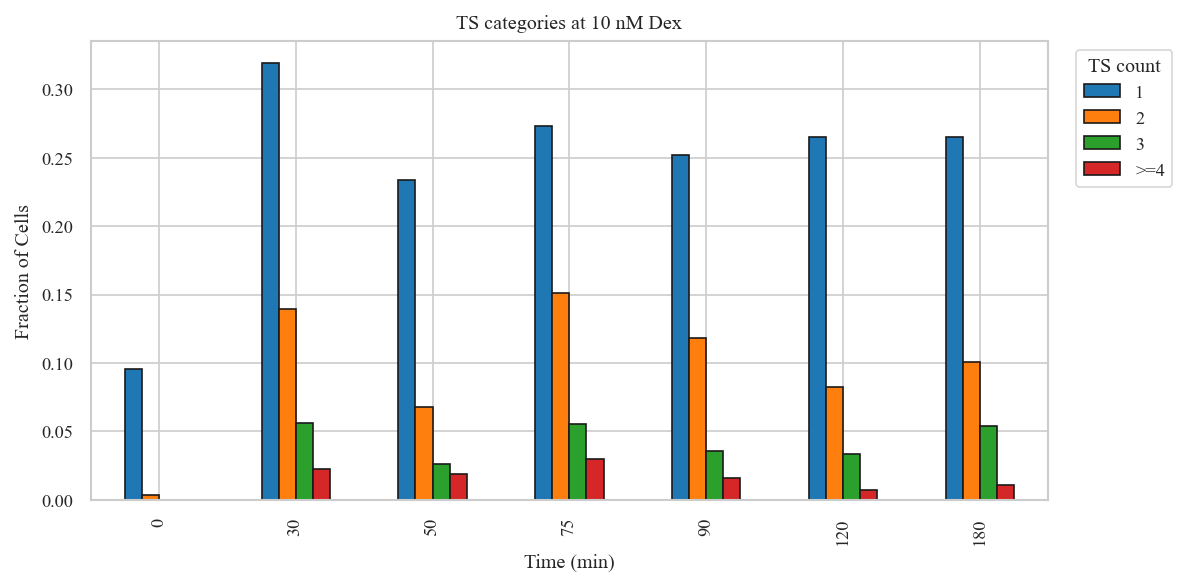

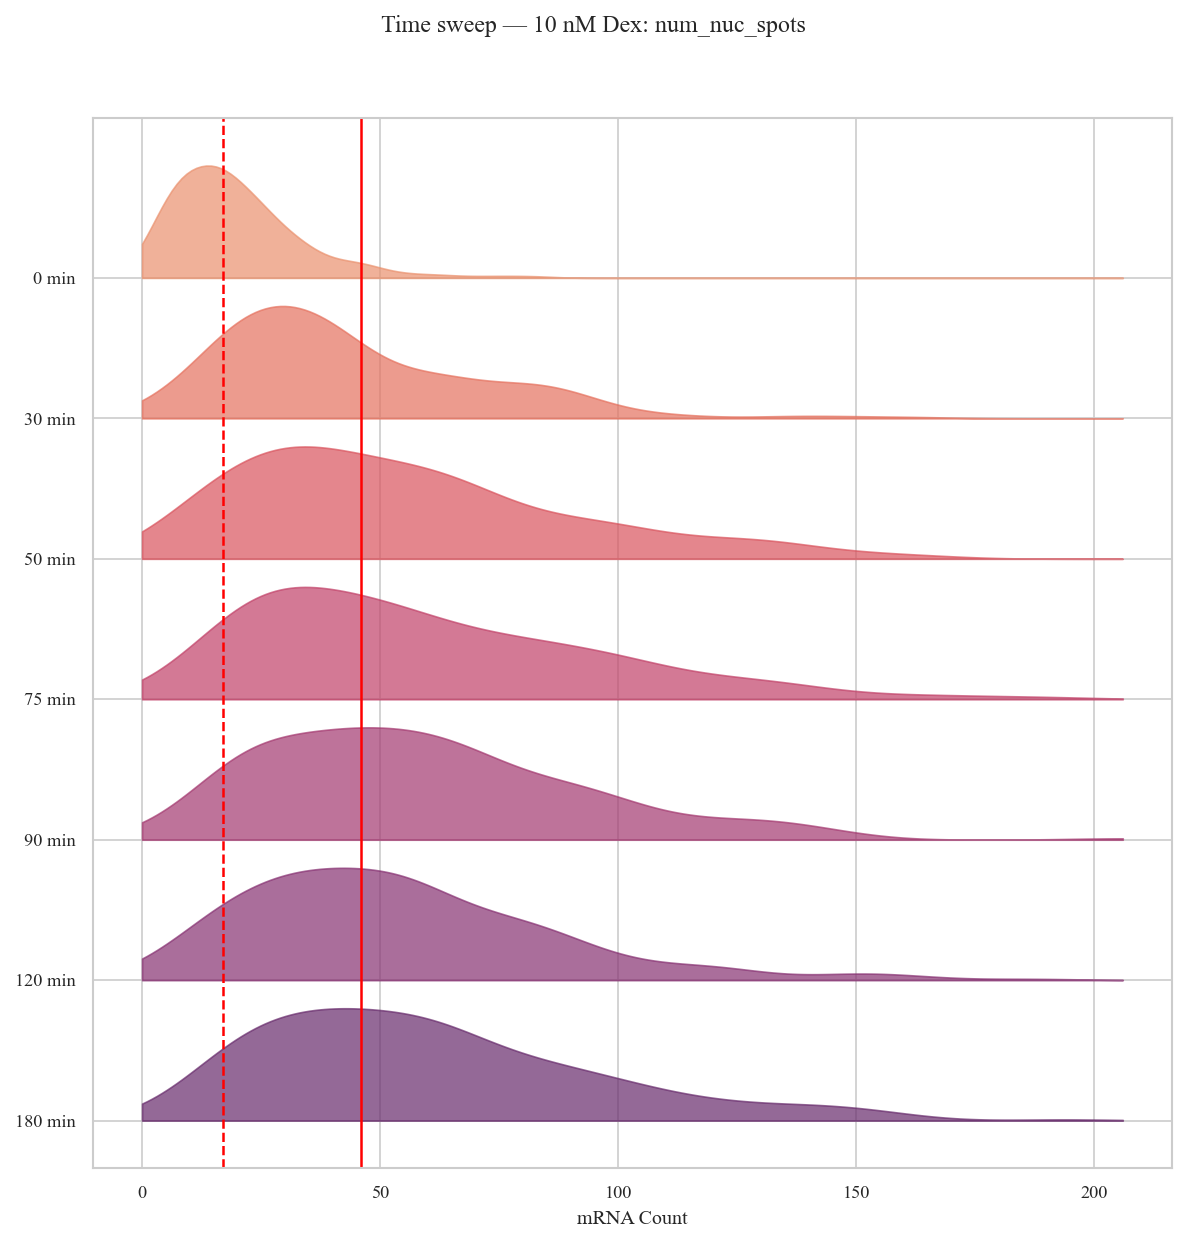

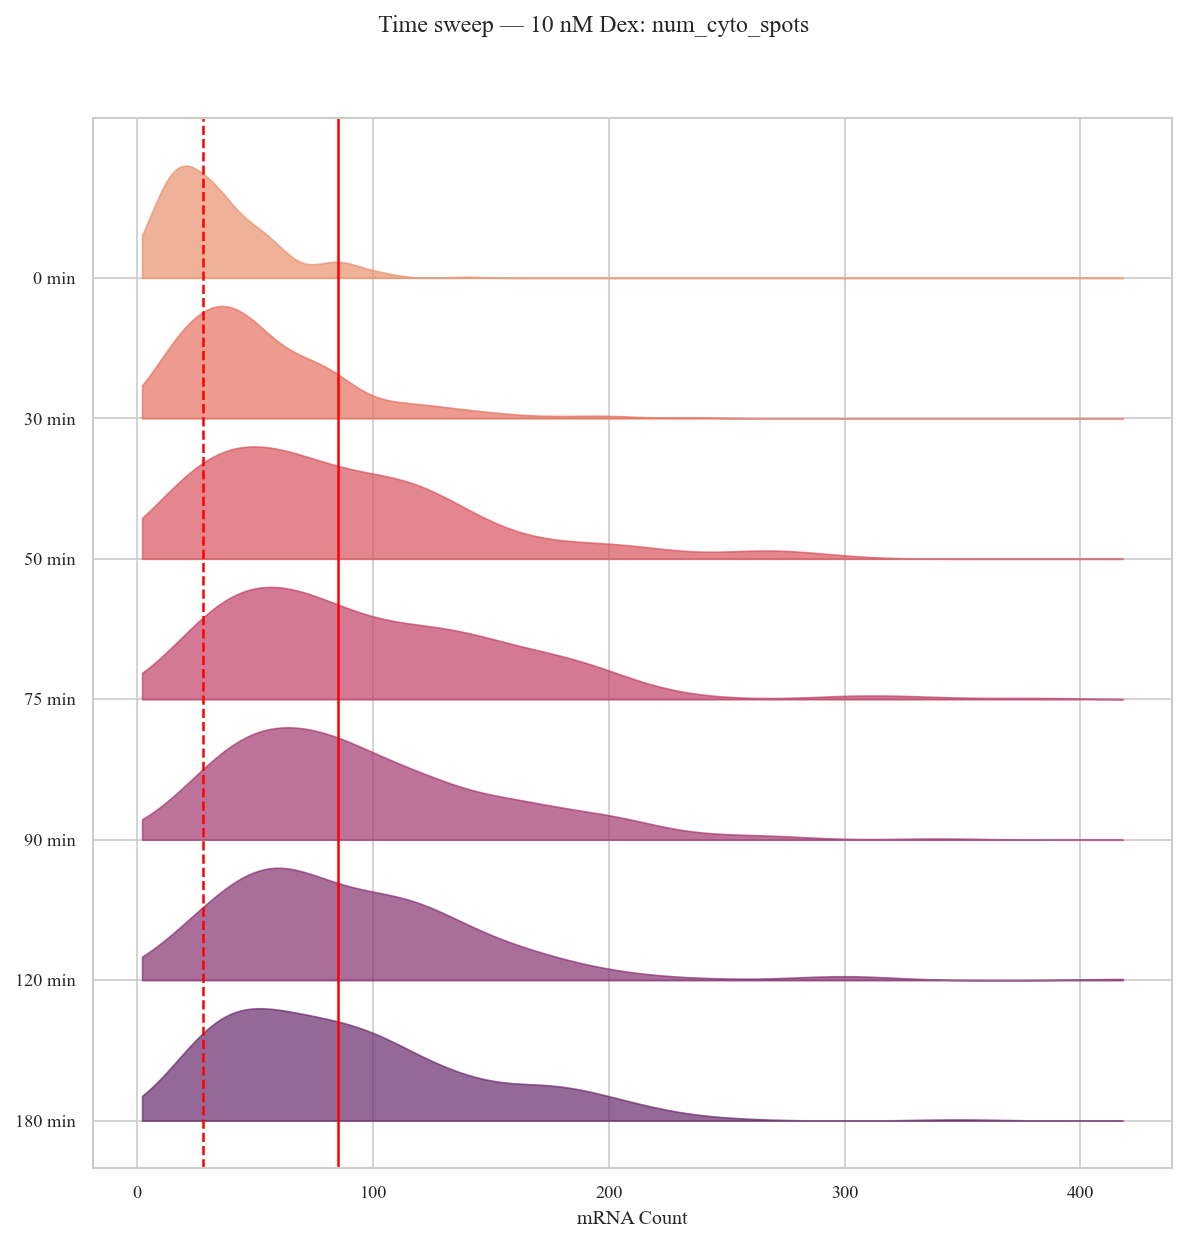

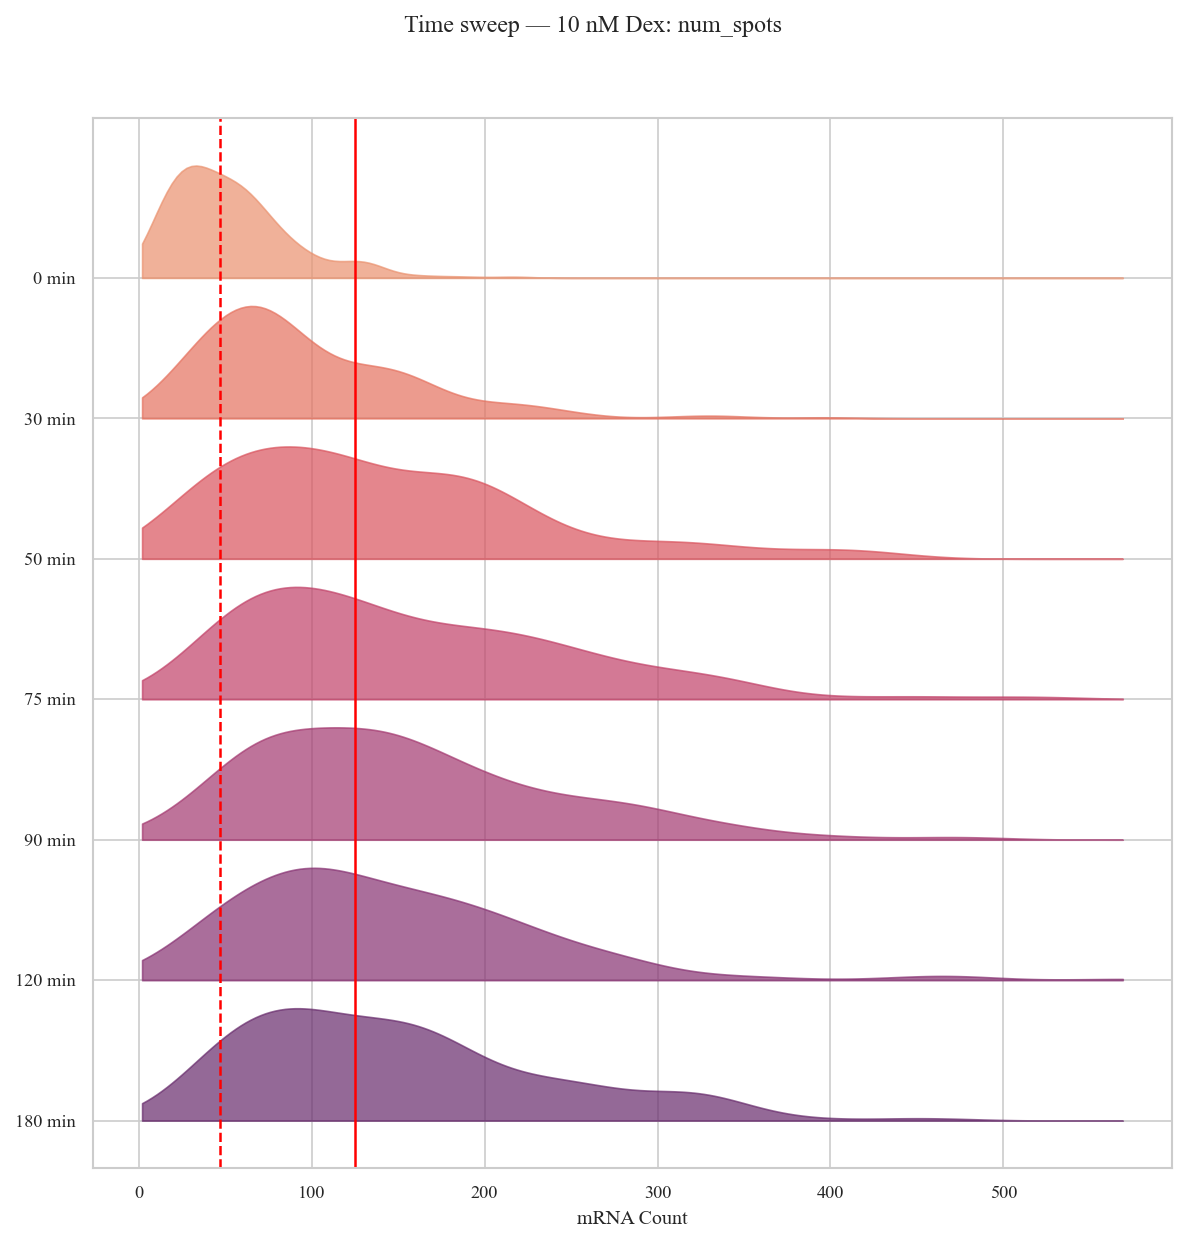

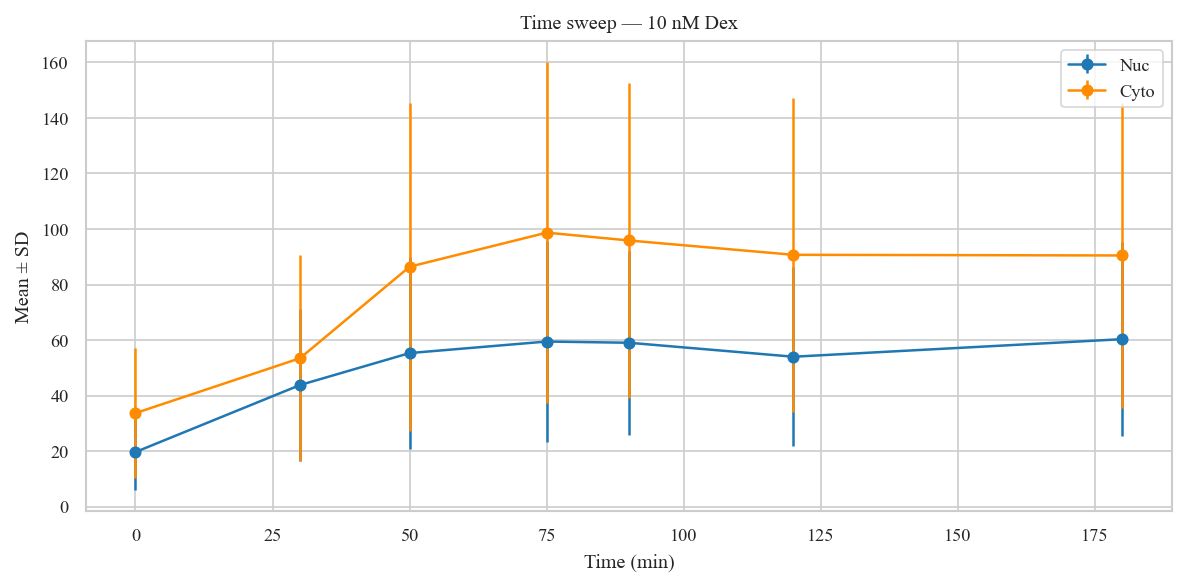

In [9]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_J_slide1_BFmean_061825',
    'DUSP1_J_slide2_BFmean_061825',
    'DUSP1_J_slide3_BFmean_061825',
    'DUSP1_J_slide4_BFmean_061825',
    'DUSP1_J_slide5_BFmean_061825',
    'DUSP1_J_slide6_BFmean_061825',
    'DUSP1_J_slide7_BFmean_061825',
    'DUSP1_J_slide8_BFmean_061825',
    'DUSP1_J_slide9_BFmean_061825',
    'DUSP1_J_slide10_BFmean_061825',
    'DUSP1_J_slide11_BFmean_061825',
    'DUSP1_J_slide12_BFmean_061825',
    'DUSP1_J_slide13_BFmean_061825',
    'DUSP1_J_slide14_BFmean_061825',
    'DUSP1_J_slide15_BFmean_061825',
    'DUSP1_J_slide16_BFmean_061825',
    'DUSP1_J_slide17_BFmean_061825',
    'DUSP1_J_slide18_BFmean_061825',
    'DUSP1_J_slide19_BFmean_061825',        
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) apply your unique‐ID prefix logic ─────────────────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 60
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

# spots
max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

# clusters
max_cluster_id   = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix   = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) filtering ─────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)

filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post-filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_J_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

# Time + concentration sweeps for [0.3, 1, 10] nM Dex
print("\n>>> Time+Conc sweeps for [0.3, 1, 10] nM Dex")
plotter.plot_time_conc_sweep(
    conc_list=[0.3, 1, 10],
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica K 3hr time-concentration sweep R2 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_0min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_0min_041223.h5 -> Analysis_DUSP1_K_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_30min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_30min_041223.h5 -> Analysis_DUSP1_K_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_50min_041223.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_300pM_50min_041223.h5 -> Analysis_DUSP1_K_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230413/DUSP1_DexTimeConcSweep_30

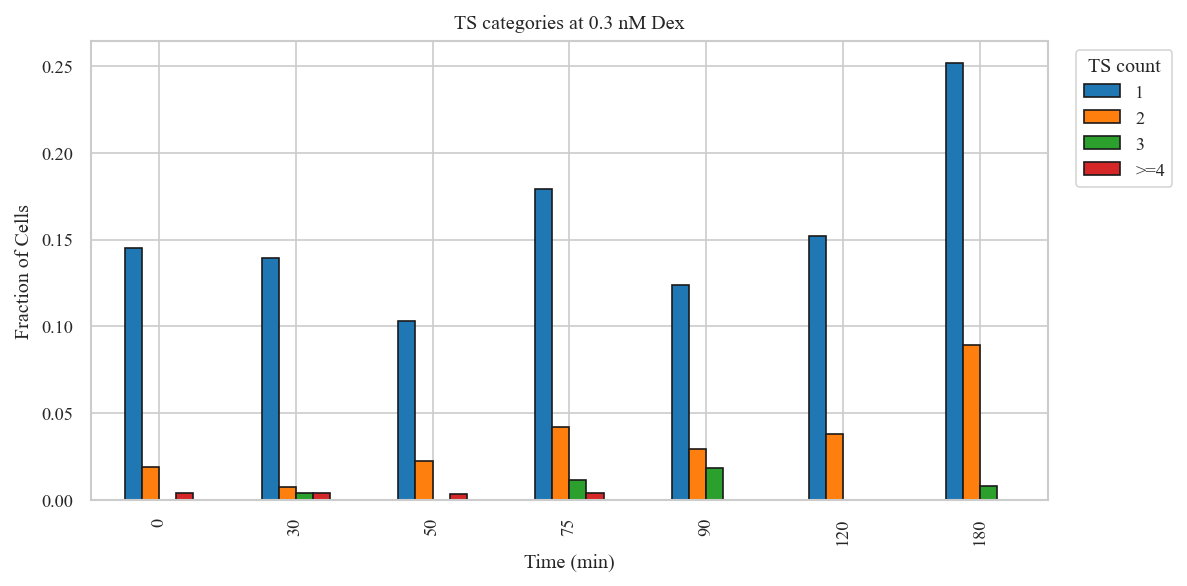

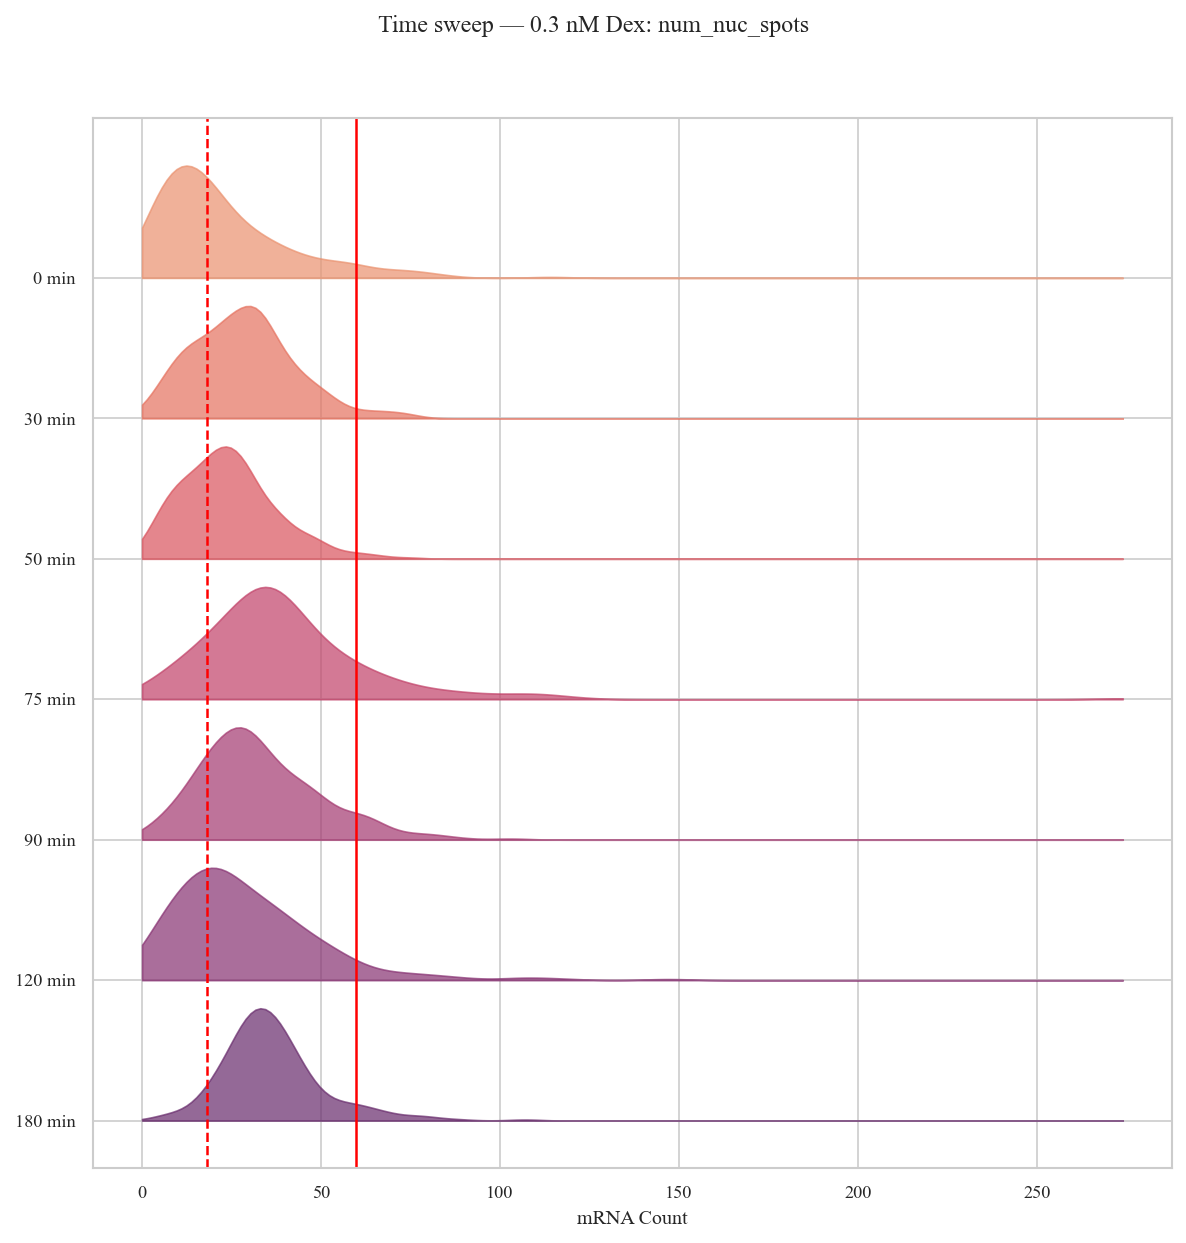

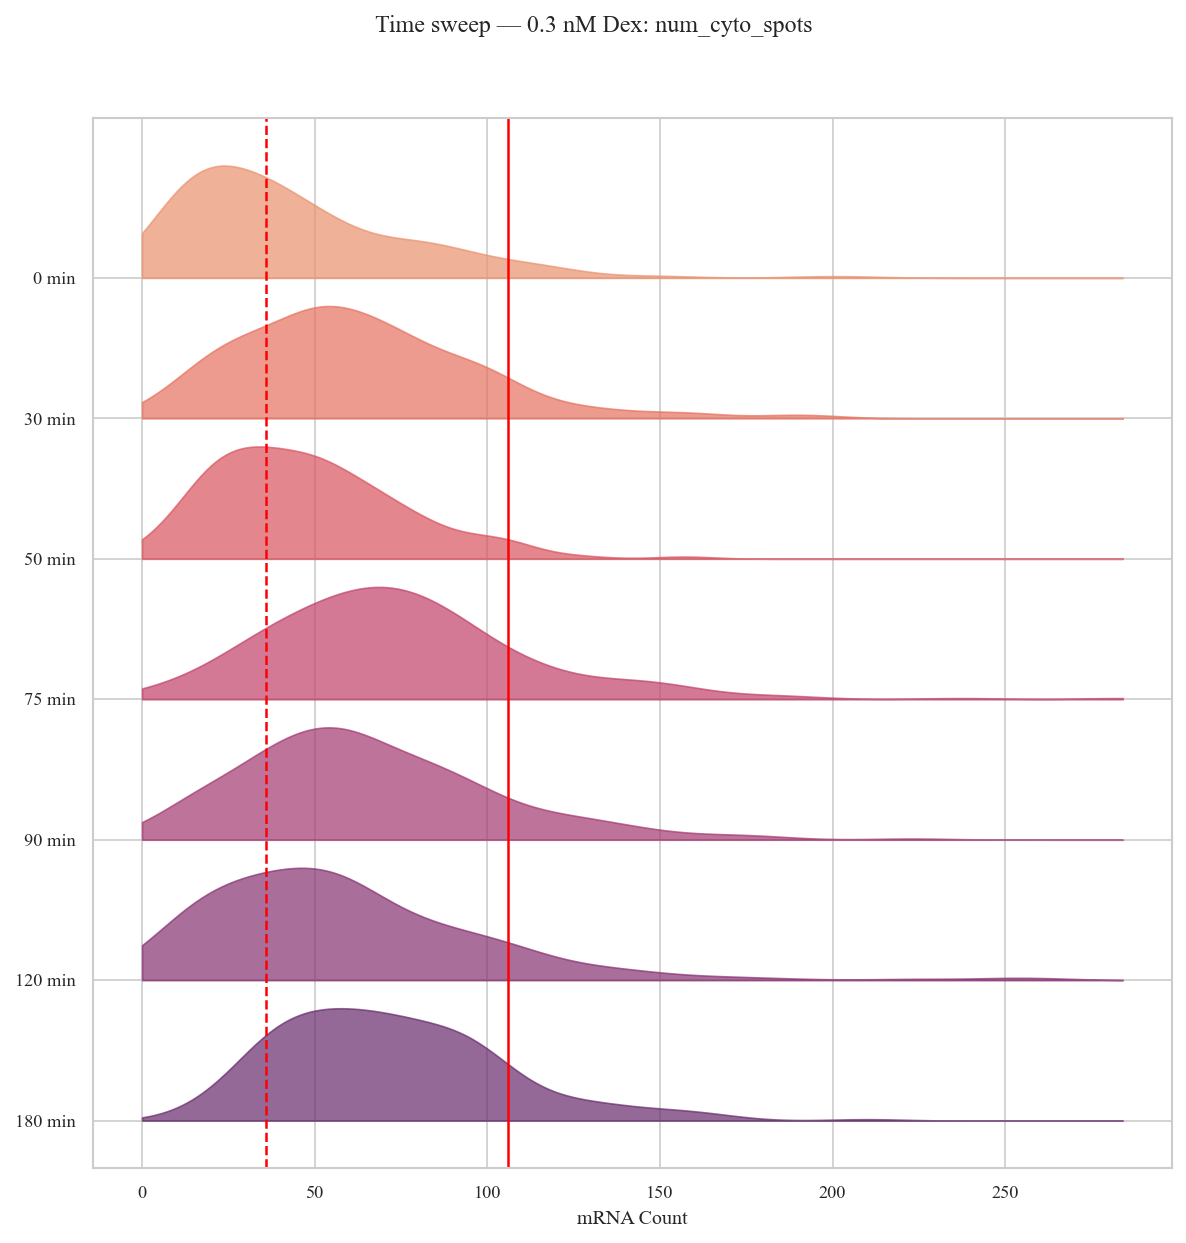

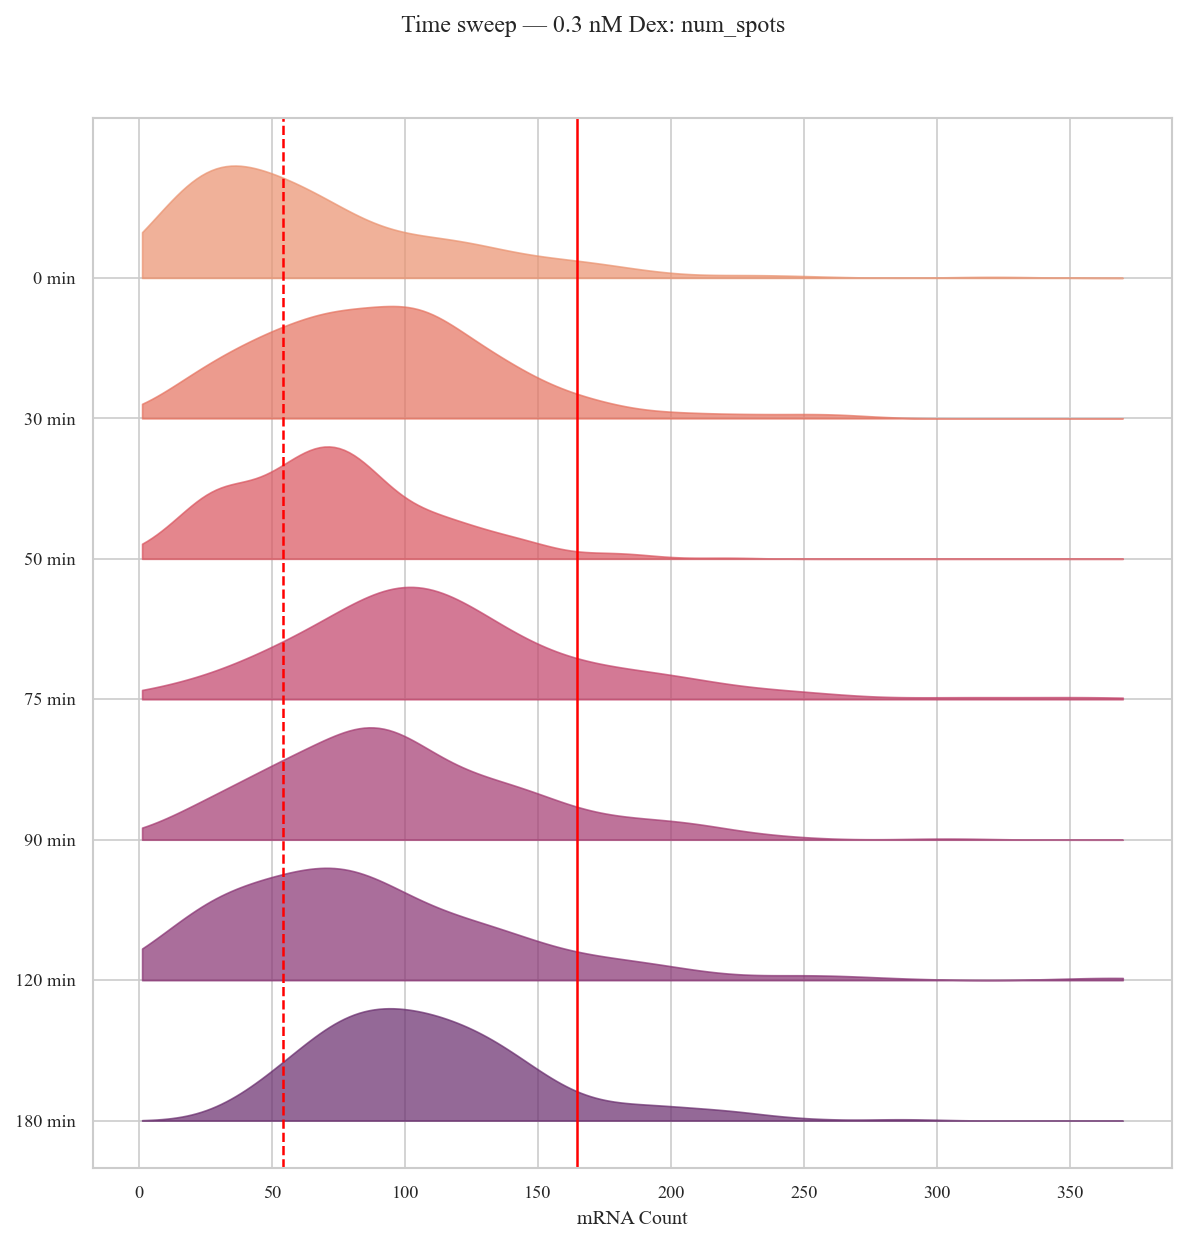

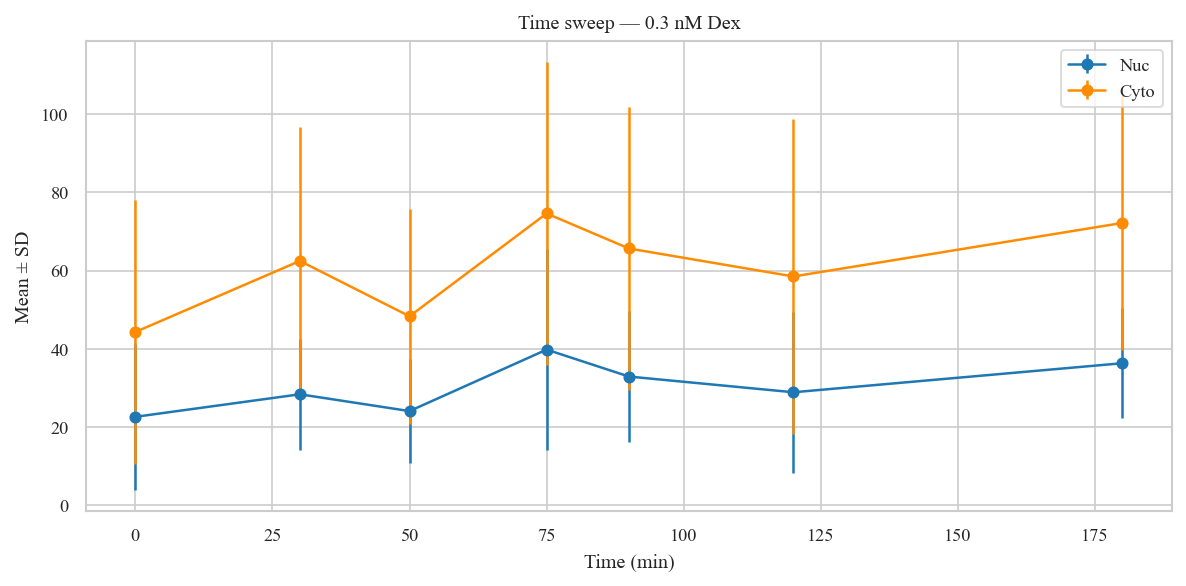


=== Time sweep for 1 nM Dex ===


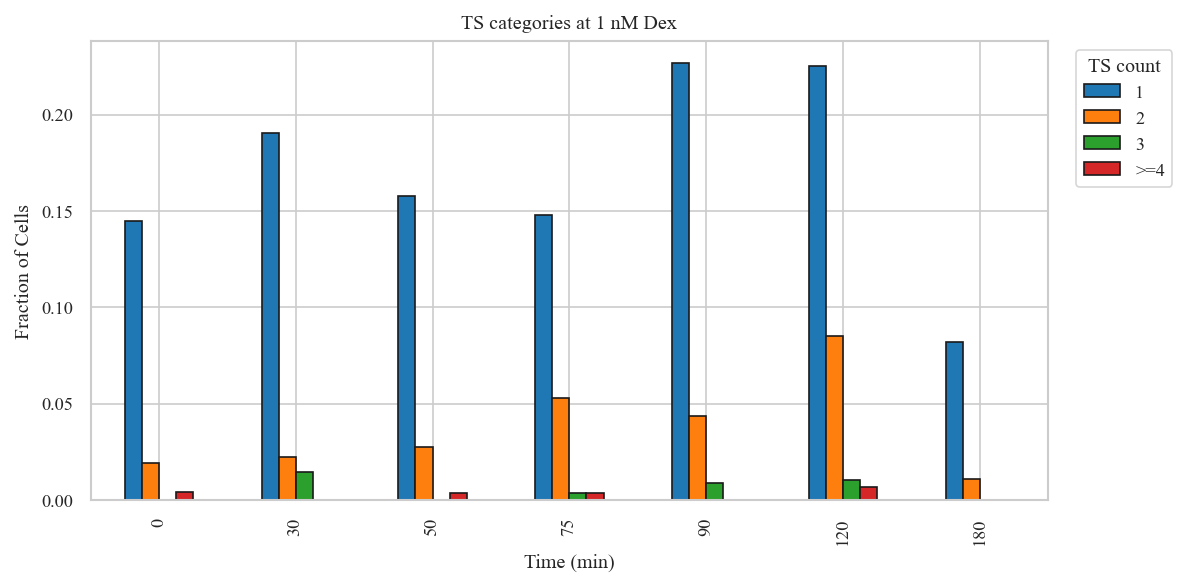

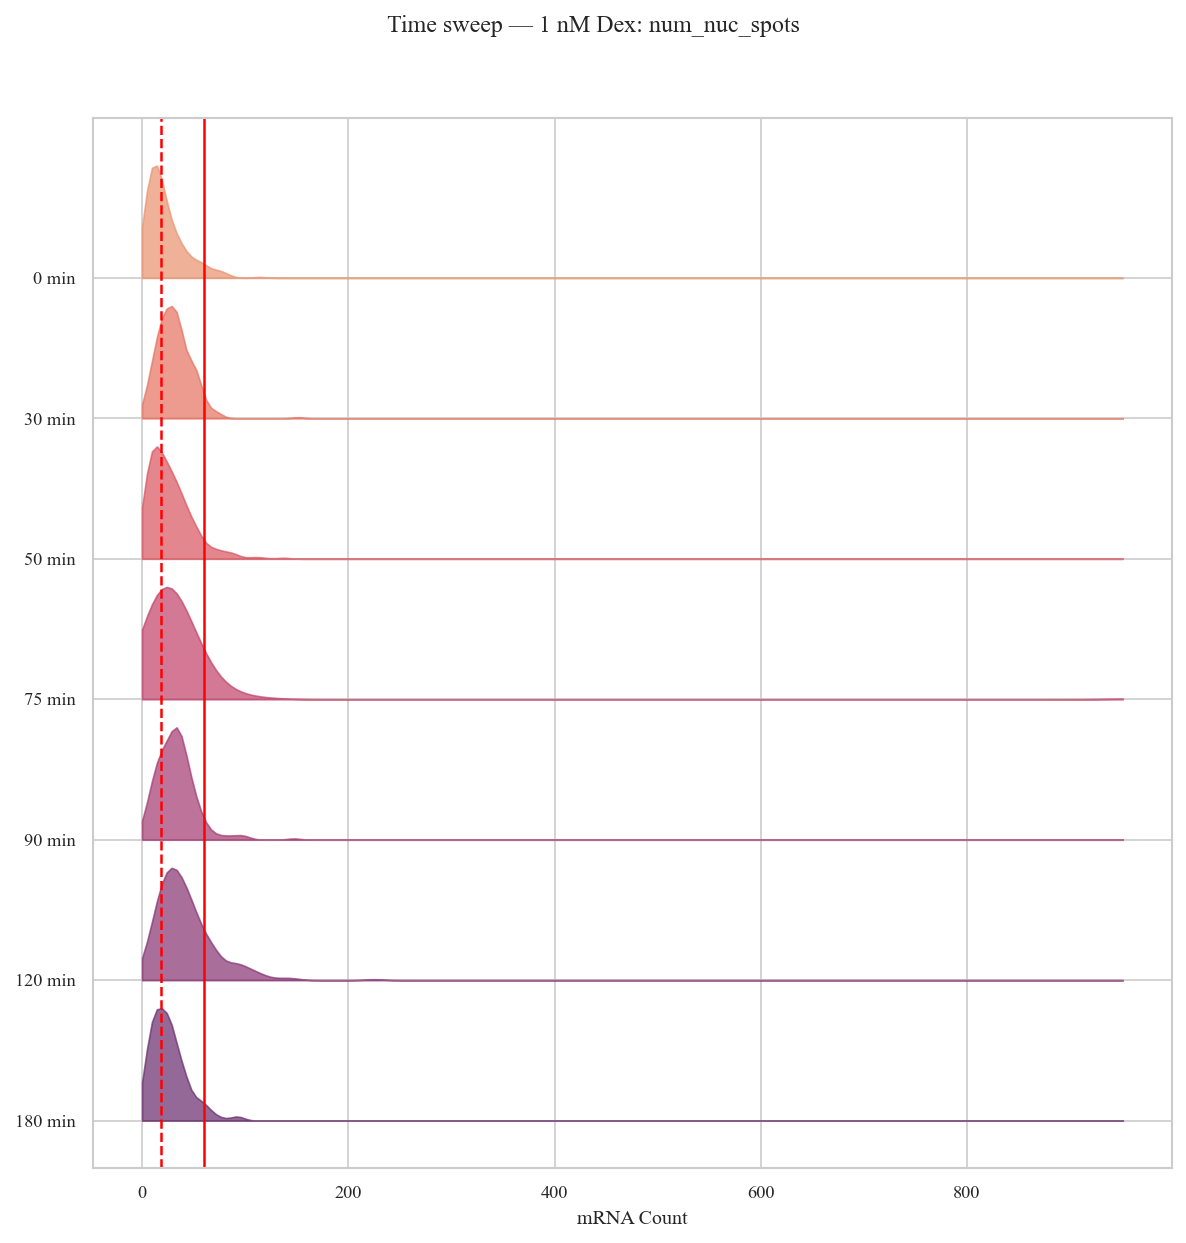

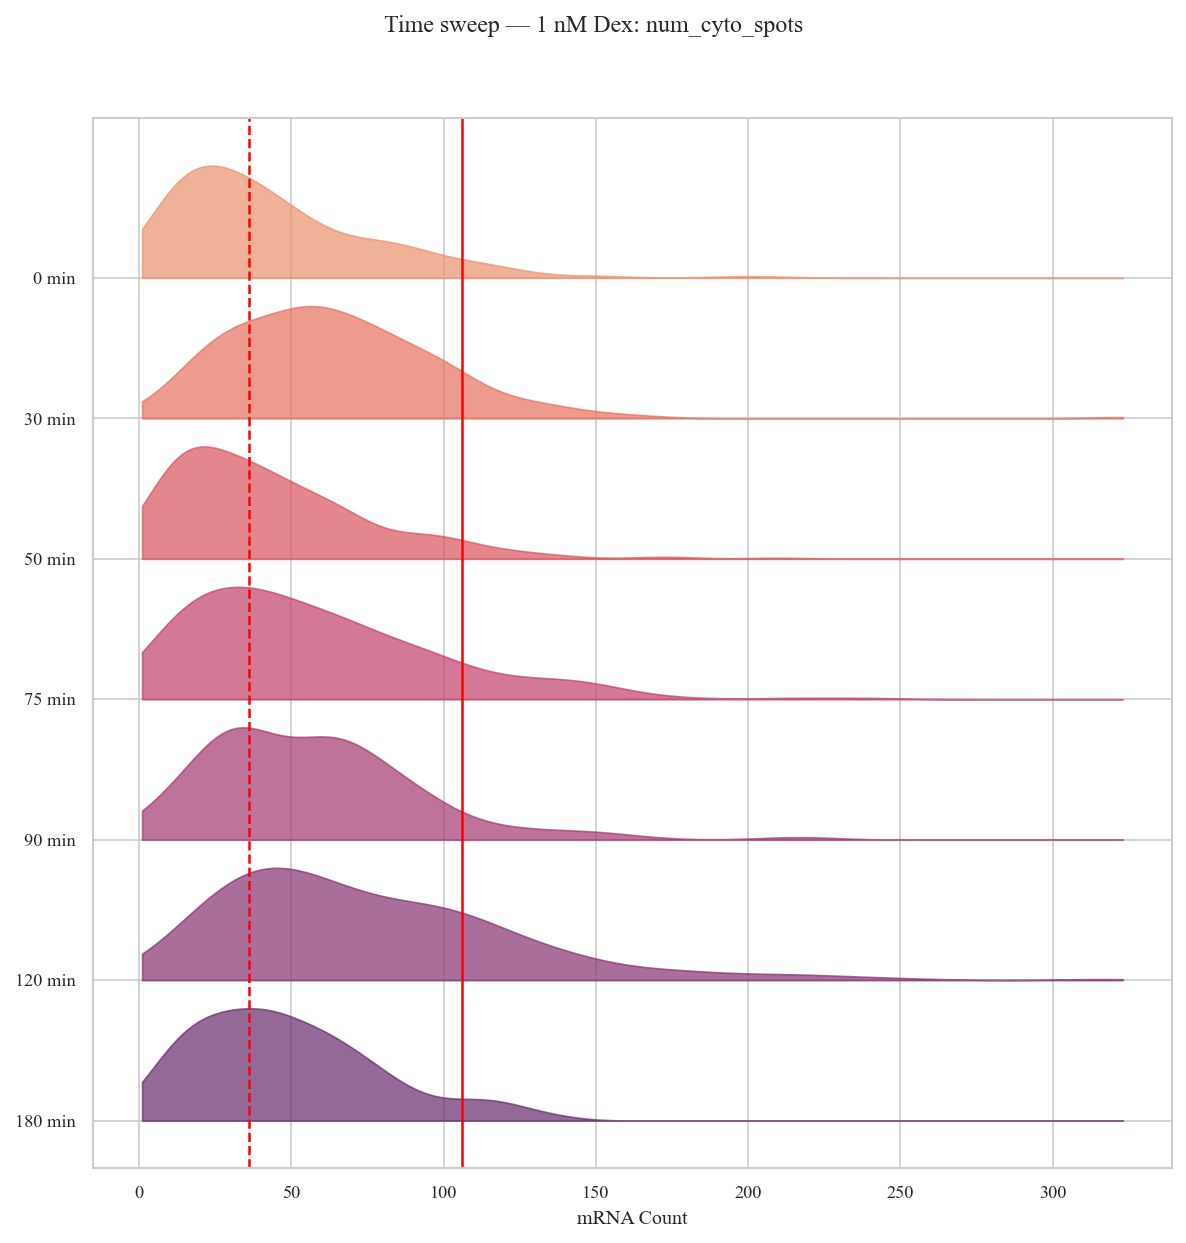

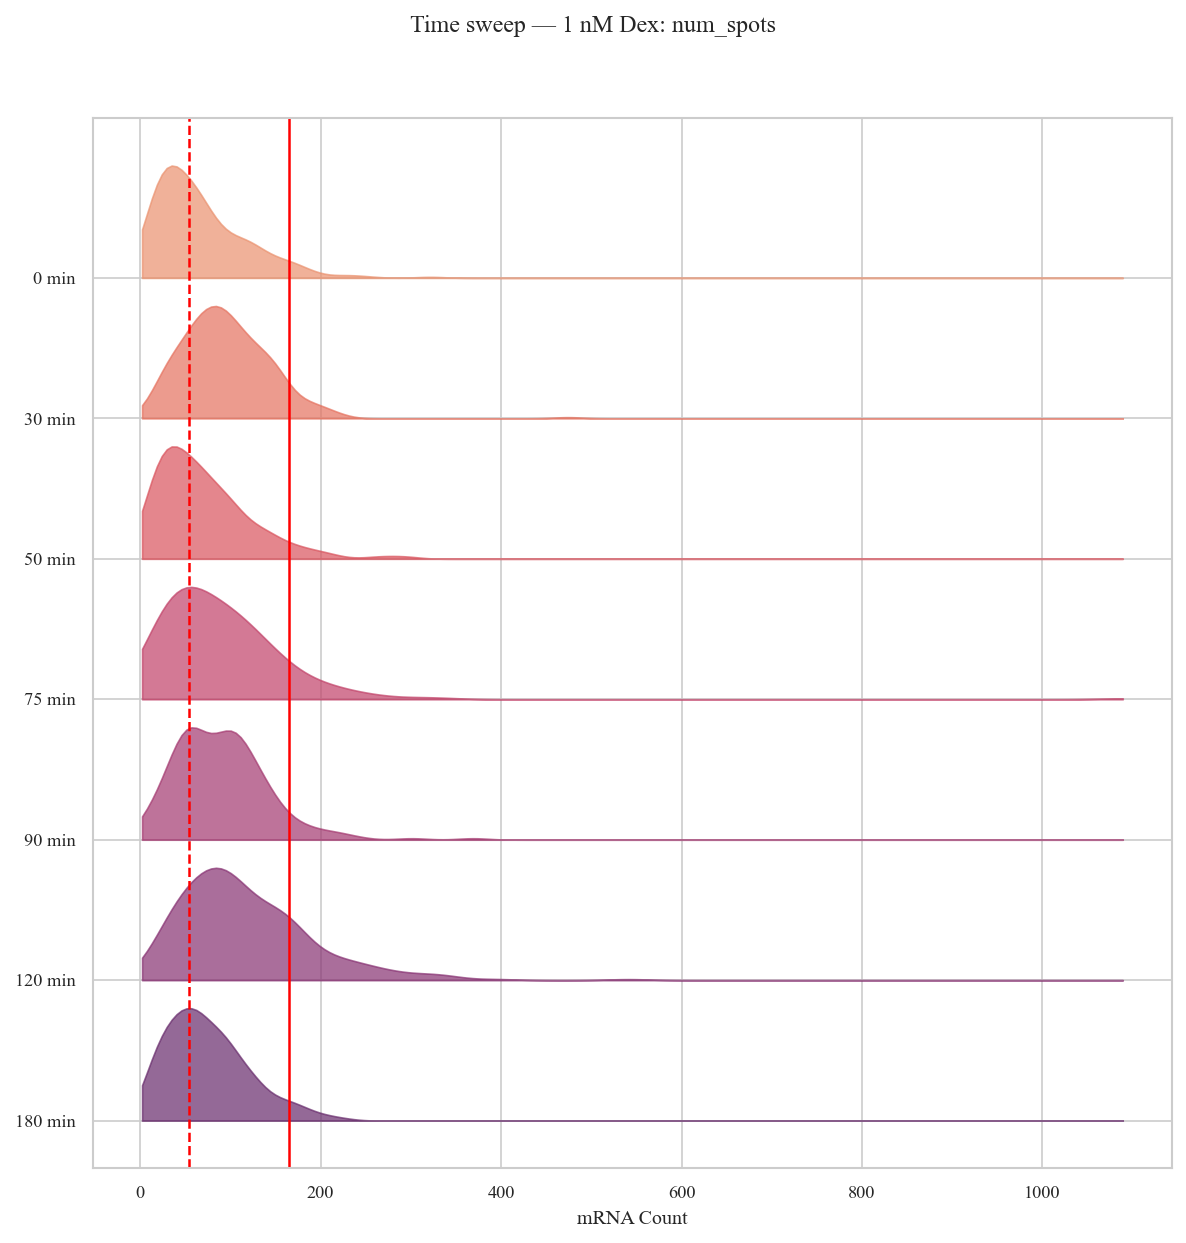

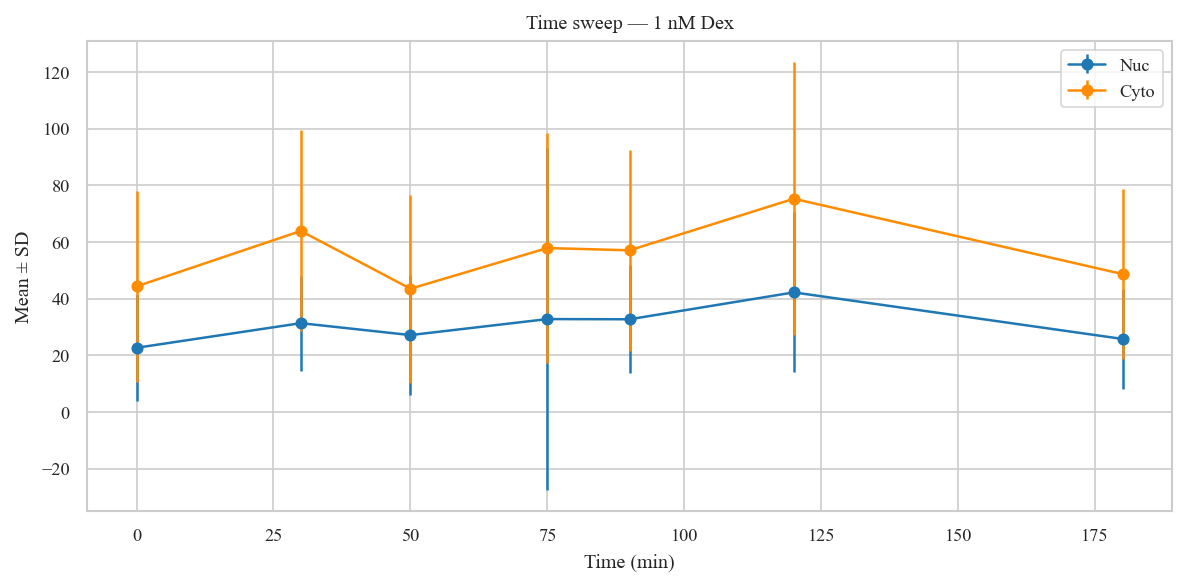


=== Time sweep for 10 nM Dex ===


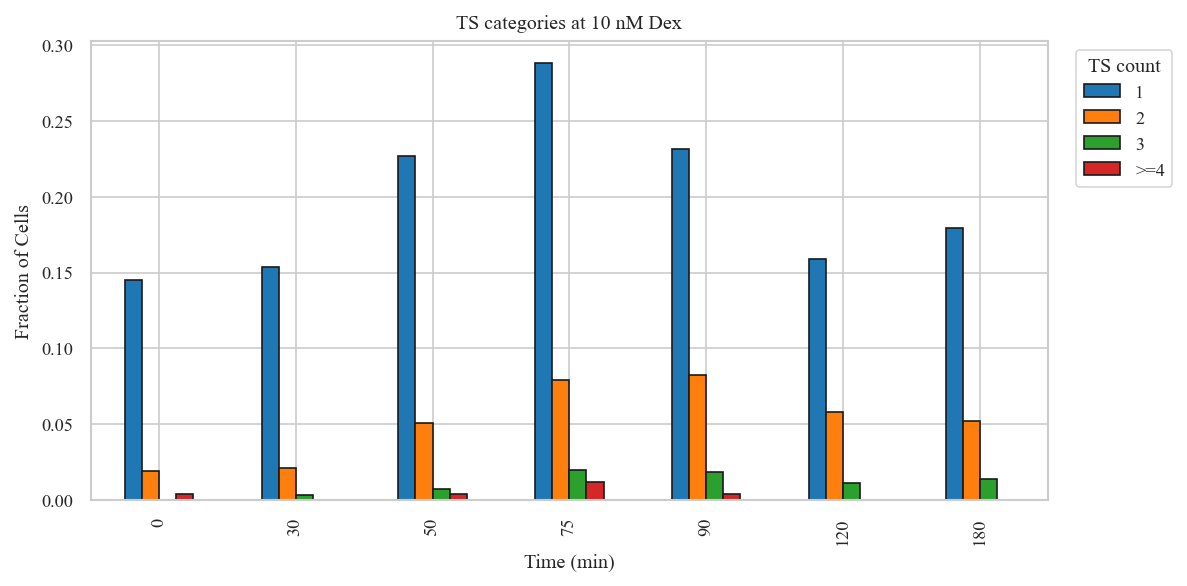

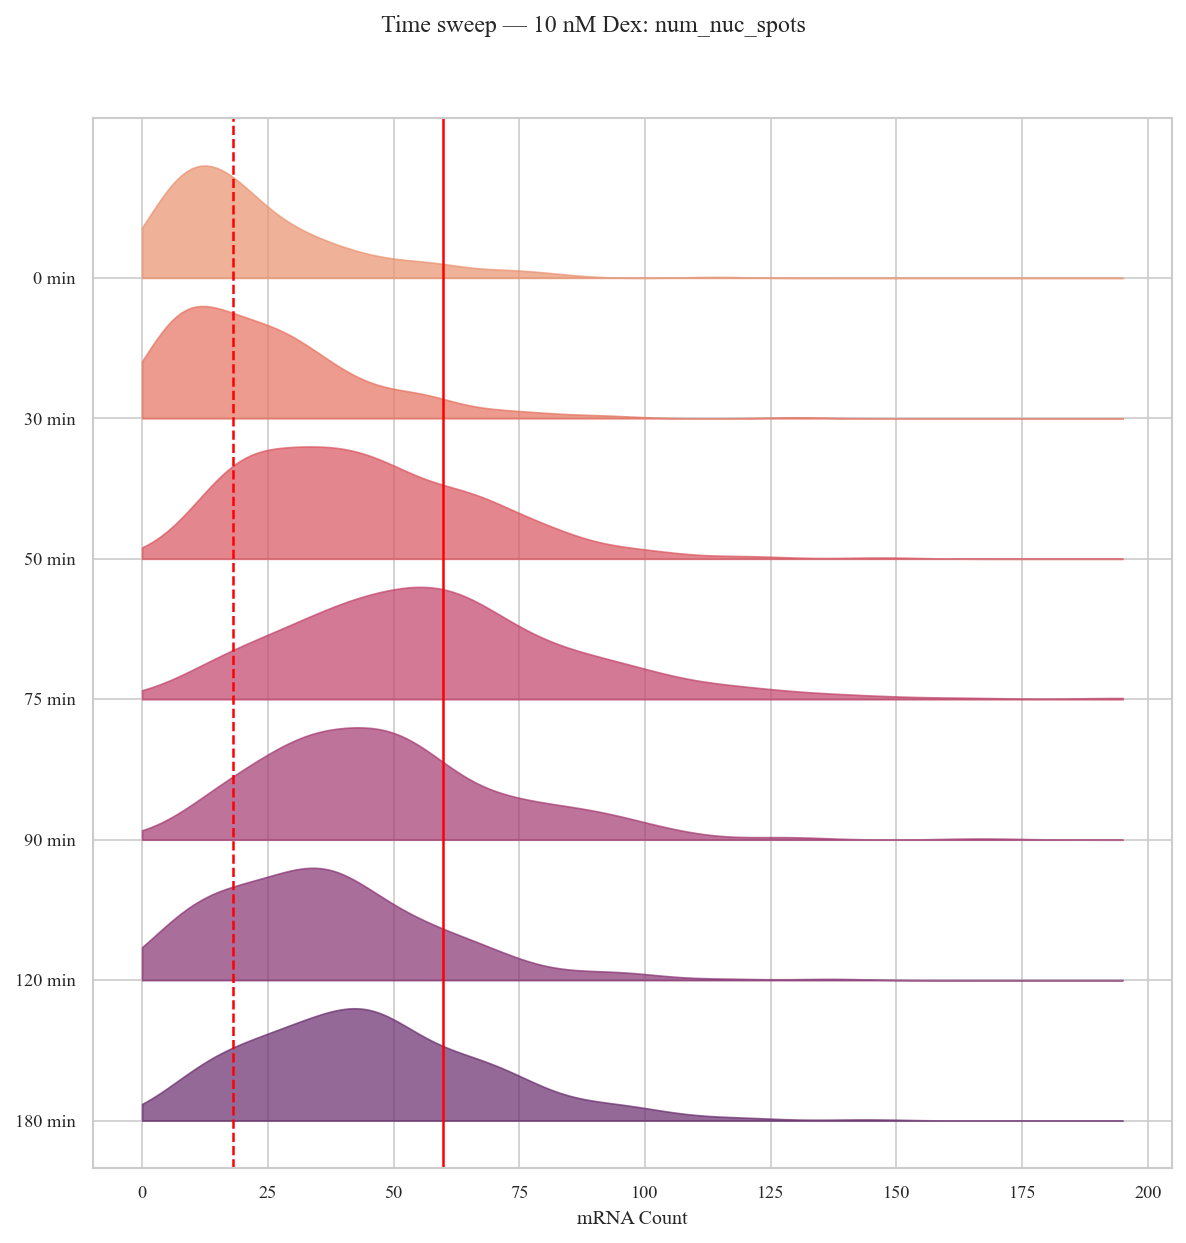

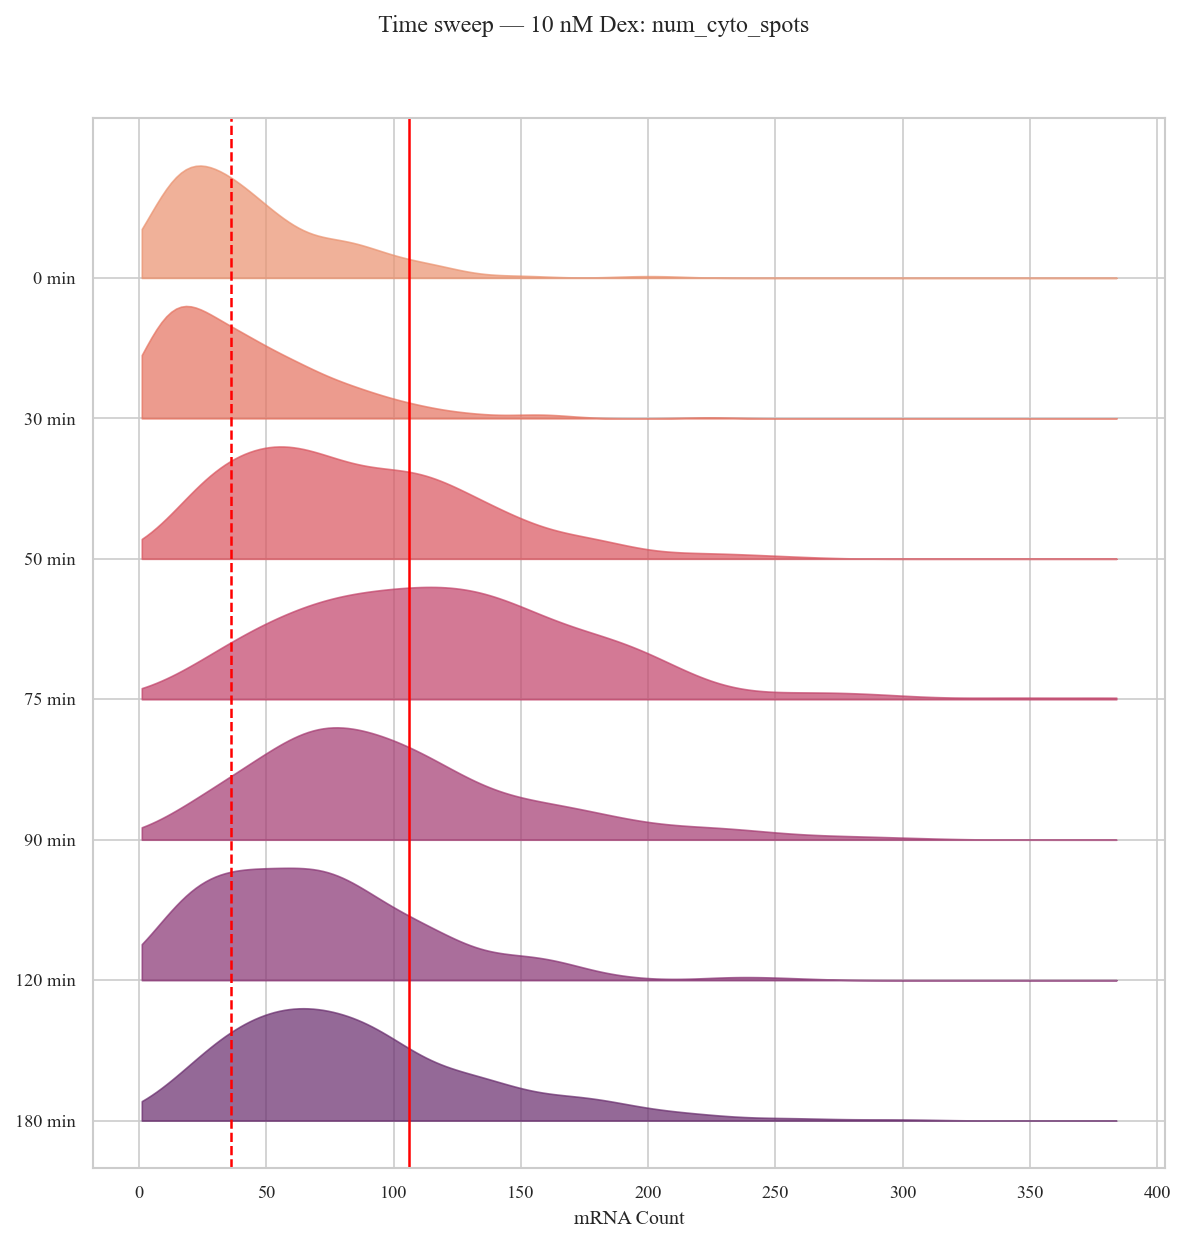

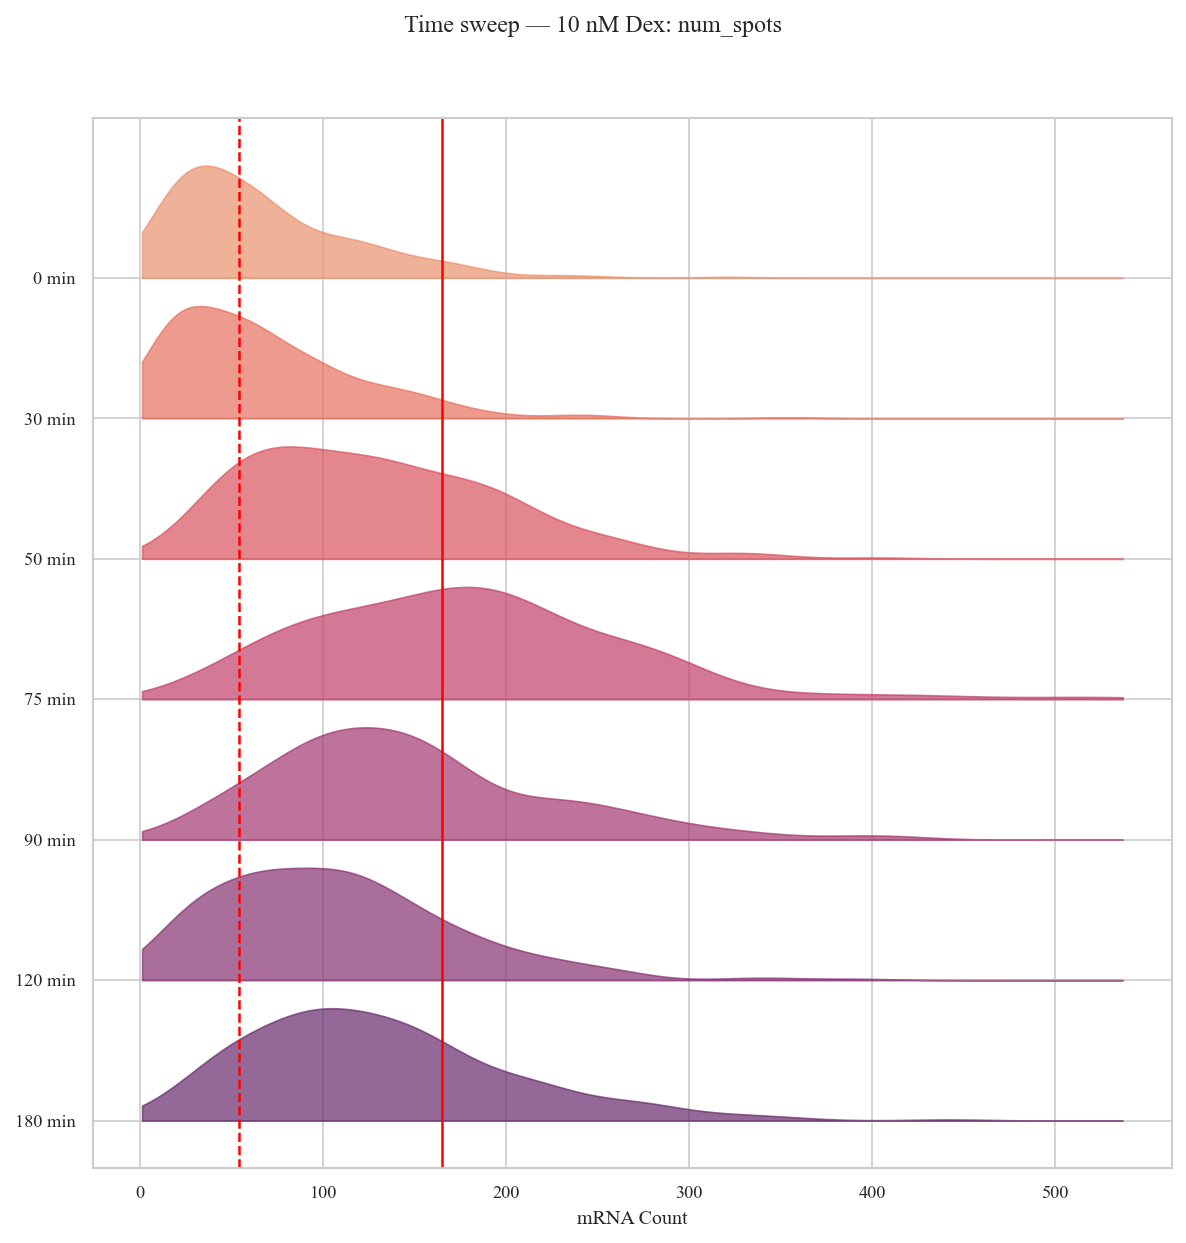

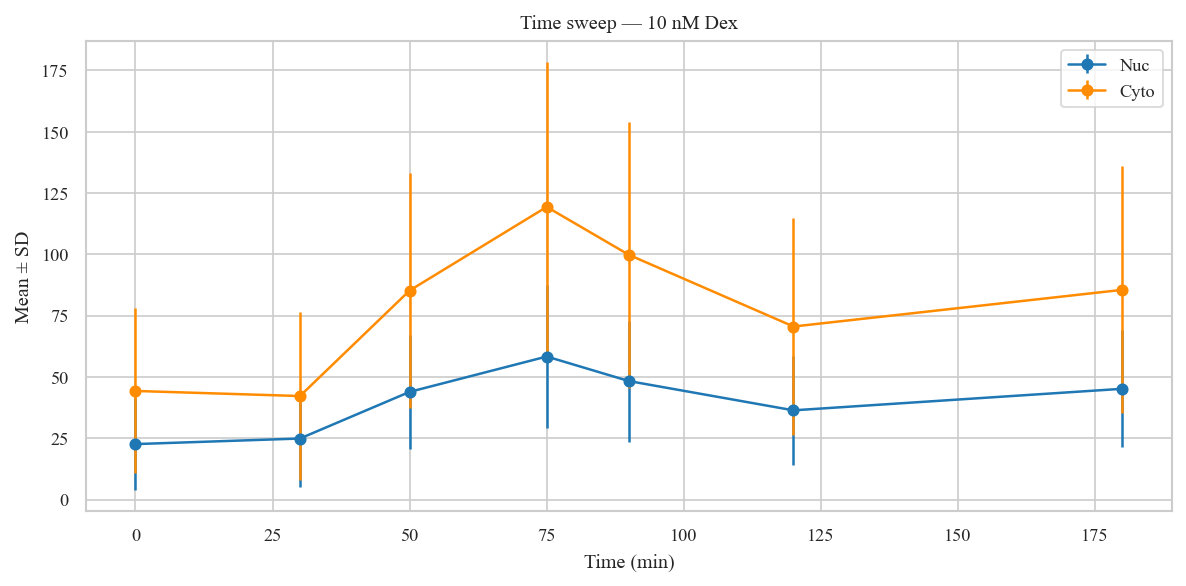

In [10]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_K_slide1_BFmean_061825',
    'DUSP1_K_slide2_BFmean_061825',
    'DUSP1_K_slide3_BFmean_061825',
    'DUSP1_K_slide4_BFmean_061825',
    'DUSP1_K_slide5_BFmean_061825',
    'DUSP1_K_slide6_BFmean_061825',
    'DUSP1_K_slide7_BFmean_061825',
    'DUSP1_K_slide8_BFmean_061825',
    'DUSP1_K_slide9_BFmean_061825',
    'DUSP1_K_slide10_BFmean_061825',
    'DUSP1_K_slide11_BFmean_061825',
    'DUSP1_K_slide12_BFmean_061825',
    'DUSP1_K_slide13_BFmean_061825',
    'DUSP1_K_slide14_BFmean_061825',
    'DUSP1_K_slide15_BFmean_061825',
    'DUSP1_K_slide16_BFmean_061825',
    'DUSP1_K_slide17_BFmean_061825',
    'DUSP1_K_slide18_BFmean_061825',
    'DUSP1_K_slide19_BFmean_061825',        
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 70
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_K_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

print("\n>>> Time+Conc sweeps for [0.3, 1, 10] nM Dex")
plotter.plot_time_conc_sweep(
    conc_list=[0.3, 1, 10],
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica L 3hr 100nM time-concentration sweep R2 - By Group`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_time_conc_sweep_0min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_time_conc_sweep_0min_050223_R3.h5 -> Analysis_DUSP1_L_day1_90th_BF90th_061825_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_300pM_30min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_300pM_30min_050223_R3.h5 -> Analysis_DUSP1_L_day1_90th_BF90th_061825_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_300pM_50min_050223_R3.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20230530/DUSP1_Dex_300pM_50min_050223_R3.h5 -> Analysis_DUSP1_L_day1_90th_BF90th_061825_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20230605/DUSP1_Dex_300pM_90min_050223_R3.h5
Reading D

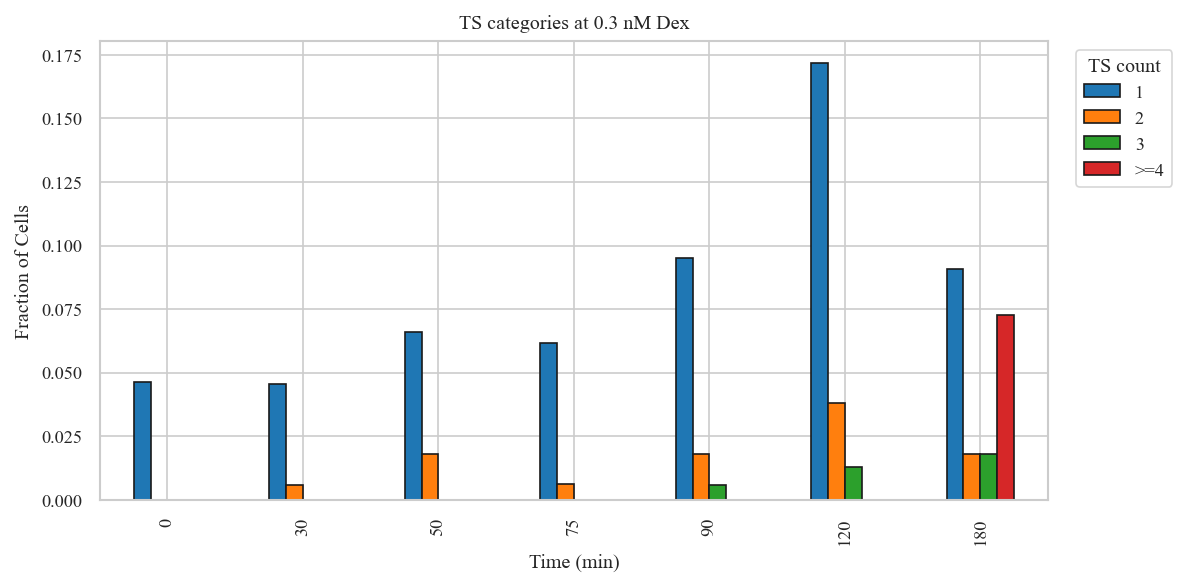

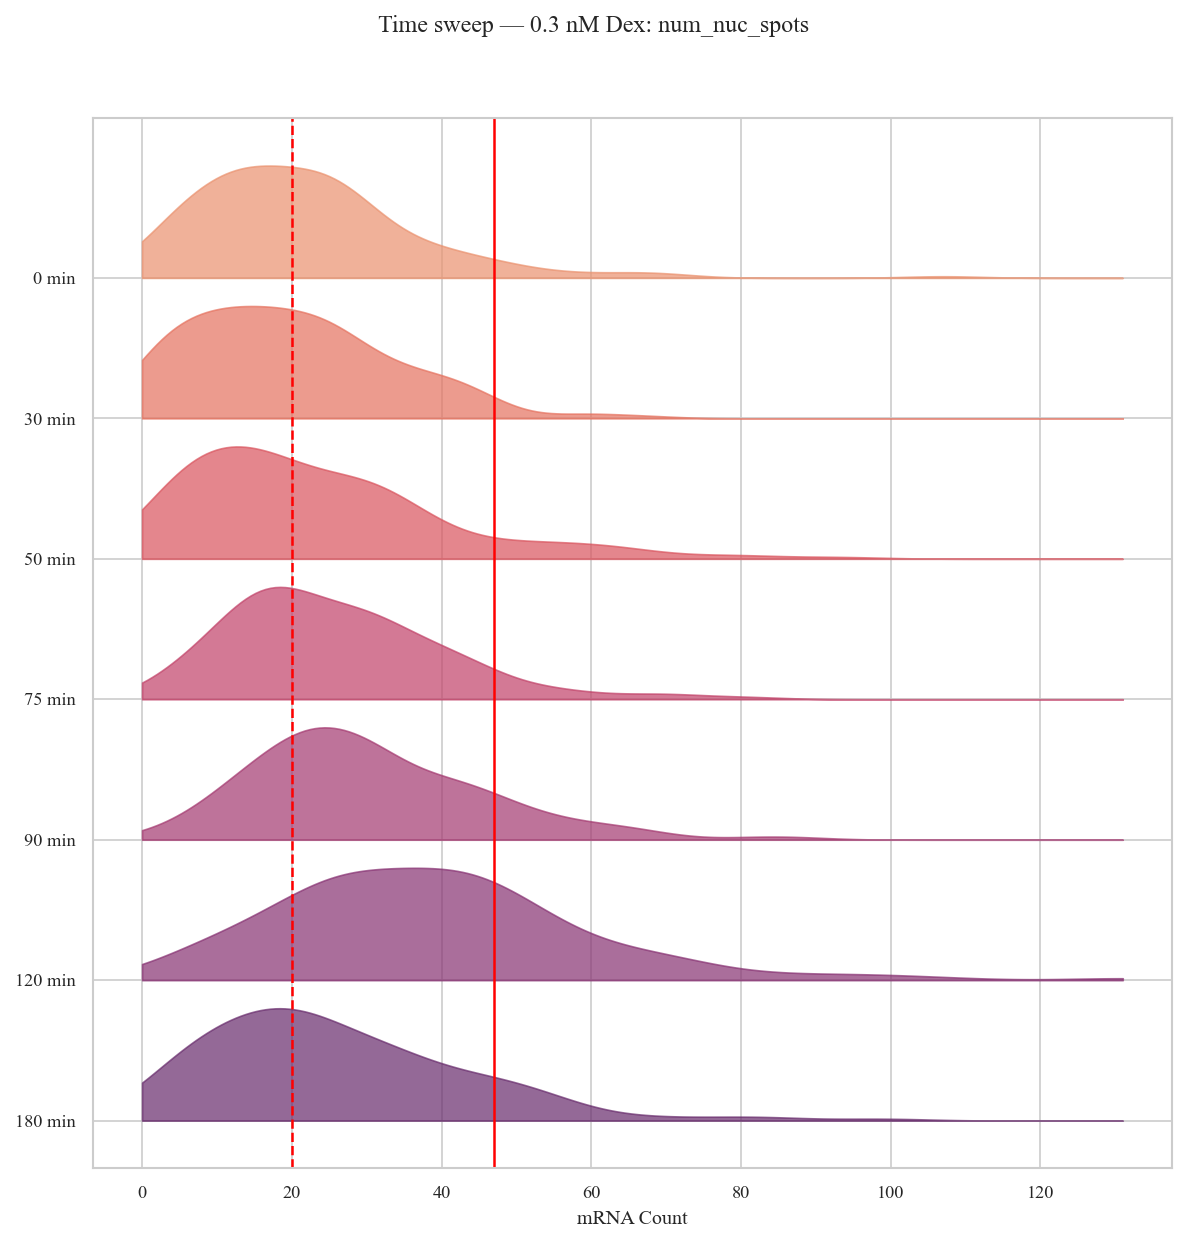

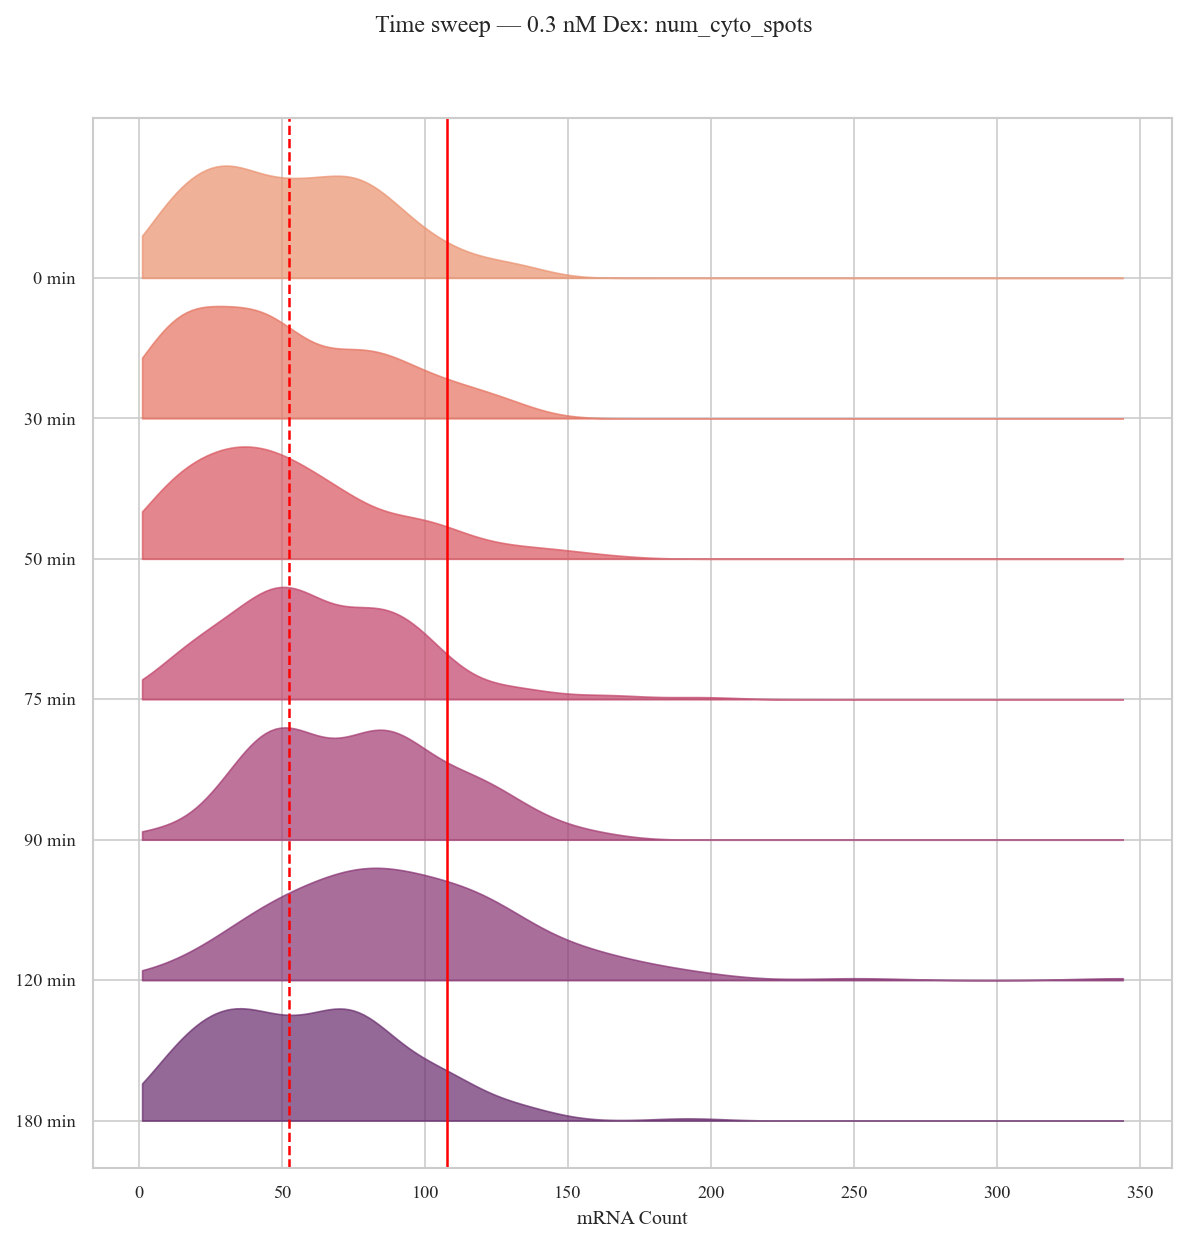

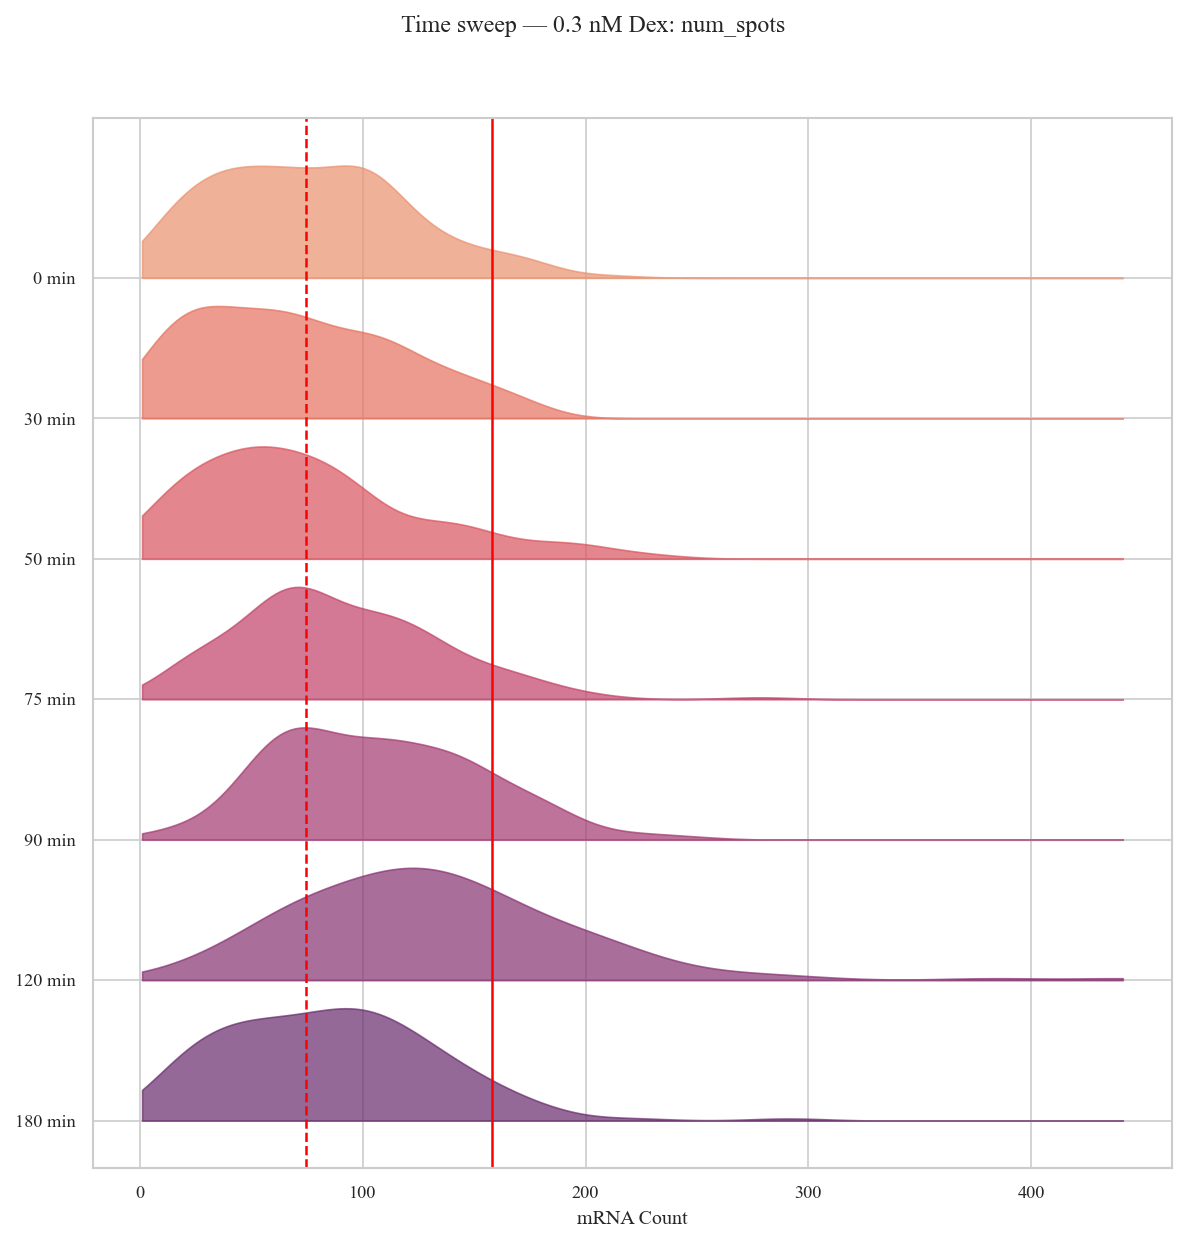

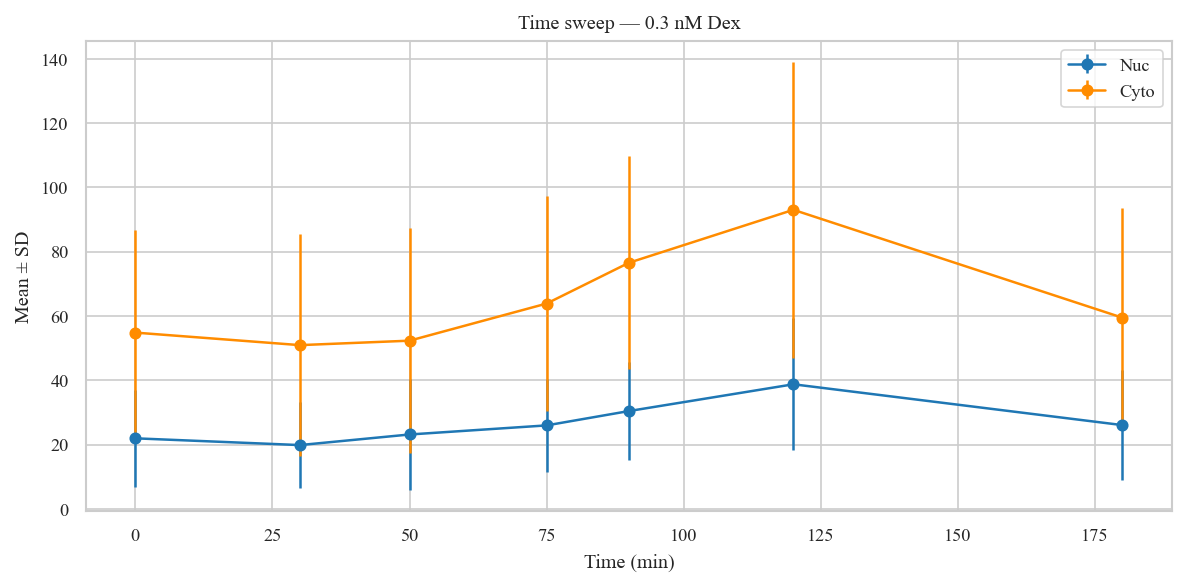


=== Time sweep for 1 nM Dex ===


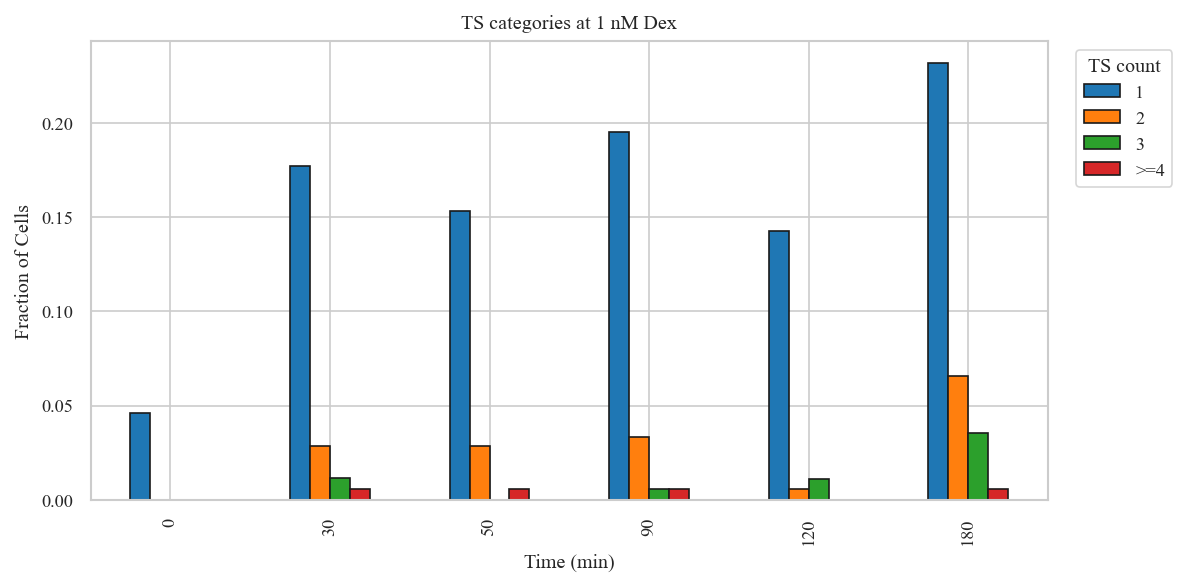

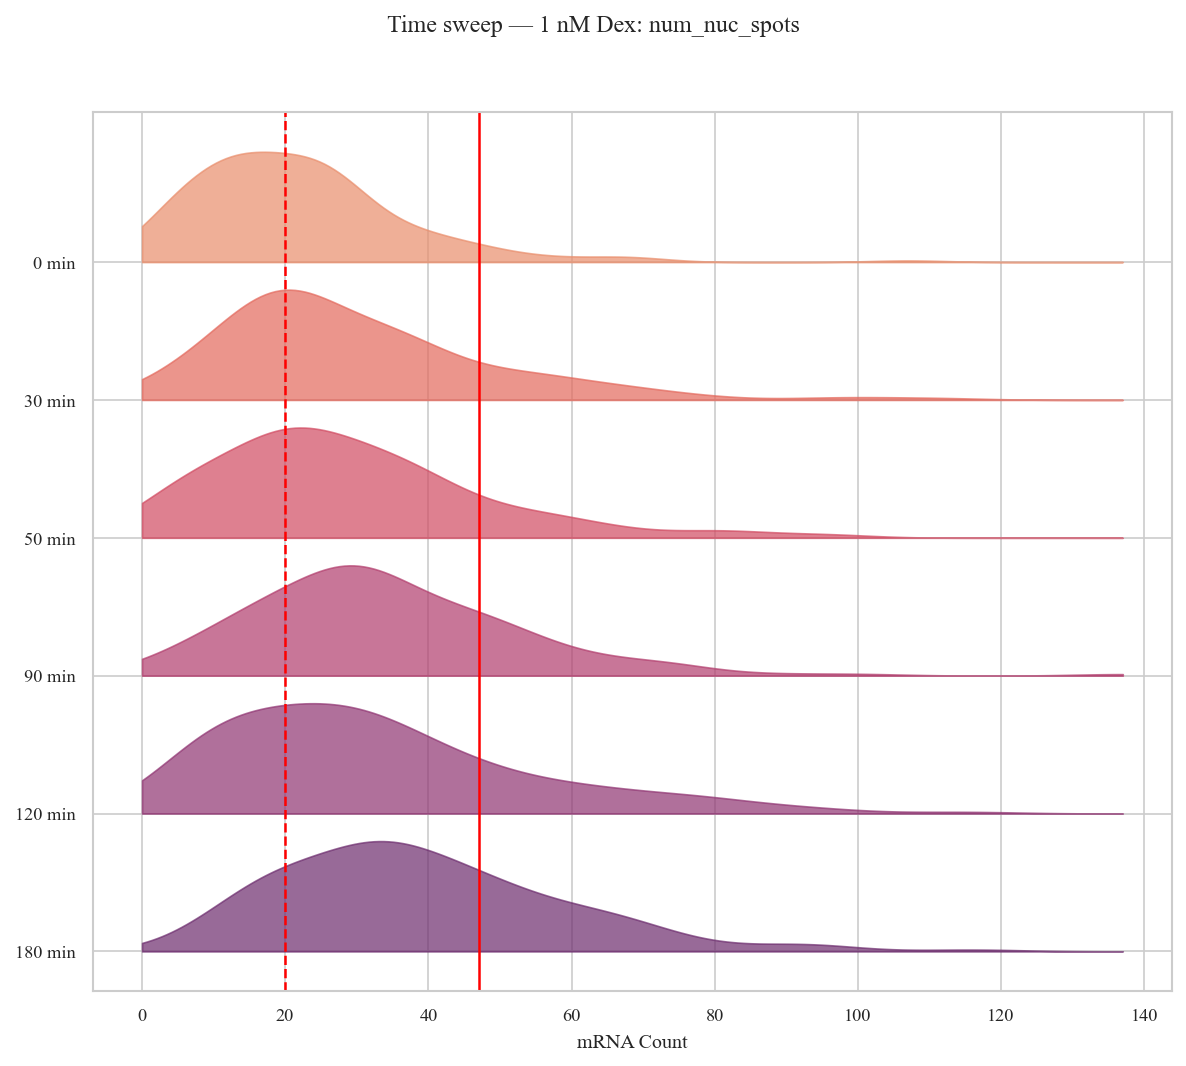

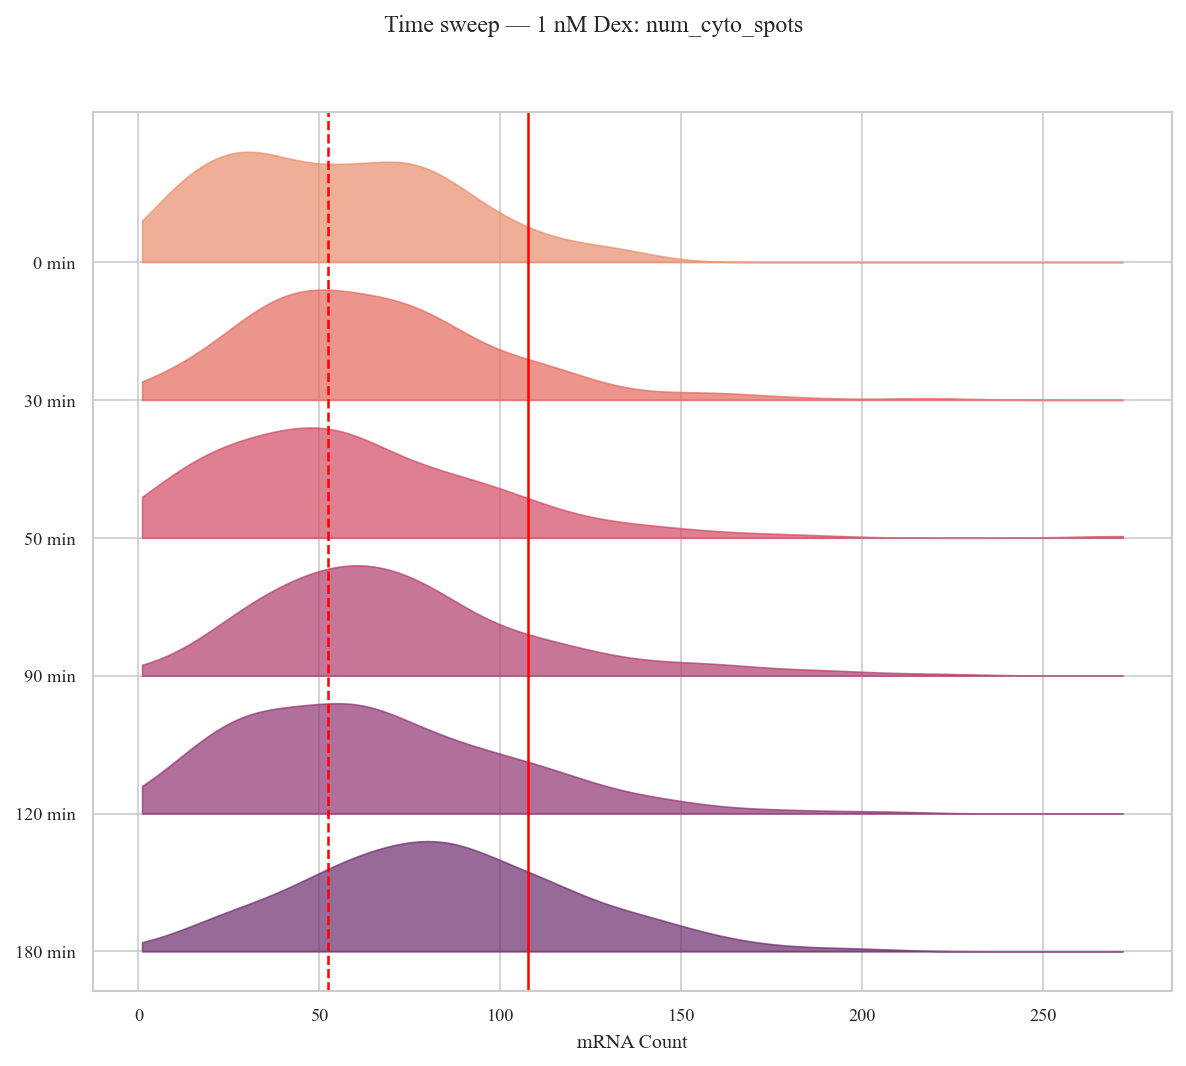

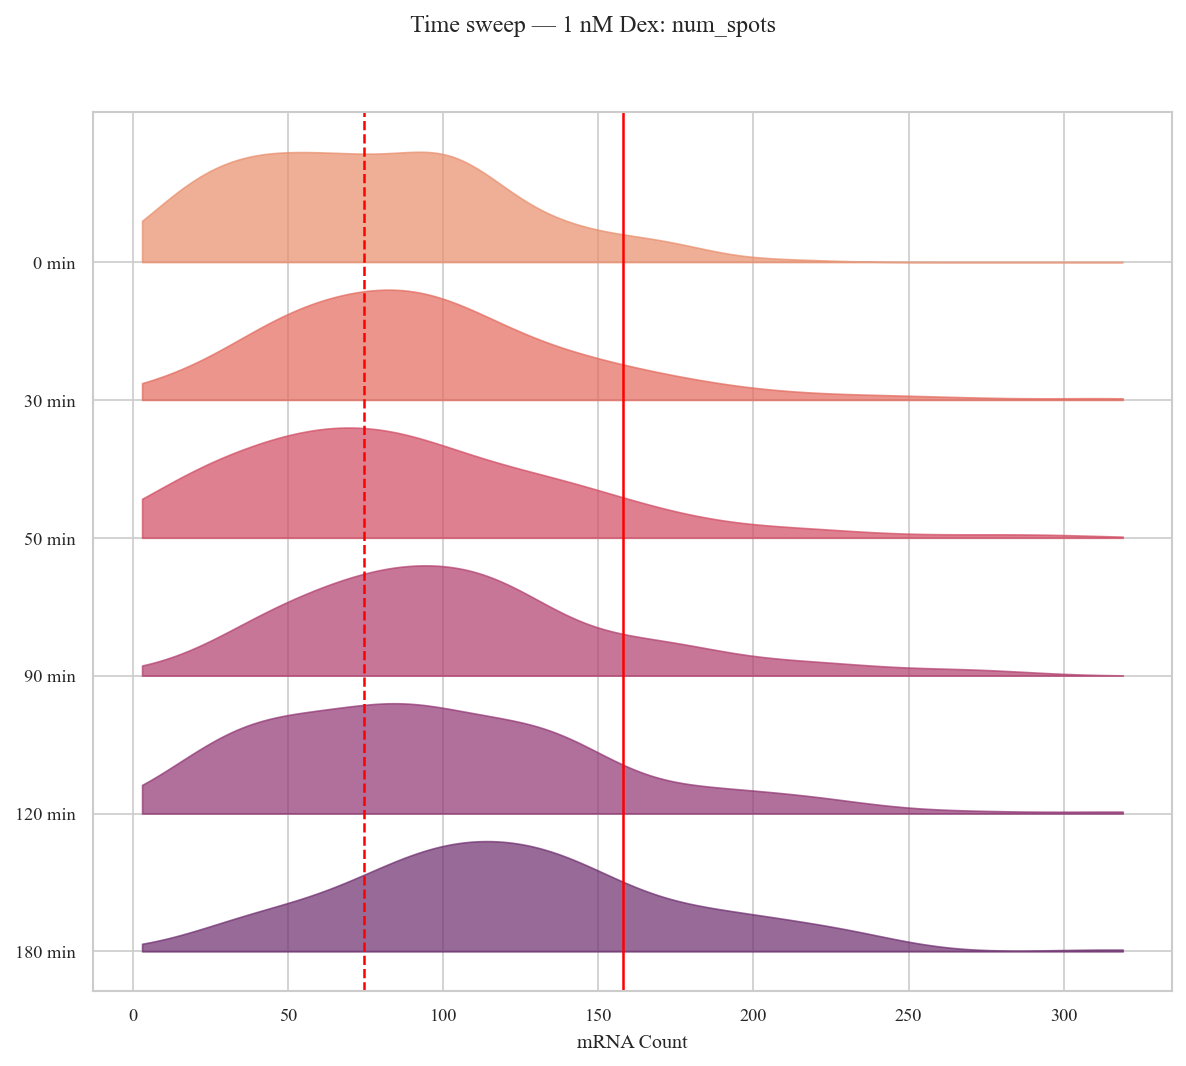

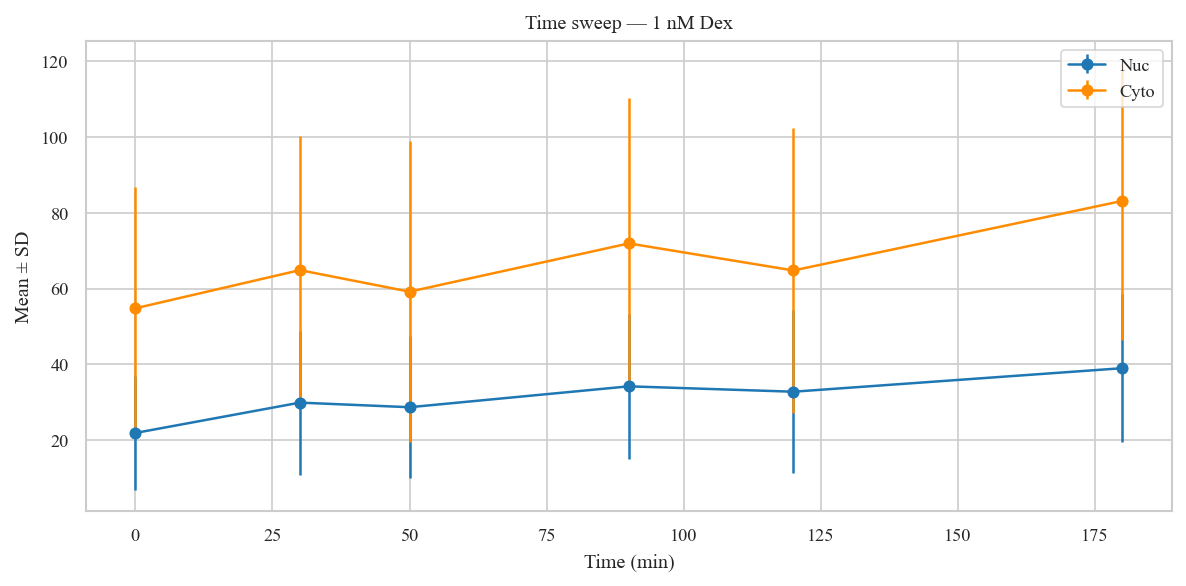


=== Time sweep for 10 nM Dex ===


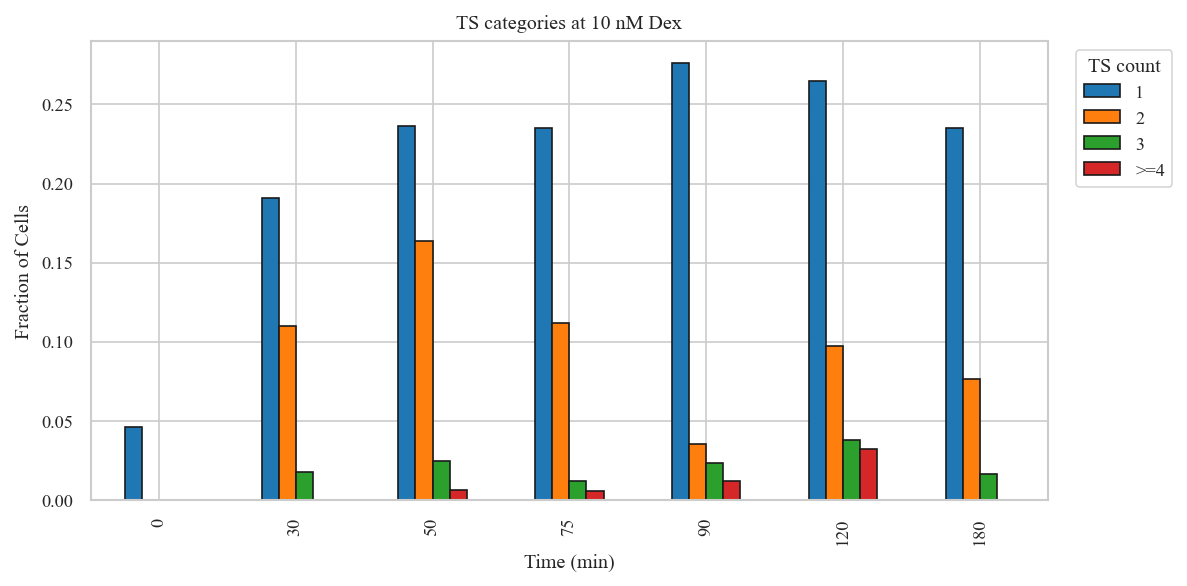

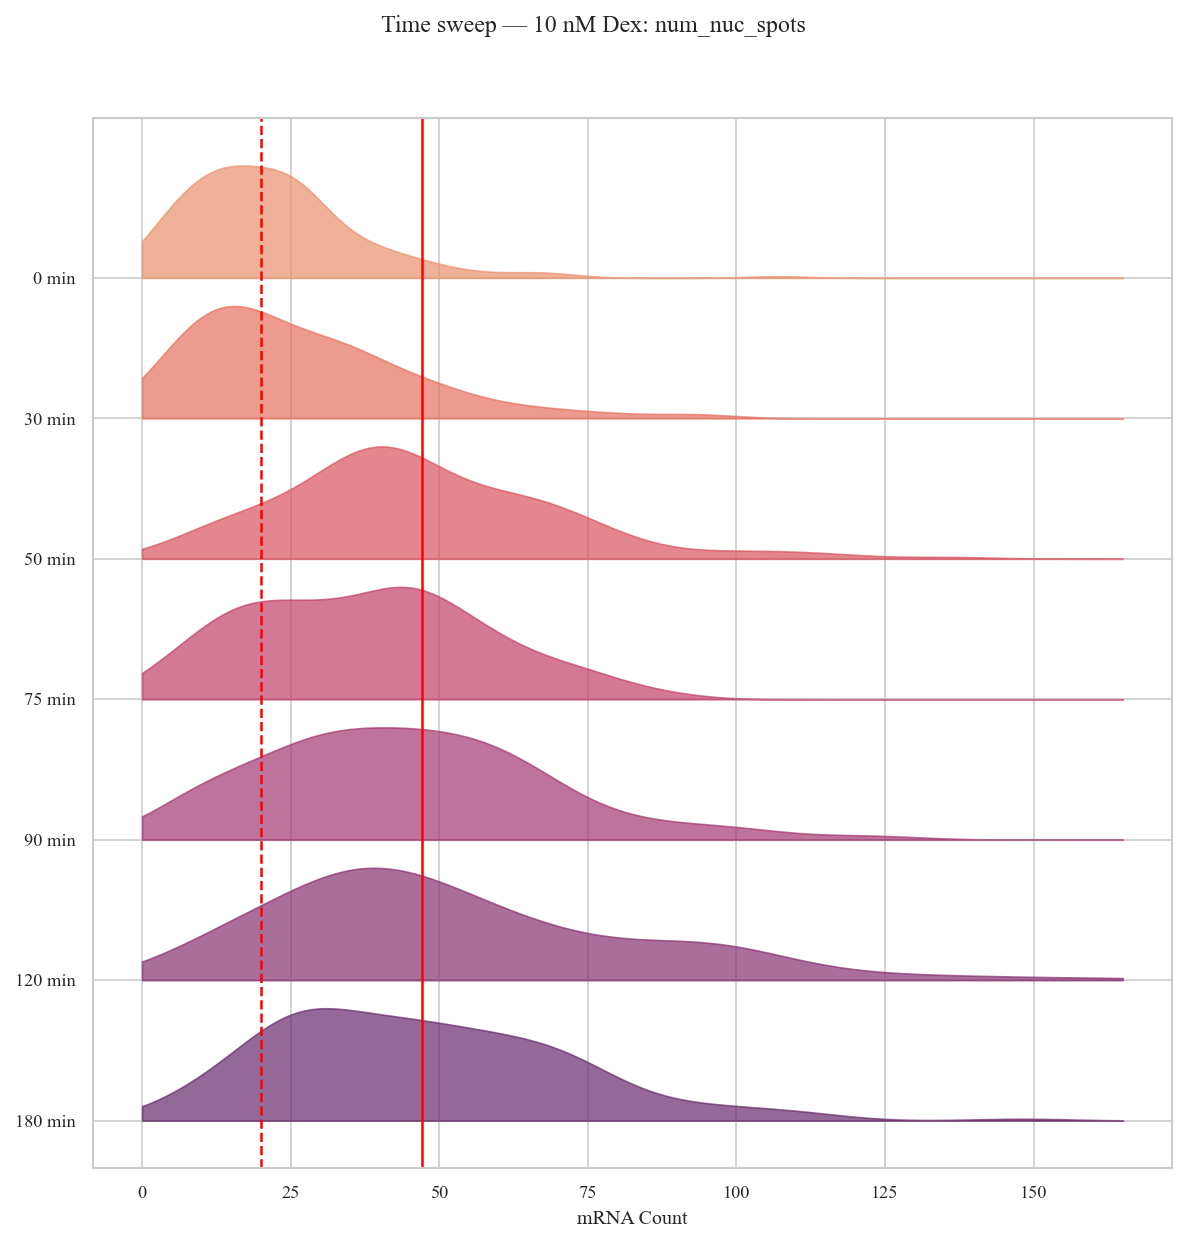

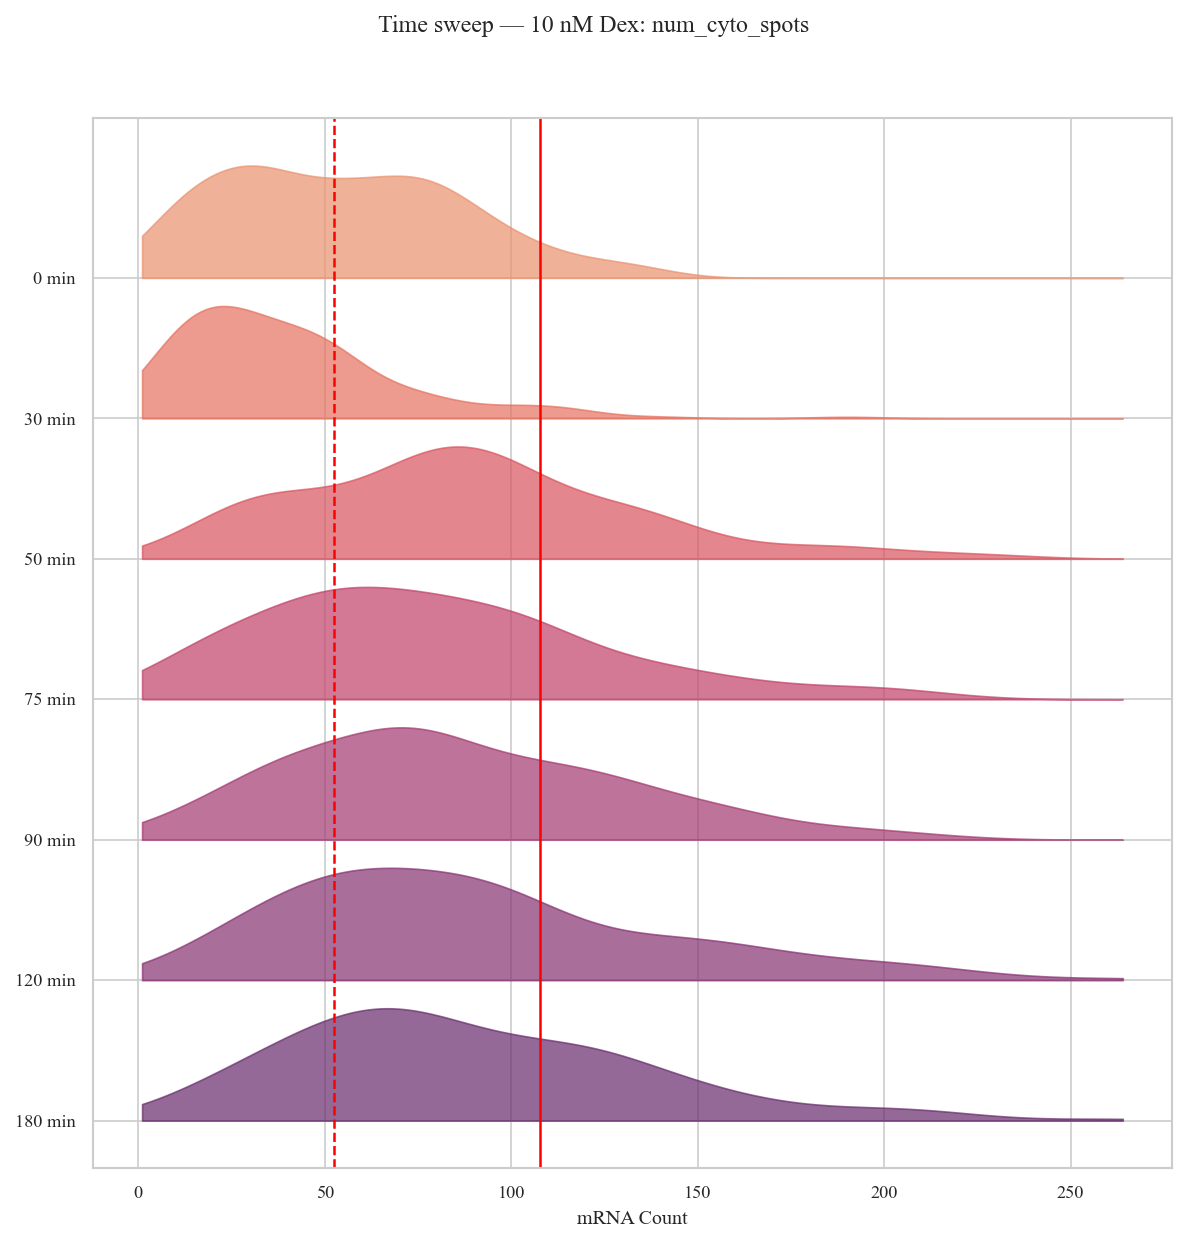

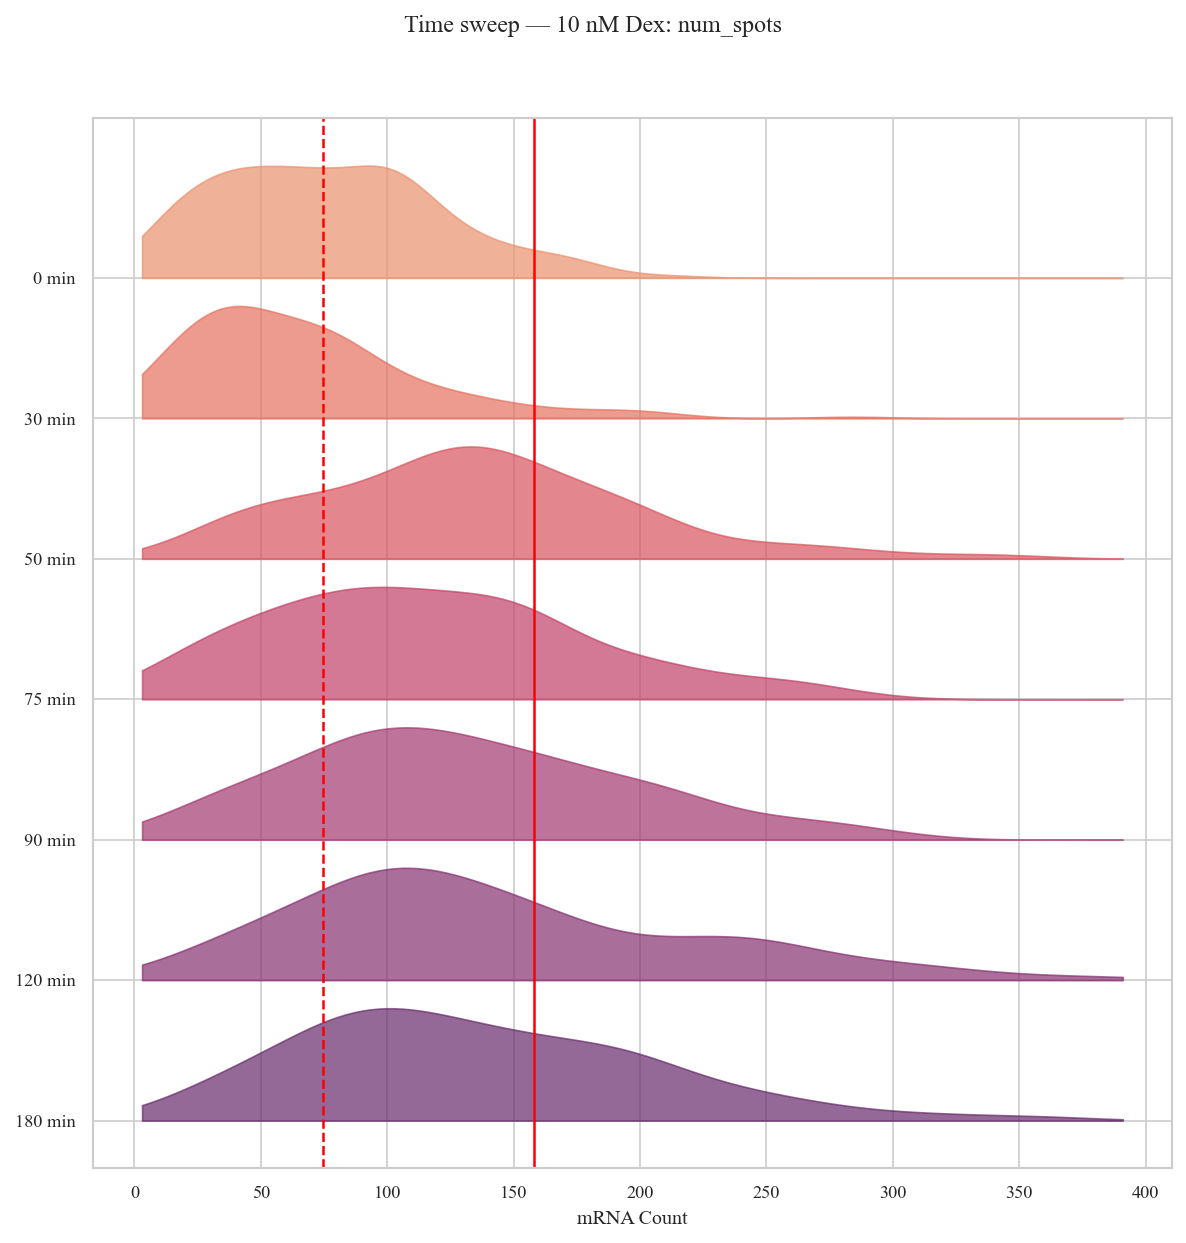

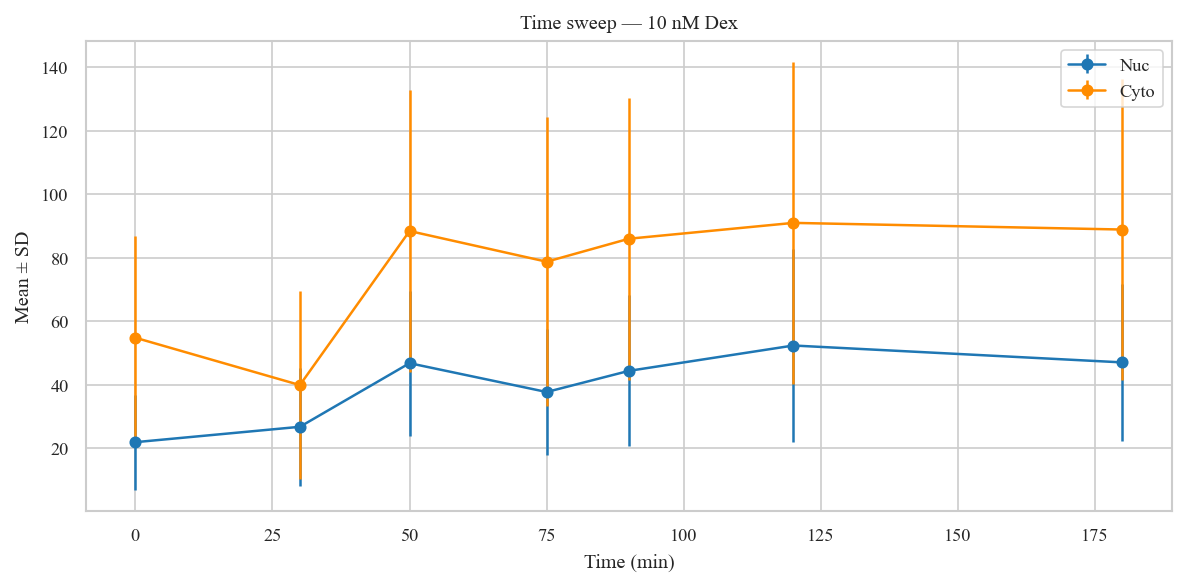

In [11]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_L_day1_90th_BF90th',
    'DUSP1_L_day2_mean_BFmean',
    'DUSP1_L_day3_25th_BF25th',
    'DUSP1_L_day4_25th_BF25th',       
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 80
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_L_BFmix'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

print("\n>>> Time+Conc sweeps for [0.3, 1, 10] nM Dex")
plotter.plot_time_conc_sweep(
    conc_list=[0.3, 1, 10],
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica G 75min concentration sweep R1 - By Group`**

In [ ]:
# # 0) Define the three‐day analysis names for DUSP1_G
# analysis_names = [
#     'DUSP1_G_slide1_BFmean_061825',
#     'DUSP1_G_slide2_BFmean_061825',
#     'DUSP1_G_slide3_BFmean_061825',
#     'DUSP1_G_slide4_BFmean_061825',
#     'DUSP1_G_slide5_BFmean_061825',
#     'DUSP1_G_slide6_BFmean_061825',
#     'DUSP1_G_slide7_BFmean_061825',
#     'DUSP1_G_slide8_BFmean_061825',
#     'DUSP1_G_slide9_BFmean_061825',
# ]

# # 1) Load & concatenate all slides for DUSP1_G
# dm = make_combined_manager(loc, log_location, mac, analysis_names)
# spots_df    = dm.select_datasets("spotresults",     dtype="dataframe")
# clusters_df = dm.select_datasets("clusterresults",  dtype="dataframe")
# props_df    = dm.select_datasets("cell_properties", dtype="dataframe")
# dm.close()

# print(f"Loaded {len(analysis_names)} slides for G: "
#       f"spots {spots_df.shape}, clusters {clusters_df.shape}, props {props_df.shape}")

# # 2) SNRAnalysis → DUSP1Measurement
# abs_threshold = 6
# mg_threshold  = 3

# snr = SNRAnalysis(spots_df, props_df, clusters_df,
#                     abs_threshold=abs_threshold,
#                     mg_threshold=mg_threshold)
# merged_spots, merged_clusters, merged_cellprops = snr.get_results()

# dusp = DUSP1Measurement(merged_spots, merged_clusters, merged_cellprops)
# cell_level_results = dusp.measure(abs_threshold=abs_threshold,
#                                       mg_threshold=mg_threshold)

# # 3) Prefix unique IDs (prefix=90 for G replicate)
# max_id   = merged_cellprops['unique_cell_id'].max()
# digits   = len(str(max_id))
# rep_prefix = 90
# prefix   = rep_prefix * (10 ** digits)

# for df in (merged_spots, merged_clusters, merged_cellprops, cell_level_results):
#     df['unique_cell_id'] += prefix

# # also prefix spot and cluster IDs
# max_spot_id    = merged_spots['unique_spot_id'].max()
# spot_prefix    = rep_prefix ** len(str(max_spot_id))
# merged_spots   ['unique_spot_id'] += spot_prefix

# max_cluster_id = merged_clusters['unique_cluster_id'].max()
# cluster_prefix = rep_prefix ** len(str(max_cluster_id))
# merged_clusters['unique_cluster_id'] += cluster_prefix

# # ─── 4) Filtering ───────────────────────────────────────────────────────────────
# filterer = DUSP1_filtering(method=method,
#                            abs_threshold=abs_threshold,
#                            mg_threshold=mg_threshold)
# filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
#     filterer.apply_all(spots=merged_spots_df,
#                        clusters=merged_clusters_df,
#                        cellprops=merged_cellprops_df)

# # ─── 5) main display ──────────────────────────────────────────────────────────
# # build a fresh manager so the display code can find every HDF5
# dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
# display_manager = DUSP1DisplayManager(
#     dm_disp,
#     cell_level_results=SSITcellresults,
#     spots=filtered_spots,
#     clusters=filtered_clusters,
#     cellprops=filtered_cellprops,
#     removed_spots=removed_spots
# )
# display_manager.default_display(
#     per_h5=1,
#     show=False,                 # Preview in notebook
#     save=True,                 # Save PNGs
#     outdir=img_dir,
#     dpi_notebook=120,          # lighter for notebook
#     dpi_save=600,              # publication quality
#     show_removed=True,         # overlay removed spots in crops
#     removed_color="red"  # distinct color for removed
# )
# dm_disp.close()

# # 6) Save only the final, post‐filter CSVs
# output_dir = save_dir
# os.makedirs(output_dir, exist_ok=True)
# rep_string = 'DUSP1_G_BFmean'
# base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

# SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
# filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
# filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
# filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
# removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

# print("Saved final results to:", output_dir)

# # ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
# plotter = PostProcessingPlotter(
#     clusters_df=filtered_clusters,
#     cellprops_df=filtered_cellprops,
#     ssit_df=SSITcellresults,
#     is_tpl= False,
# )
# times = sorted(SSITcellresults['time'].unique())
# nonzero = [t for t in times if t != 0]
# if len(nonzero) != 1:
#     raise ValueError(f"Expected exactly one non-zero time for G sweep, found {nonzero}")
# timepoint_G = nonzero[0]

# print(f"\n>>> Concentration sweep at t={timepoint_G} min for G replicate")
# plotter.plot_conc_sweep(
#     timepoint=timepoint_G,
#     save_dir=img_dir,
#     display=True
# )

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_100pM_75min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_100pM_75min_060322.h5 -> Analysis_DUSP1_G_day1_BF75th_061925_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220628/DUSP1_conc_sweep_0min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220628/DUSP1_conc_sweep_0min_060322.h5 -> Analysis_DUSP1_G_day1_BF75th_061925_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_1pM_75min_060322.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_1pM_75min_060322.h5 -> Analysis_DUSP1_G_day1_BF75th_061925_2025-06-19/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220707/DUSP1_conc_sweep_10pM_75min_060322.h5
Reading DataFrame from: /Volumes/

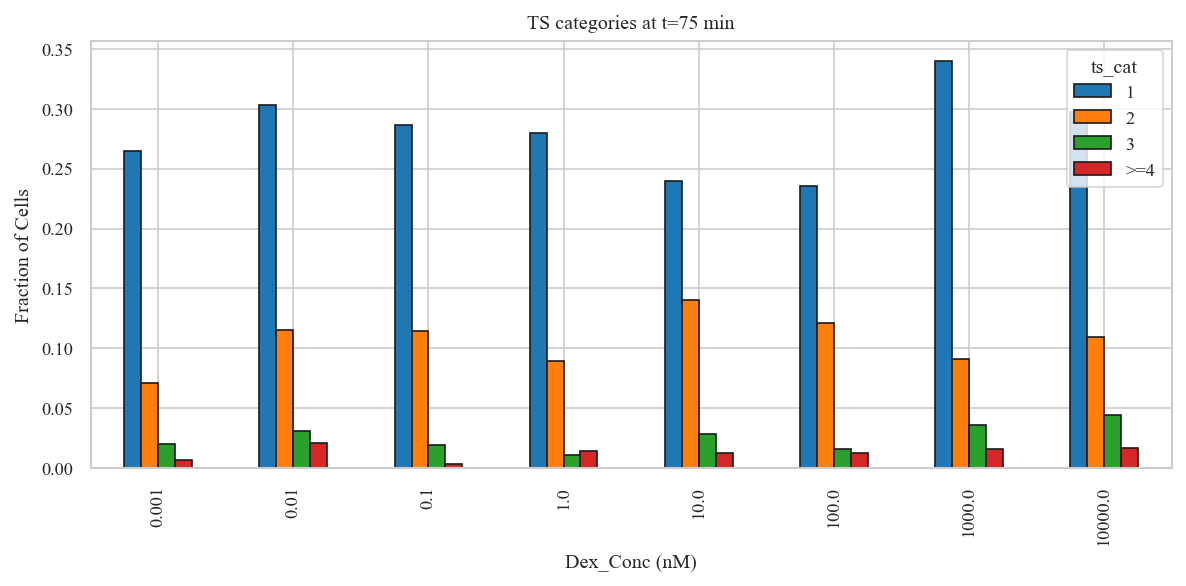

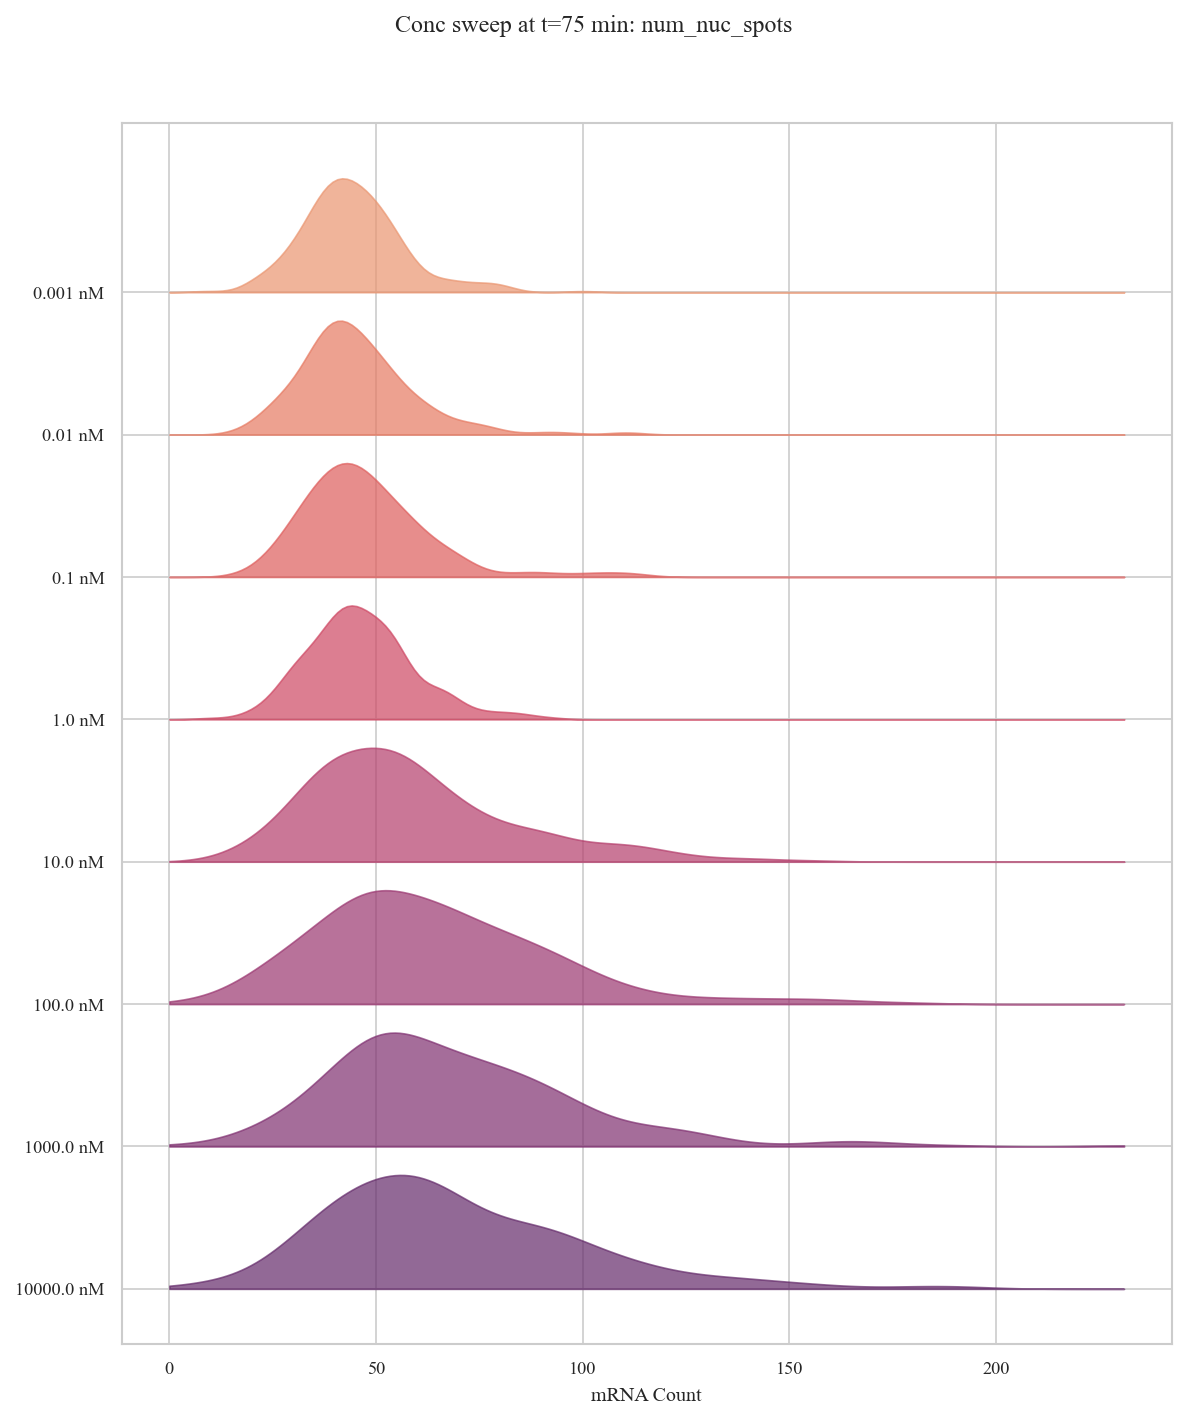

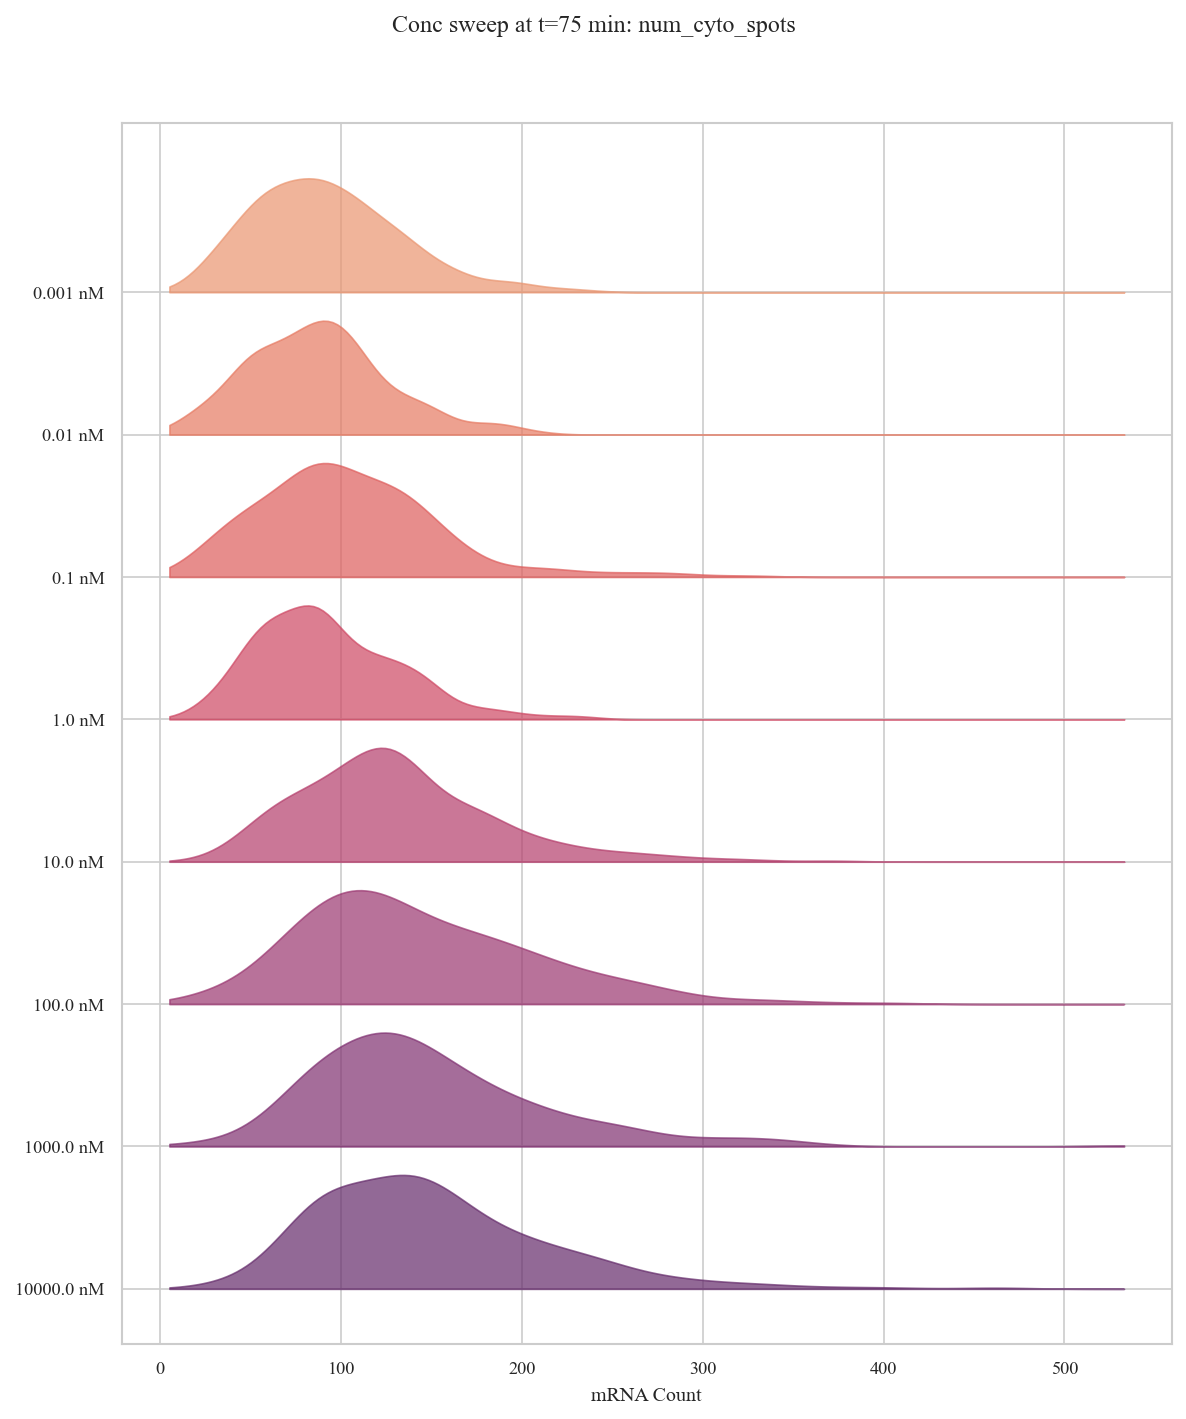

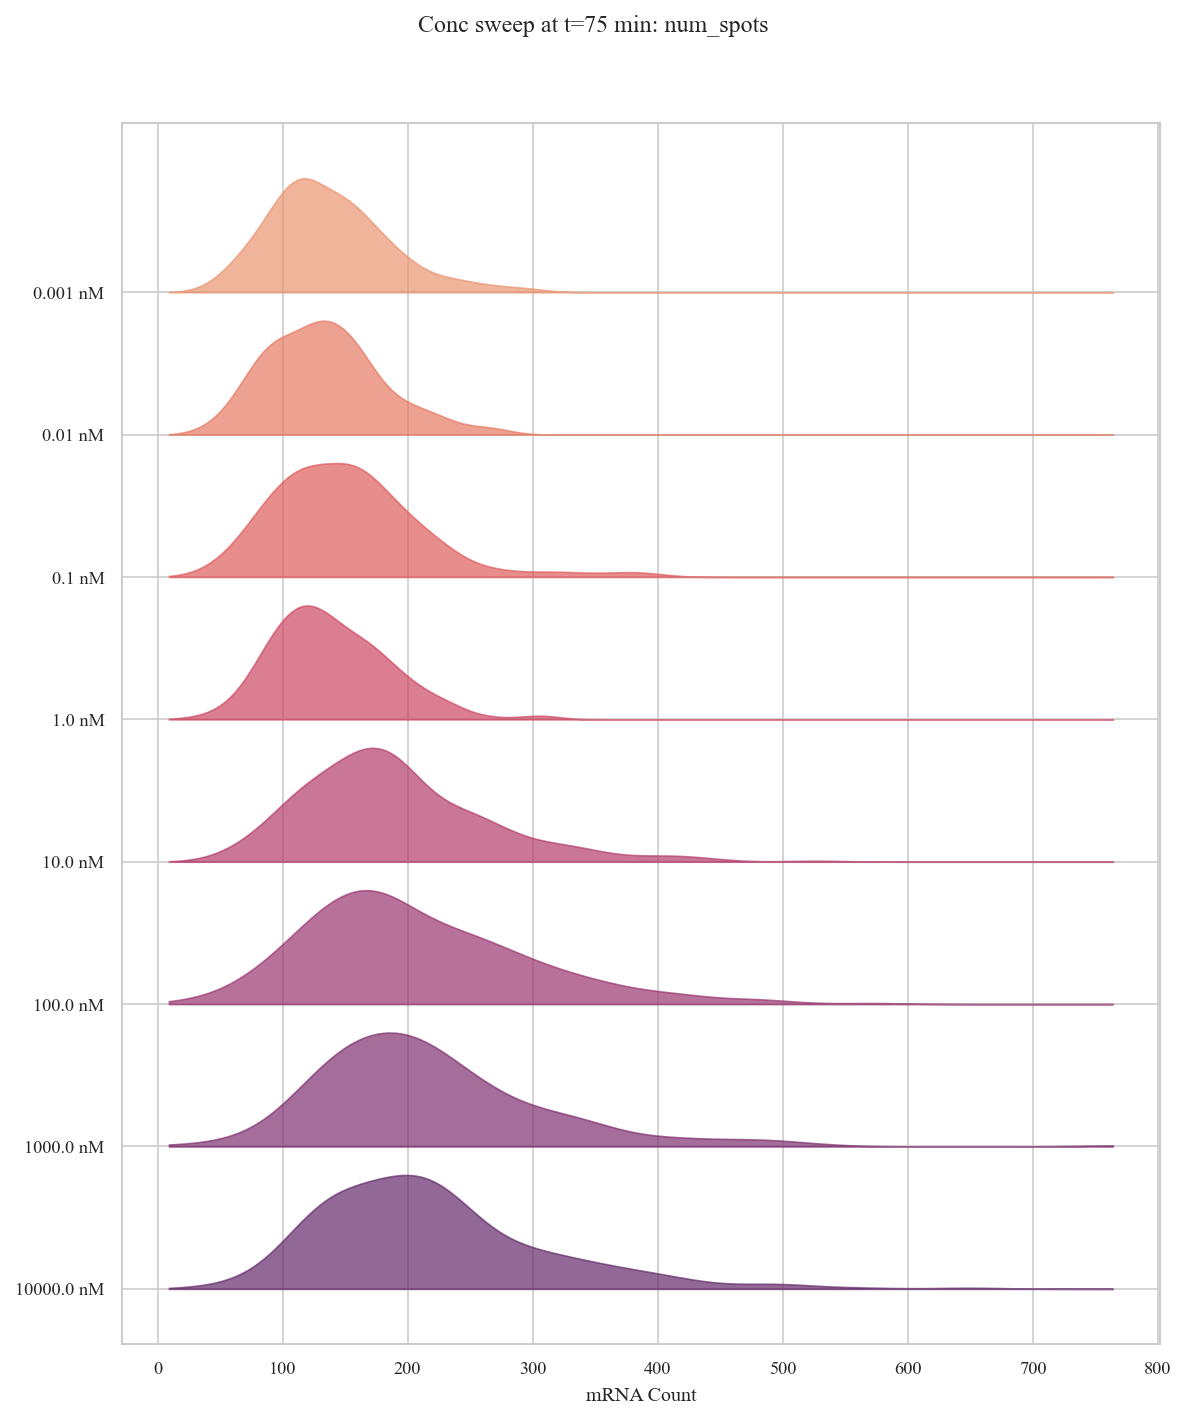

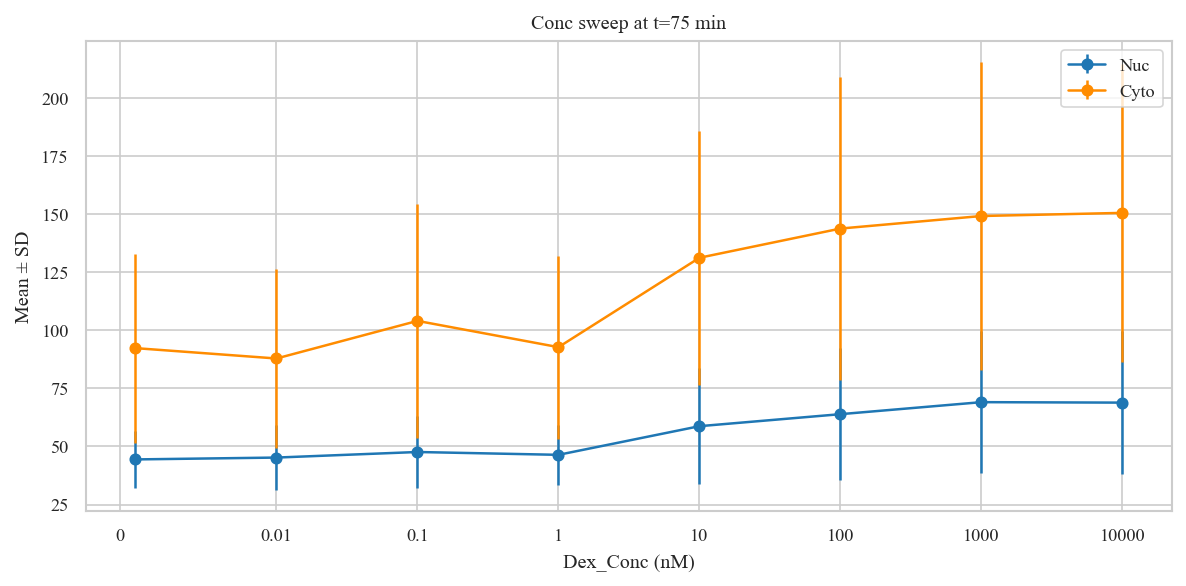

In [12]:
# 0) Define the three‐day analysis names for DUSP1_G
analysis_names = [
    'DUSP1_G_day1_BF75th',
    'DUSP1_G_day2_BF75th',
    'DUSP1_G_day3_75th',
]

# 1) Load & concatenate all slides for DUSP1_G
dm = make_combined_manager(loc, log_location, mac, analysis_names)
spots_df    = dm.select_datasets("spotresults",     dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",  dtype="dataframe")
props_df    = dm.select_datasets("cell_properties", dtype="dataframe")
dm.close()

print(f"Loaded {len(analysis_names)} slides for G: "
      f"spots {spots_df.shape}, clusters {clusters_df.shape}, props {props_df.shape}")

# 2) SNRAnalysis → DUSP1Measurement
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                    abs_threshold=abs_threshold,
                    mg_threshold=mg_threshold)
merged_spots, merged_clusters, merged_cellprops = snr.get_results()

dusp = DUSP1Measurement(merged_spots, merged_clusters, merged_cellprops)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                      mg_threshold=mg_threshold)

# 3) Prefix unique IDs (prefix=90 for G replicate)
max_id   = merged_cellprops['unique_cell_id'].max()
digits   = len(str(max_id))
rep_prefix = 90
prefix   = rep_prefix * (10 ** digits)

for df in (merged_spots, merged_clusters, merged_cellprops, cell_level_results):
    df['unique_cell_id'] += prefix

# also prefix spot and cluster IDs
max_spot_id    = merged_spots['unique_spot_id'].max()
spot_prefix    = rep_prefix ** len(str(max_spot_id))
merged_spots   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots,
                       clusters=merged_clusters,
                       cellprops=merged_cellprops)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# 6) Save only the final, post‐filter CSVs
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_G_BF75th'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)
times = sorted(SSITcellresults['time'].unique())
nonzero = [t for t in times if t != 0]
if len(nonzero) != 1:
    raise ValueError(f"Expected exactly one non-zero time for G sweep, found {nonzero}")
timepoint_G = nonzero[0]

print(f"\n>>> Concentration sweep at t={timepoint_G} min for G replicate")
plotter.plot_conc_sweep(
    timepoint=timepoint_G,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica H 75min concentration sweep R2 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220718/DUSP1_conc_sweep_R2_0min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220718/DUSP1_conc_sweep_R2_0min_071422.h5 -> Analysis_DUSP1_H_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_1pM_75min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_1pM_75min_071422.h5 -> Analysis_DUSP1_H_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_10pM_75min_071422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_10pM_75min_071422.h5 -> Analysis_DUSP1_H_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20220721/DUSP1_conc_sweep_R2_100pM_75min_071422.h5
Reading

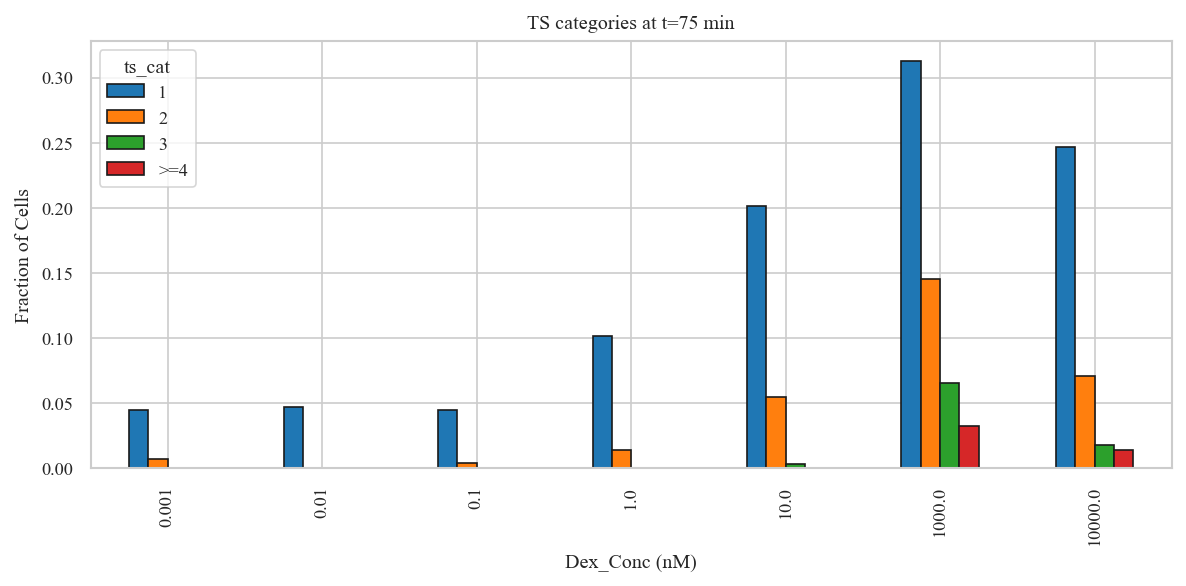

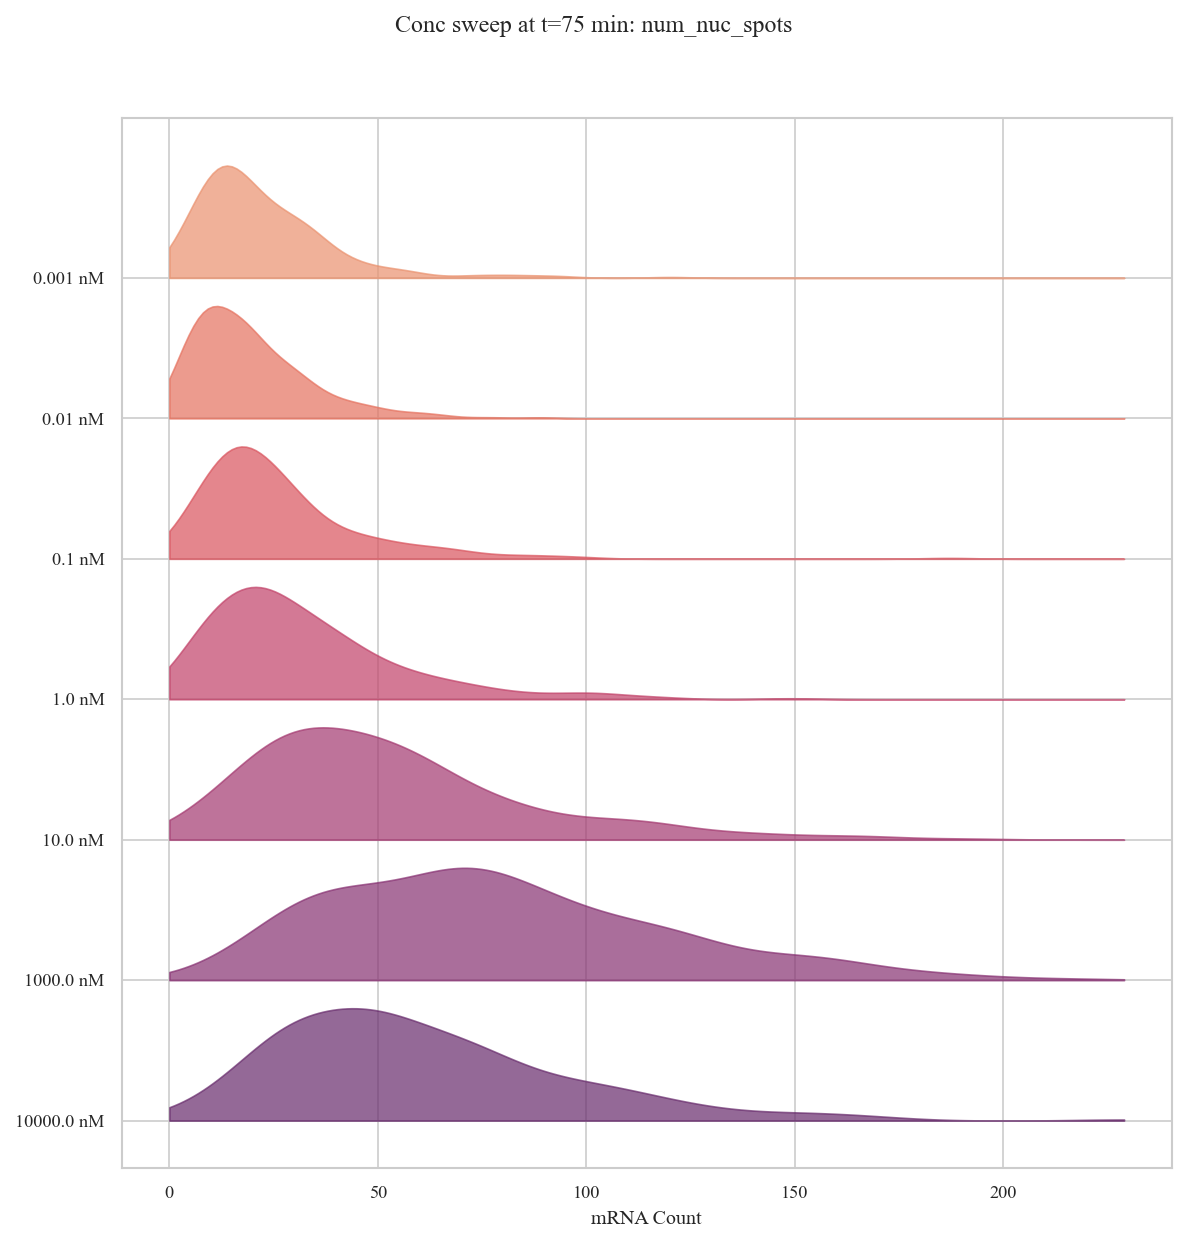

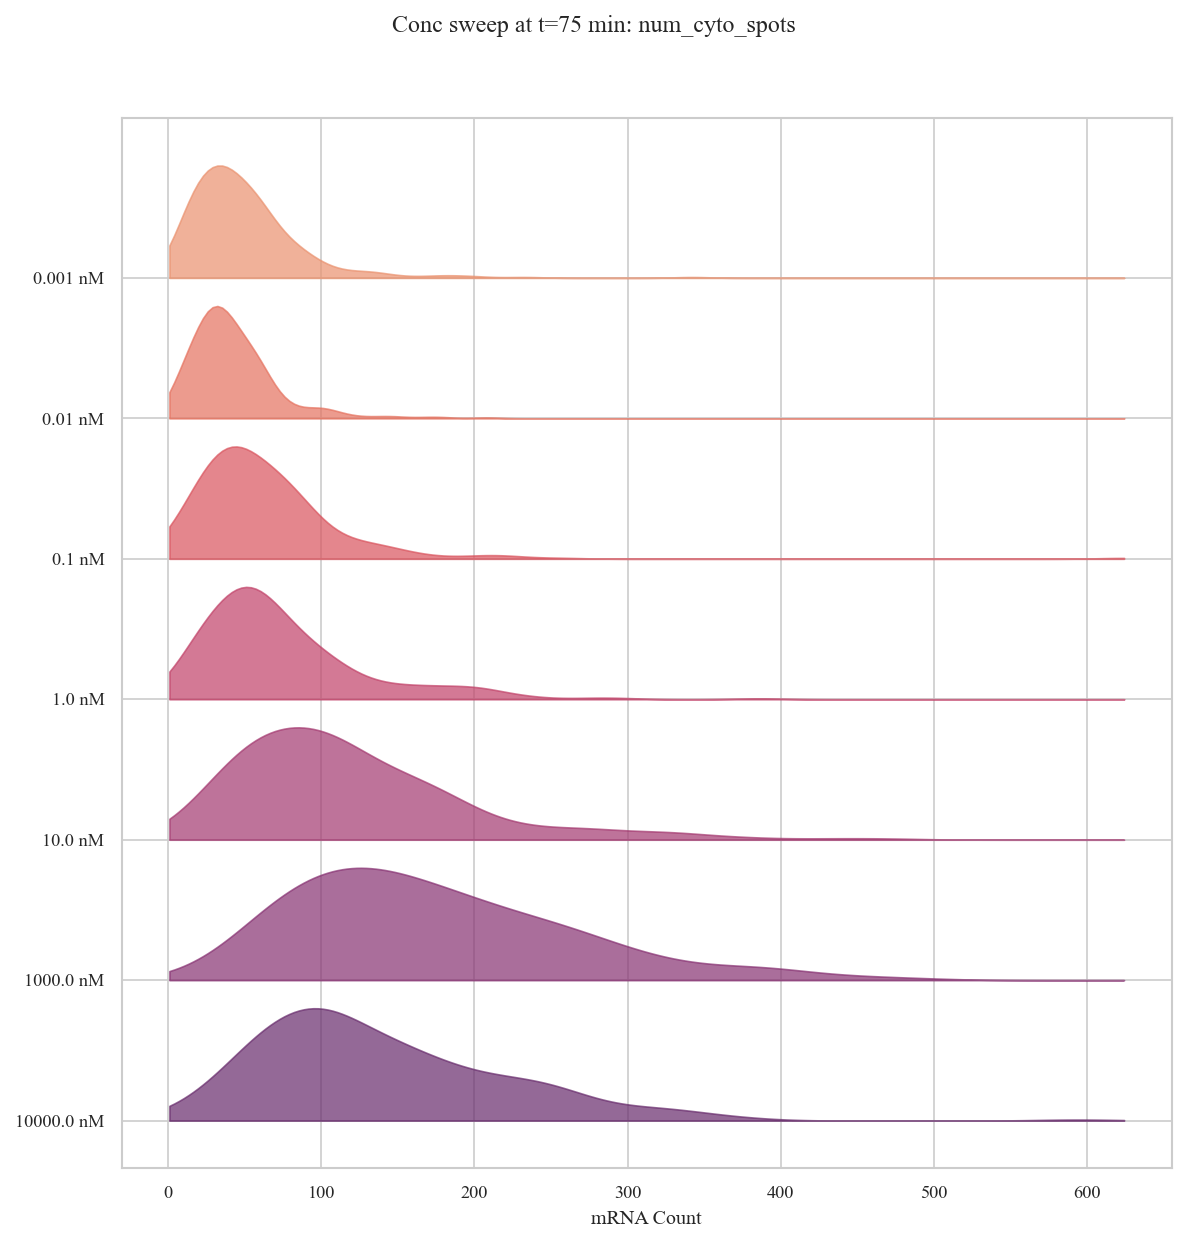

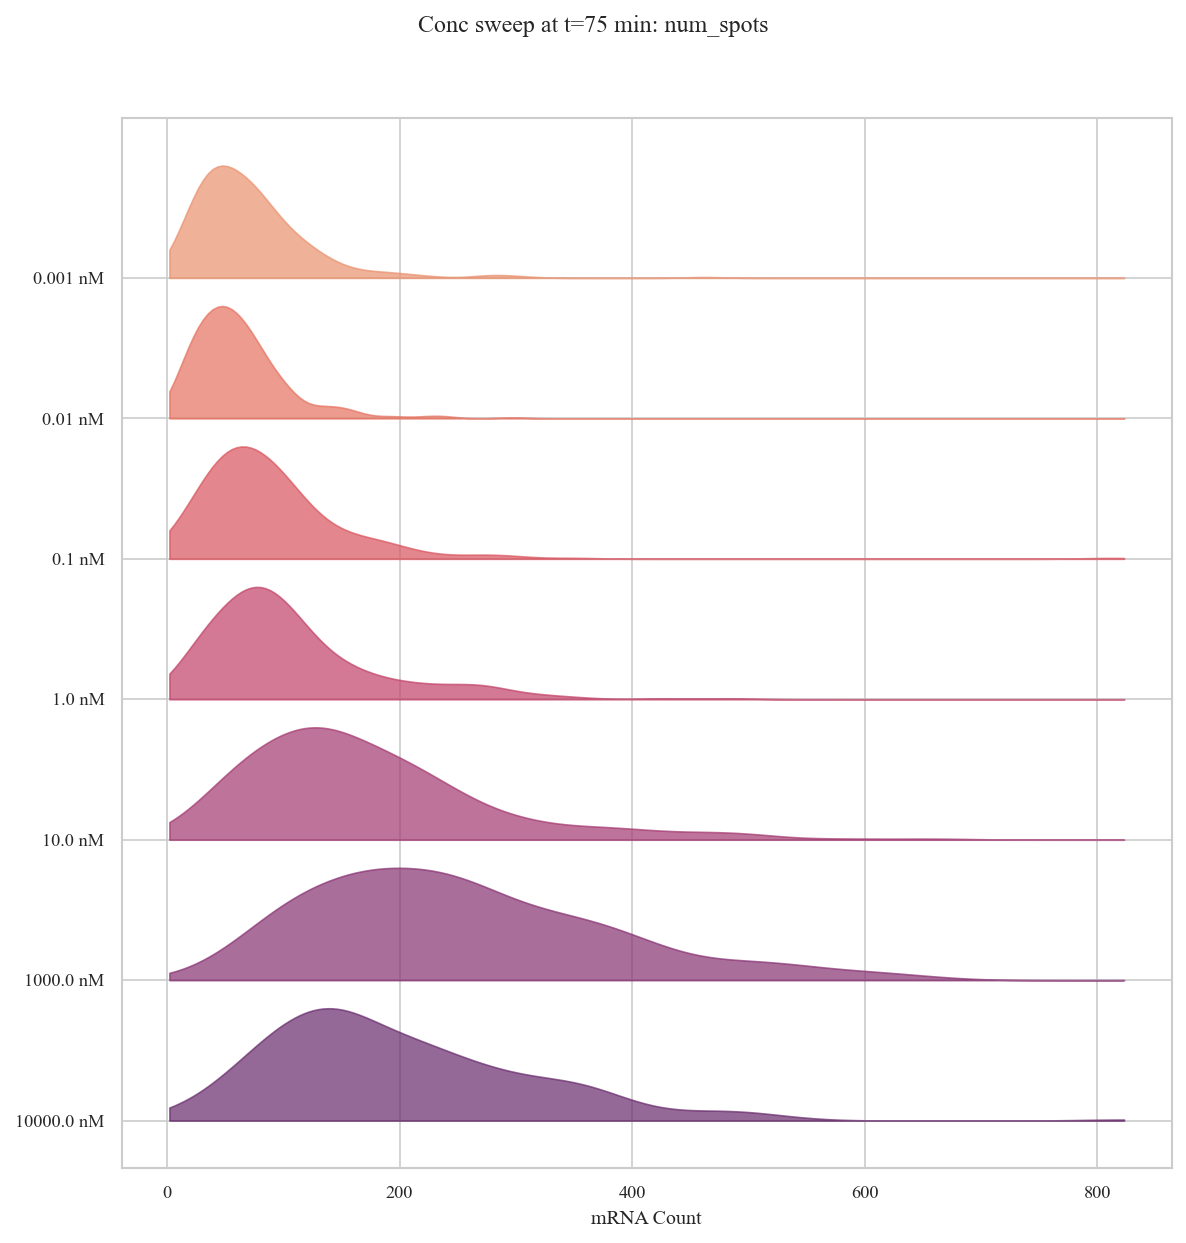

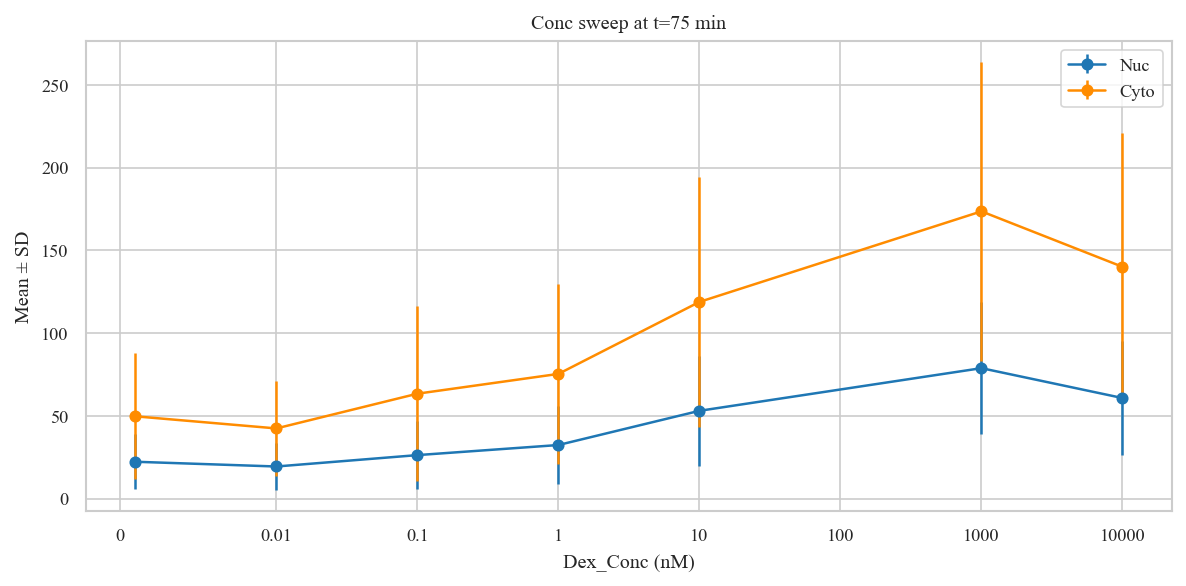

In [13]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_H_slide1_BFmean_061825',
    'DUSP1_H_slide2_BFmean_061825',
    'DUSP1_H_slide3_BFmean_061825',
    'DUSP1_H_slide4_BFmean_061825',
    'DUSP1_H_slide5_BFmean_061825',
    'DUSP1_H_slide6_BFmean_061825',
    'DUSP1_H_slide7_BFmean_061825',
    'DUSP1_H_slide8_BFmean_061825',    
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    # free all HDF5 handles

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 110
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_H_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

times = sorted(SSITcellresults['time'].unique())
nonzero = [t for t in times if t != 0]
if len(nonzero) != 1:
    raise ValueError(f"Expected exactly one non-zero time for H sweep, found {nonzero}")
timepoint = nonzero[0]

print(f"\n>>> Concentration sweep at t={timepoint} min for H replicate")
plotter.plot_conc_sweep(
    timepoint=timepoint,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica I 75min concentration sweep R3 - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_0nM_0min_Control_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_0nM_0min_Control_092022.h5 -> Analysis_DUSP1_I_slide1_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_1pM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_1pM_75min_092022.h5 -> Analysis_DUSP1_I_slide2_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_10pM_75min_092022.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_10pM_75min_092022.h5 -> Analysis_DUSP1_I_slide3_BFmean_061825_2025-06-18/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221003/DUSP1_Dex_Sweep_100pM_75min_092022.h5
Reading Dat

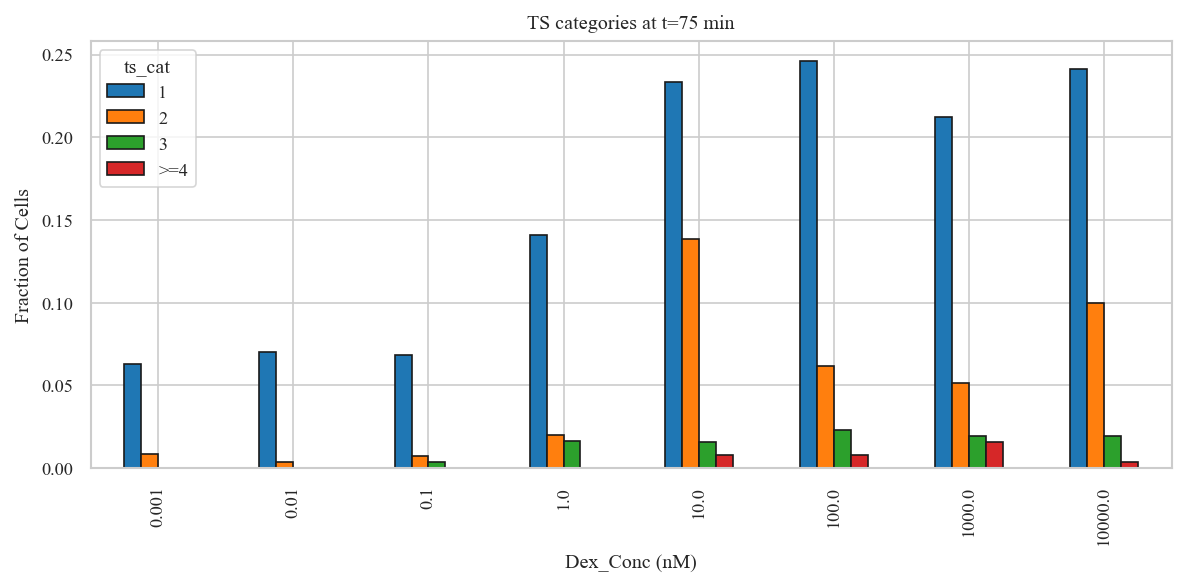

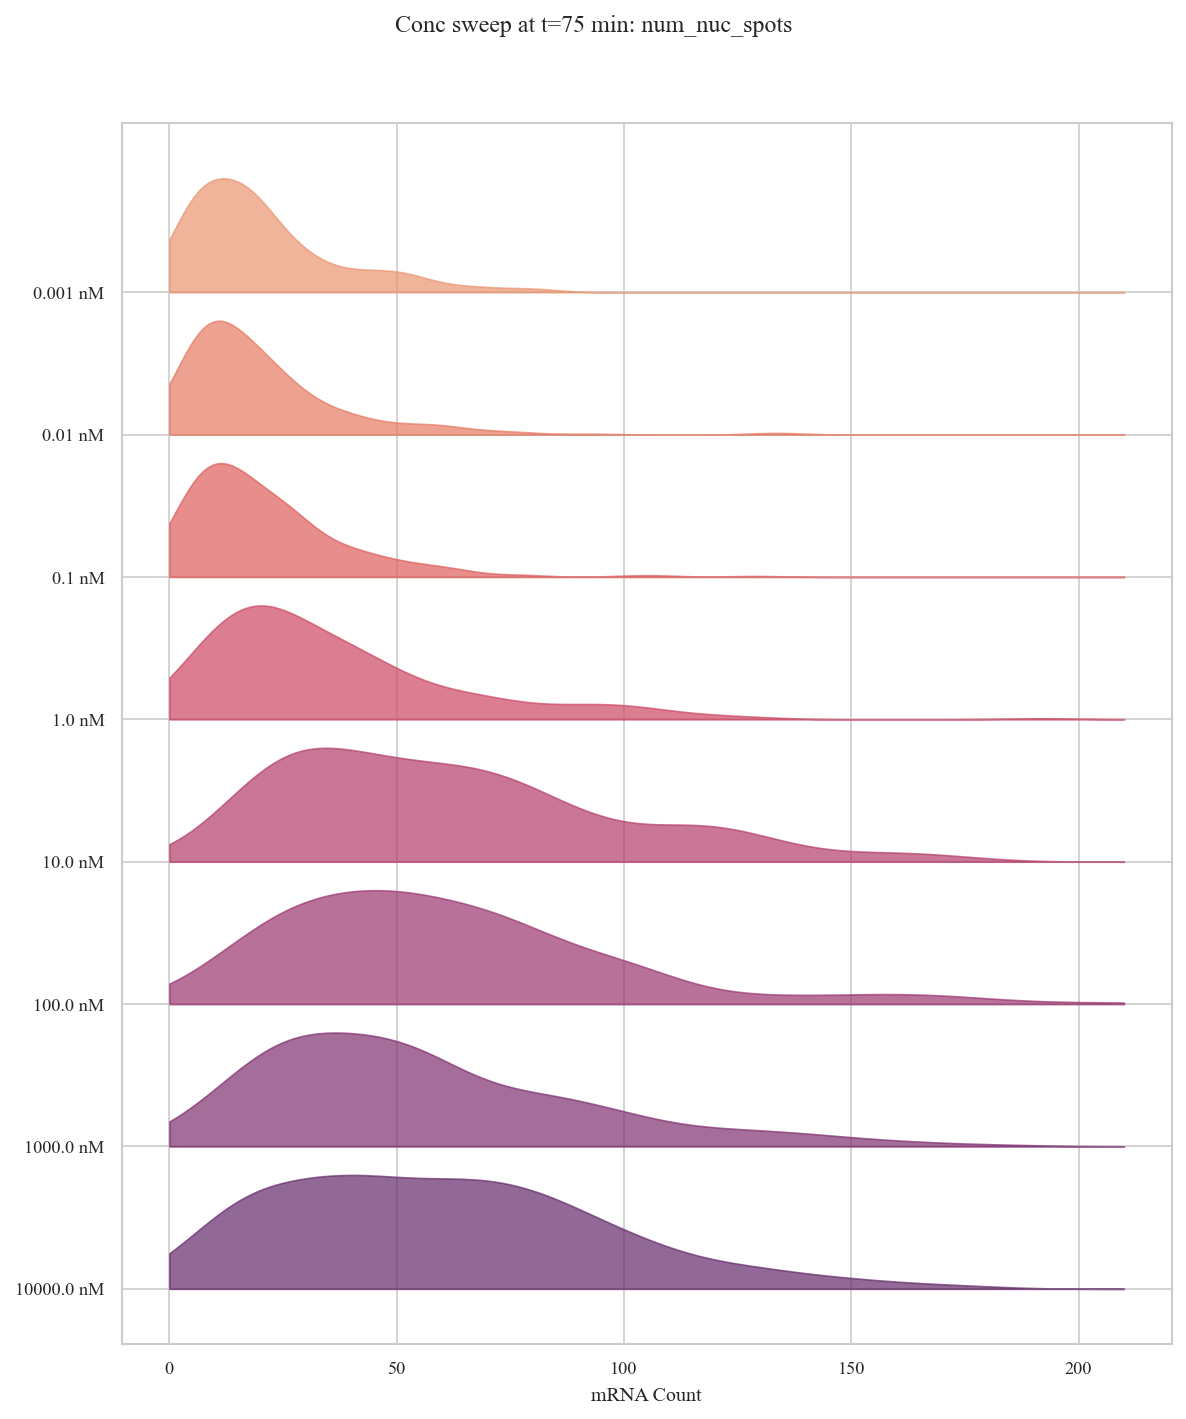

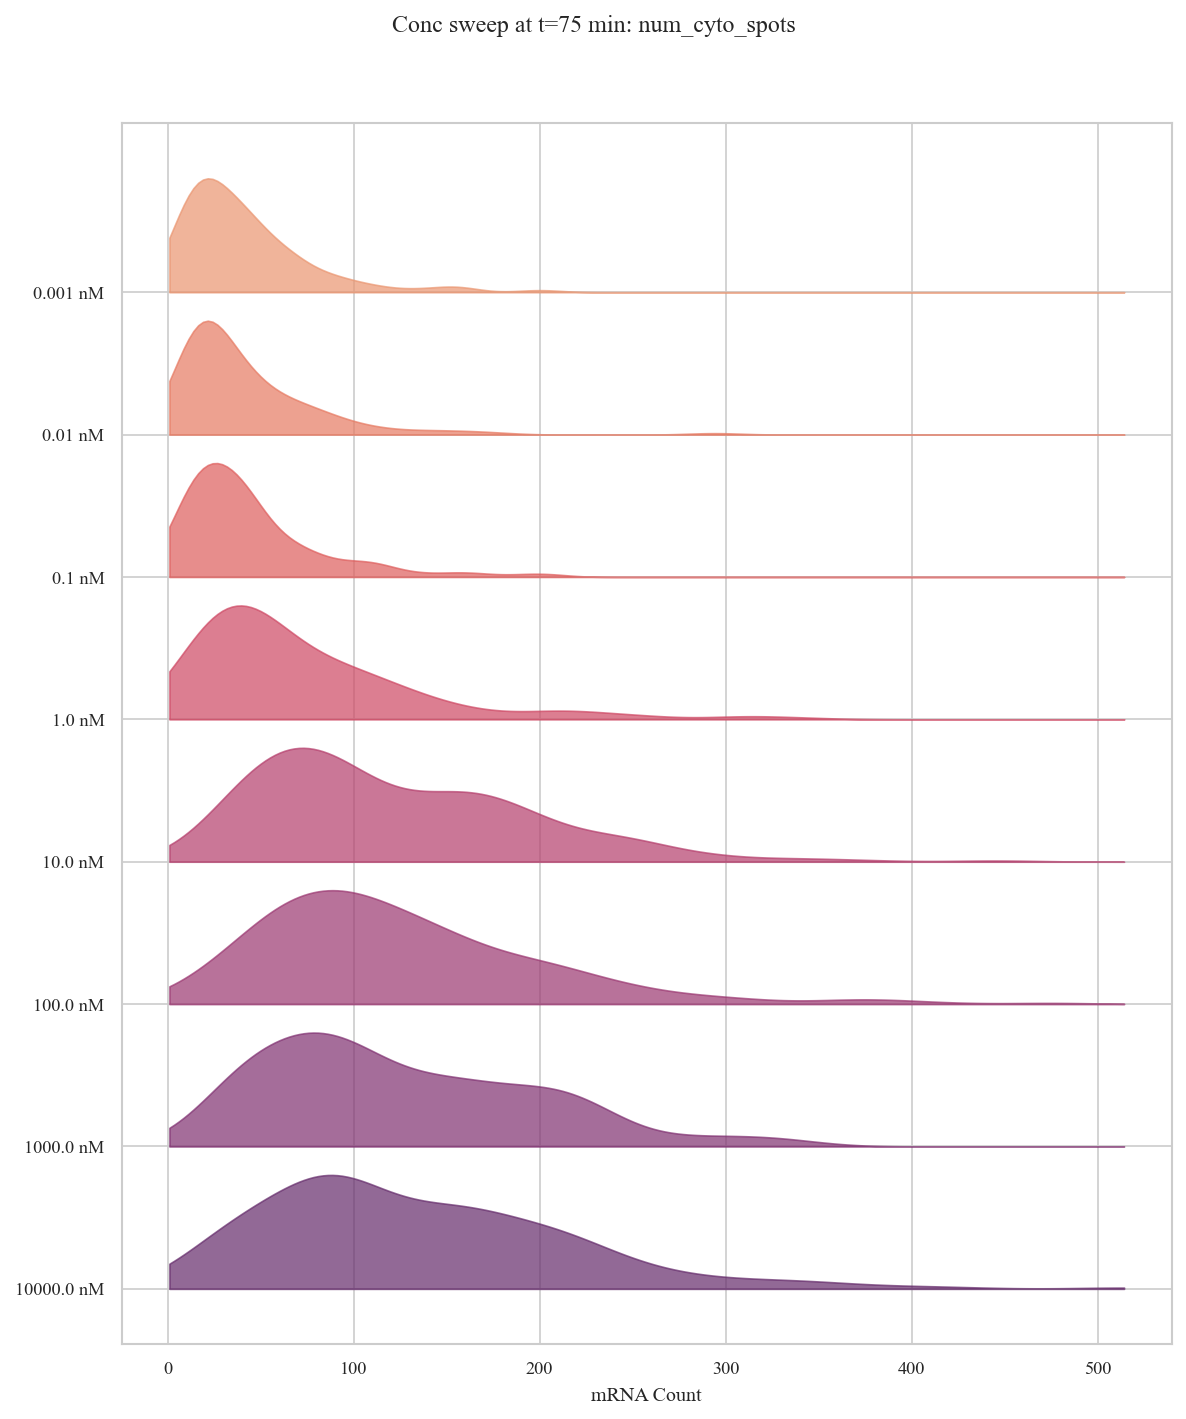

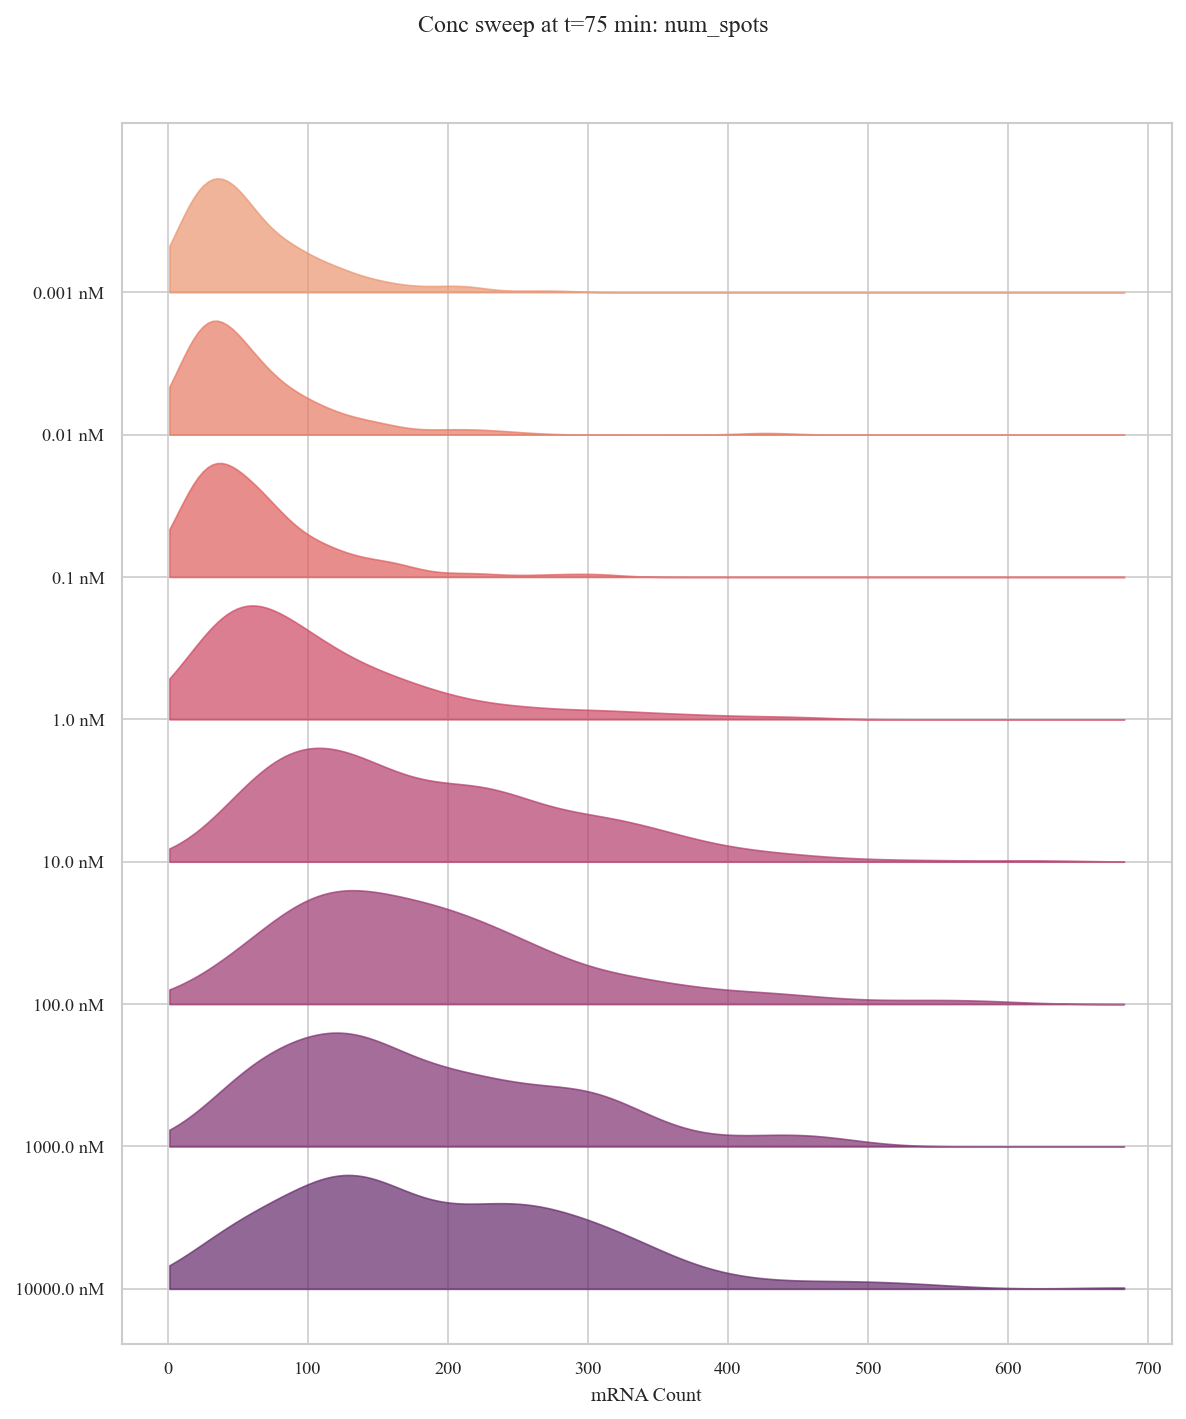

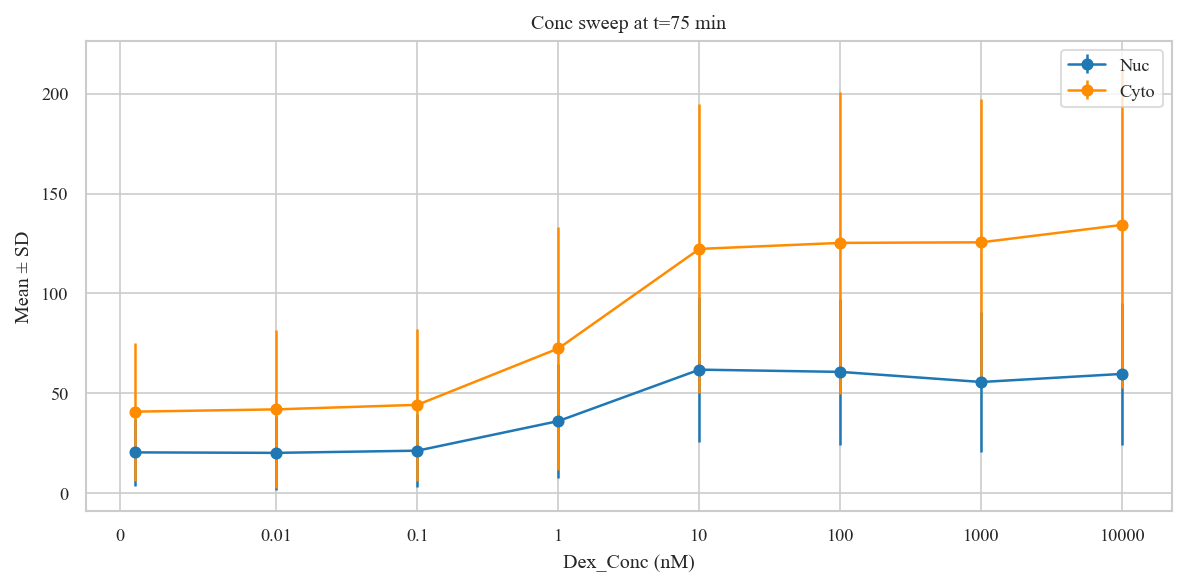

In [14]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_I_slide1_BFmean_061825',
    'DUSP1_I_slide2_BFmean_061825',
    'DUSP1_I_slide3_BFmean_061825',
    'DUSP1_I_slide4_BFmean_061825',
    'DUSP1_I_slide5_BFmean_061825',
    'DUSP1_I_slide6_BFmean_061825',
    'DUSP1_I_slide7_BFmean_061825',
    'DUSP1_I_slide8_BFmean_061825',
    'DUSP1_I_slide9_BFmean_061825',      
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 120
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_I_BFmean'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) post-processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl= False,
)

times = sorted(SSITcellresults['time'].unique())
nonzero = [t for t in times if t != 0]
if len(nonzero) != 1:
    raise ValueError(f"Expected exactly one non-zero time for I sweep, found {nonzero}")
timepoint = nonzero[0]

print(f"\n>>> Concentration sweep at t={timepoint} min for I replicate")
plotter.plot_conc_sweep(
    timepoint=timepoint,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica O Triptolide Time-sweep - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex_TPL_3hr_0min_Control_101422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex_TPL_3hr_0min_Control_101422.h5 -> Analysis_DUSP1_O_BFmean_slide1_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex100nM_75min_Control_101422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex100nM_75min_Control_101422.h5 -> Analysis_DUSP1_O_BFmean_slide2_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex100nM_75min_TPL5uM_10min_101422.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex100nM_75min_TPL5uM_10min_101422.h5 -> Analysis_DUSP1_O_BFmean_slide3_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221019/DUSP1_Dex100nM_75min_TPL5uM_30min

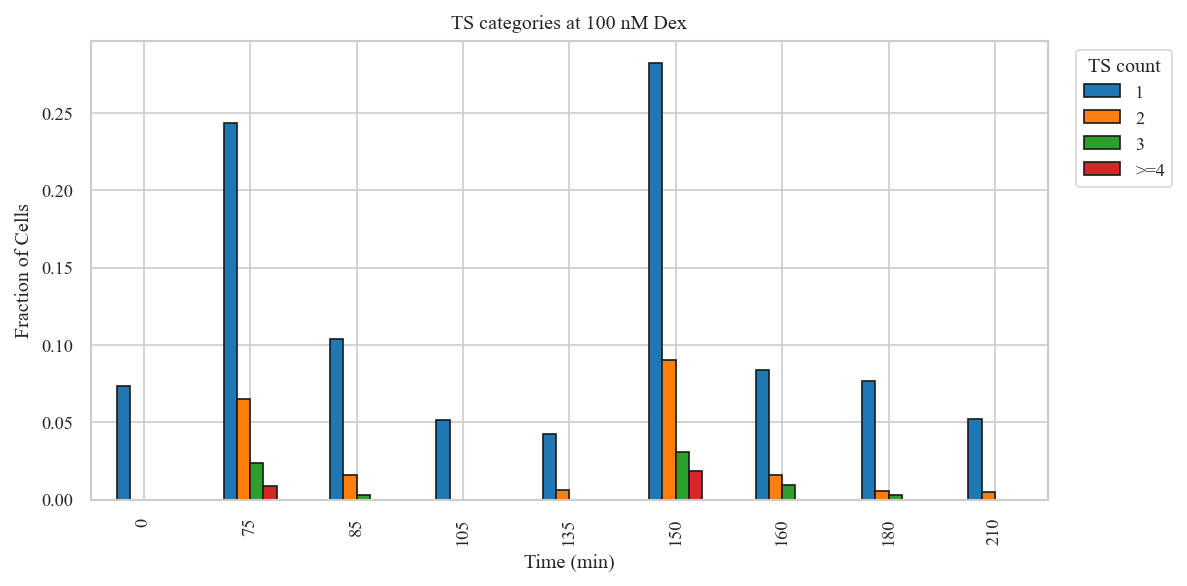

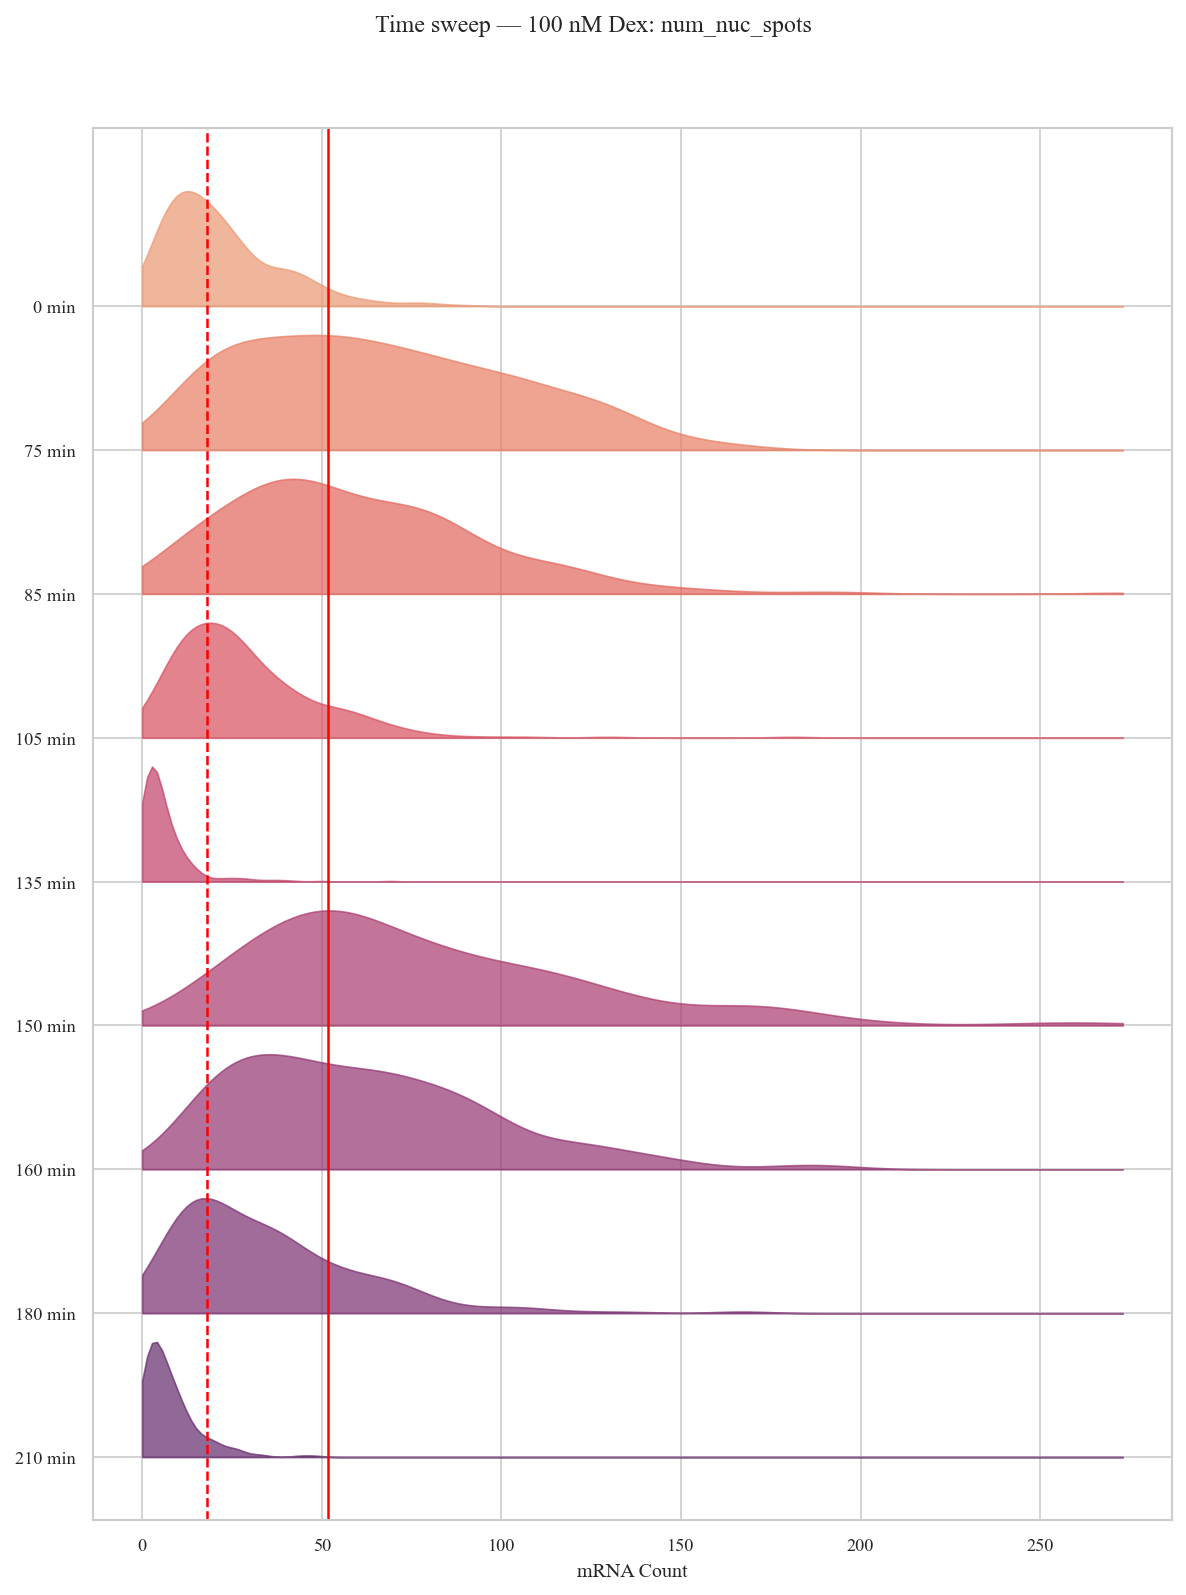

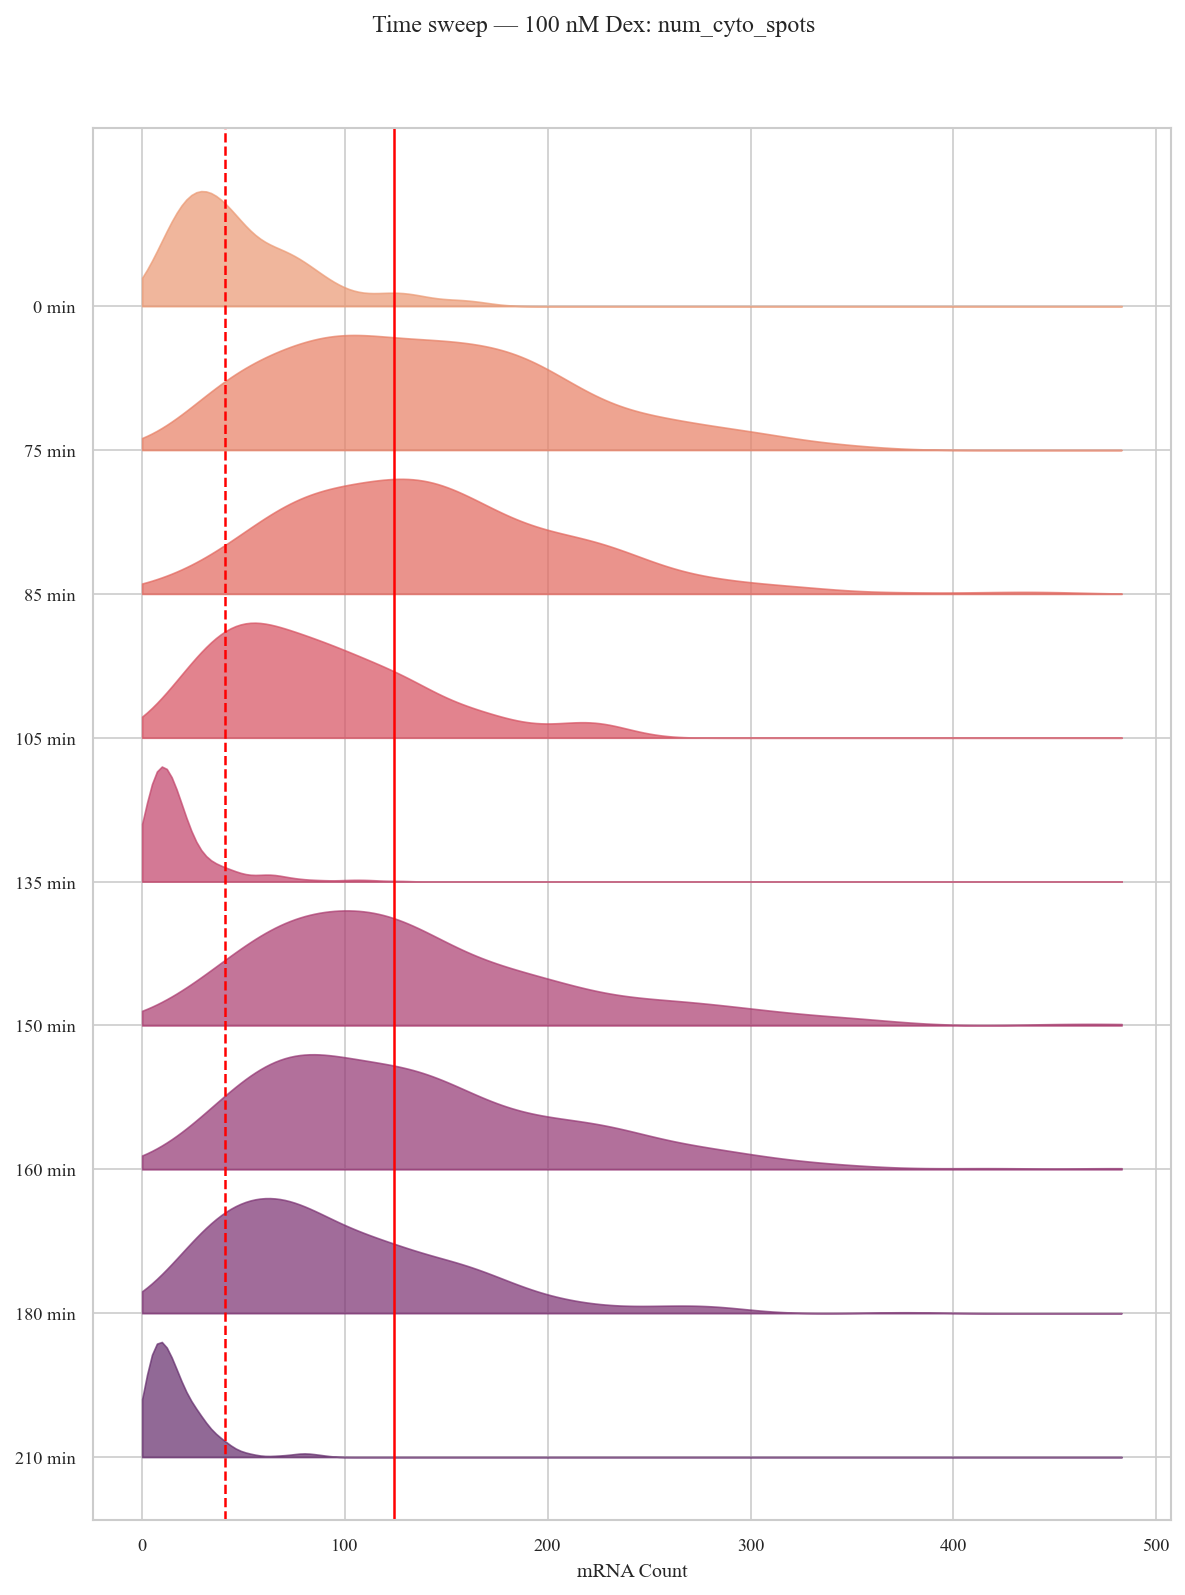

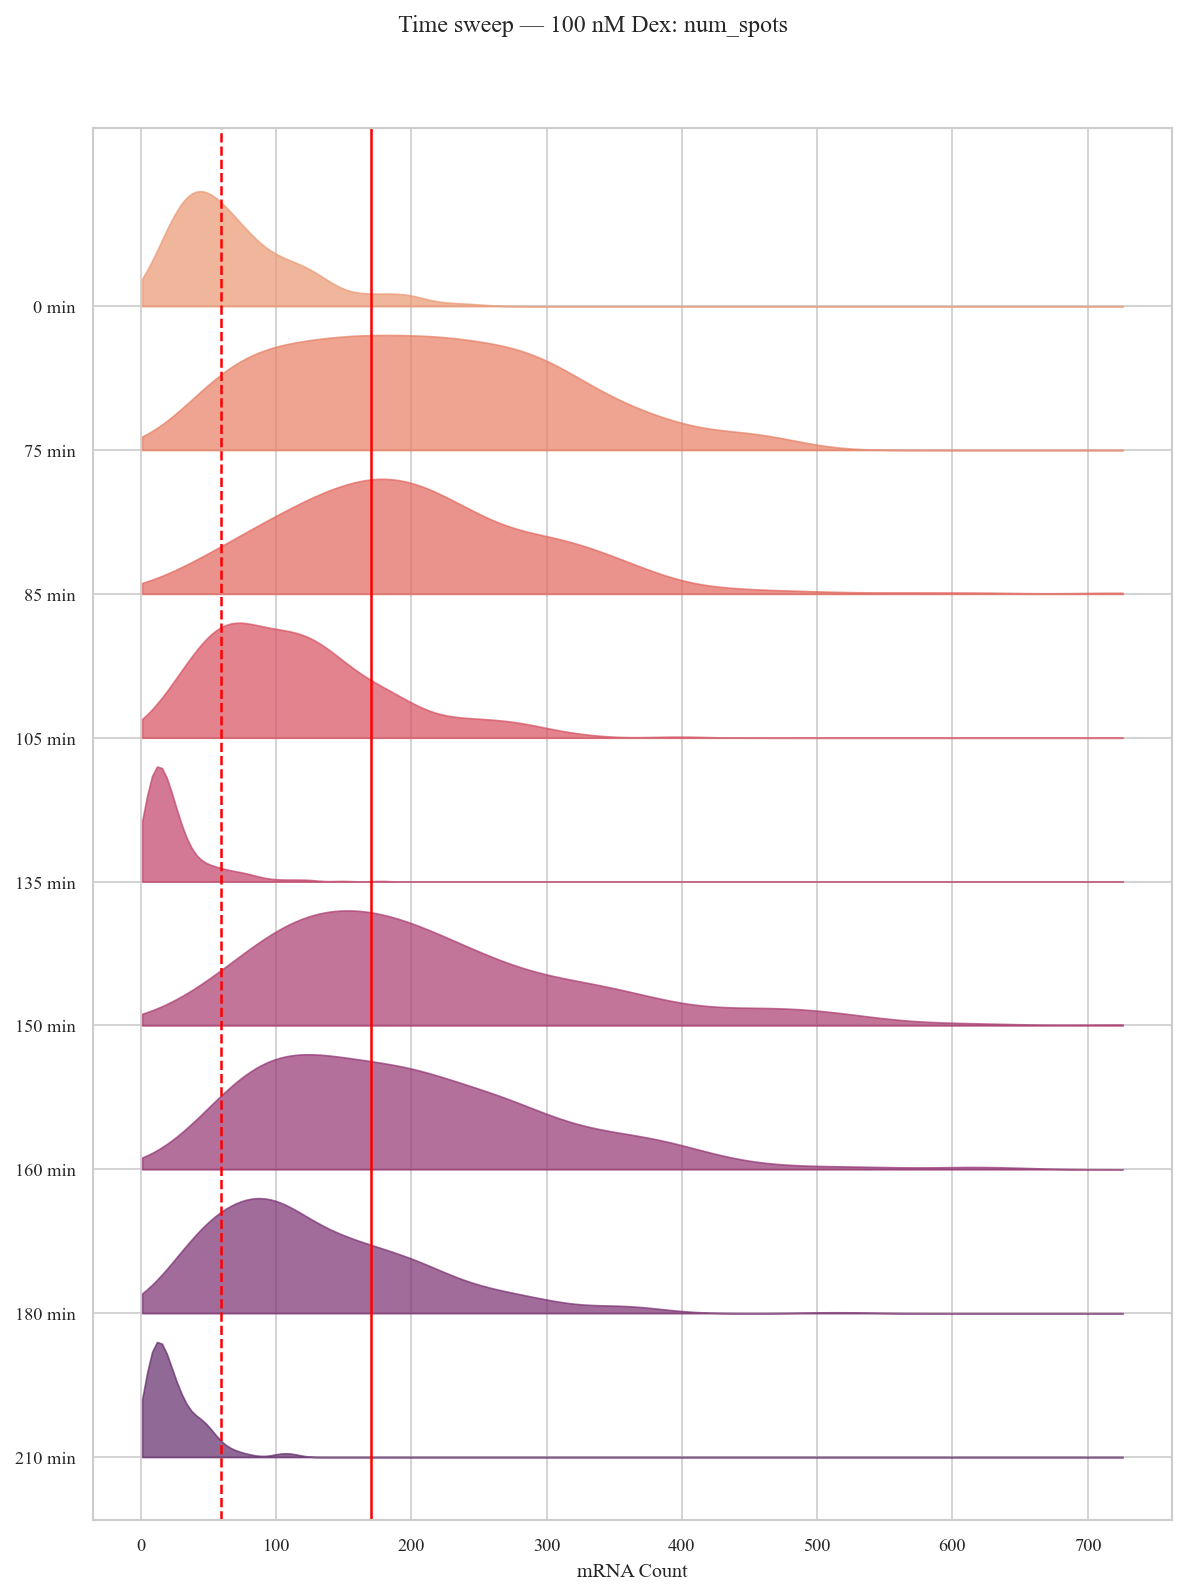

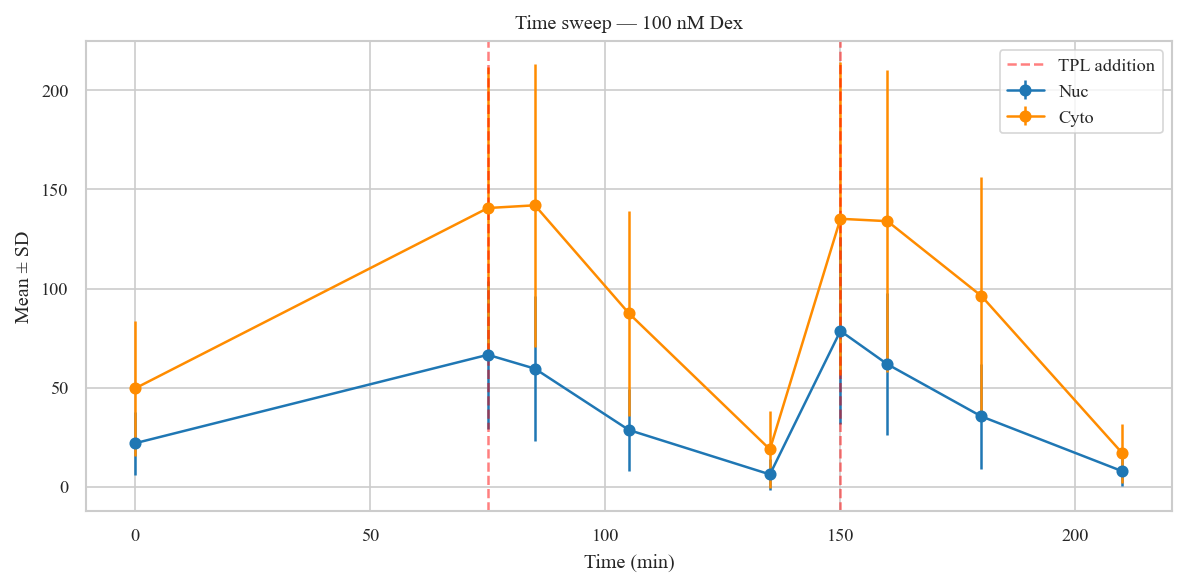

In [15]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_O_BFmean_slide1_062025',
    'DUSP1_O_BFmean_slide2_062025',
    'DUSP1_O_BFmean_slide3_062025',
    'DUSP1_O_BFmean_slide4_062025',
    'DUSP1_O_BFmean_slide5_062025',
    'DUSP1_O_BFmean_slide6_062025',
    'DUSP1_O_BFmean_slide7_062025',
    'DUSP1_O_BFmean_slide8_062025',
    'DUSP1_O_BFmean_slide9_062025',      
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"spots column keys: {spots_df.keys()}")
print(f"  clusters:{clusters_df.shape}")
print(f"clusters column keys: {clusters_df.keys()}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df,
                        is_tpl=True)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 130
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold,
                           is_tpl=True)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_O_BFmean_tpl'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
print("SSITcellresults keys:", SSITcellresults.keys())
print("Saved final results to:", output_dir)

# ─── 7) Post‐processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl=True
)

print(f"\n>>> 100nM Dex TPL for O replicate")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

**`DUSP1 Replica P Triptolide Time-sweep - By Slide`**

Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_0min_110222.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_0min_110222.h5 -> Analysis_DUSP1_P_BFmean_slide1_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_15min_110222.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_15min_110222.h5 -> Analysis_DUSP1_P_BFmean_slide2_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_30min_110222.h5
Reading DataFrame from: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_30min_110222.h5 -> Analysis_DUSP1_P_BFmean_slide3_062025_2025-06-20/spotresults
Opening file: /Volumes/share/smFISH_images/Eric_smFISH_images/20221103/DUSP1_Dex_0min_TPL_60min_110222.h5
Reading DataFrame from: /Volumes/share

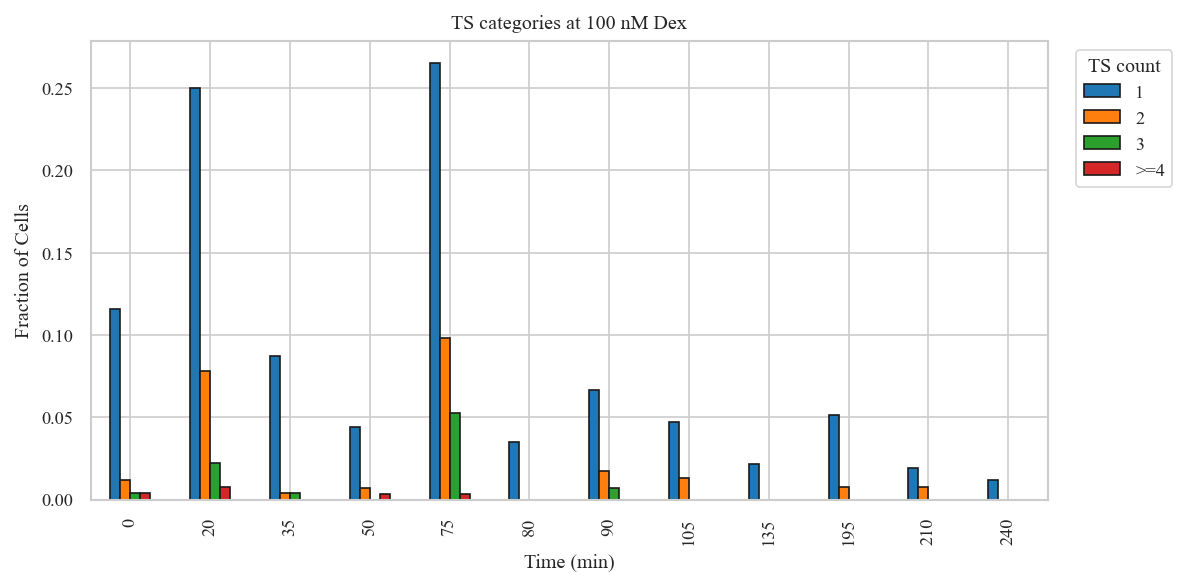

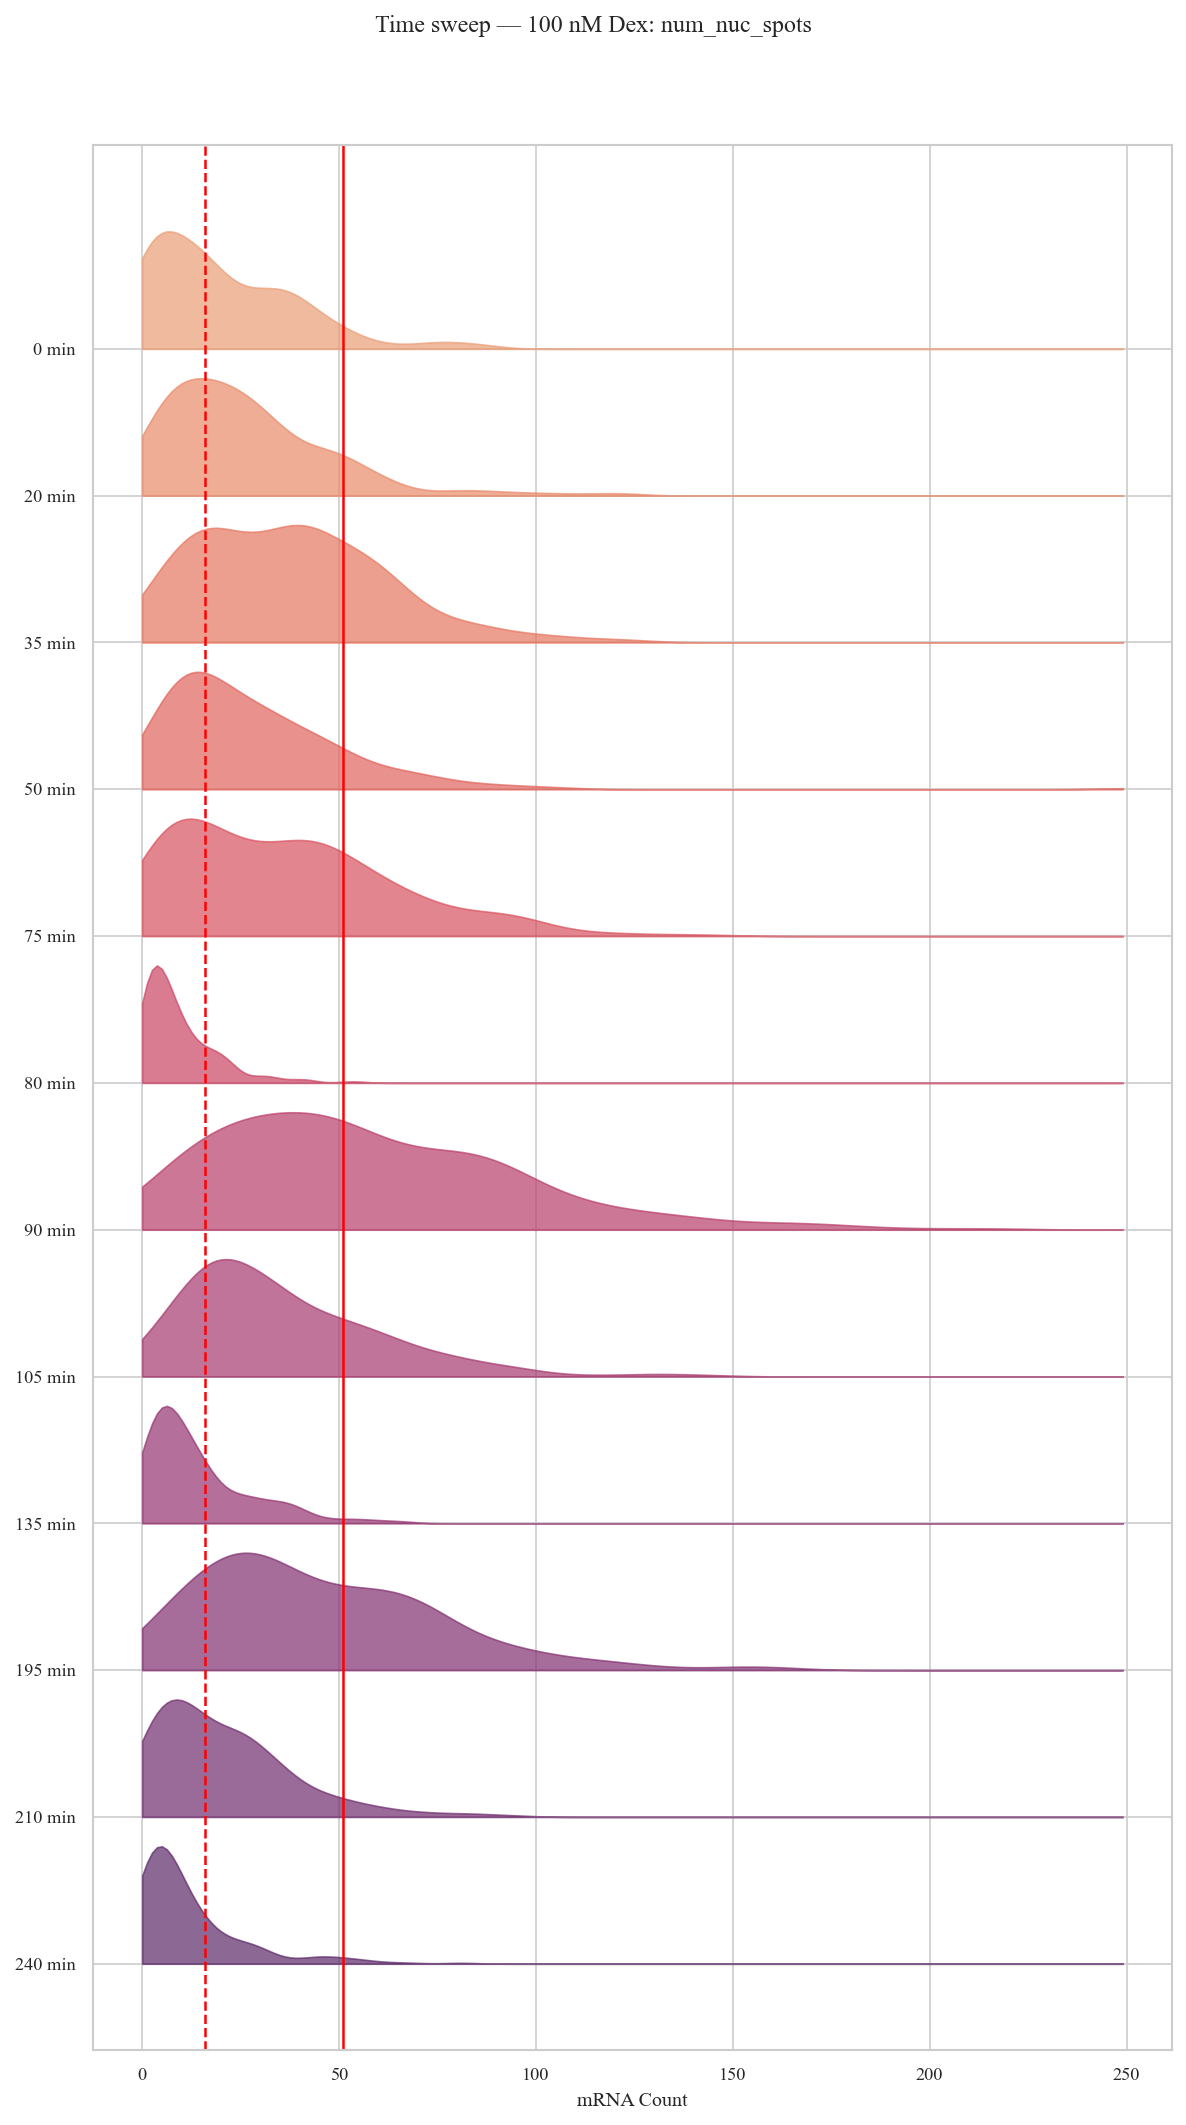

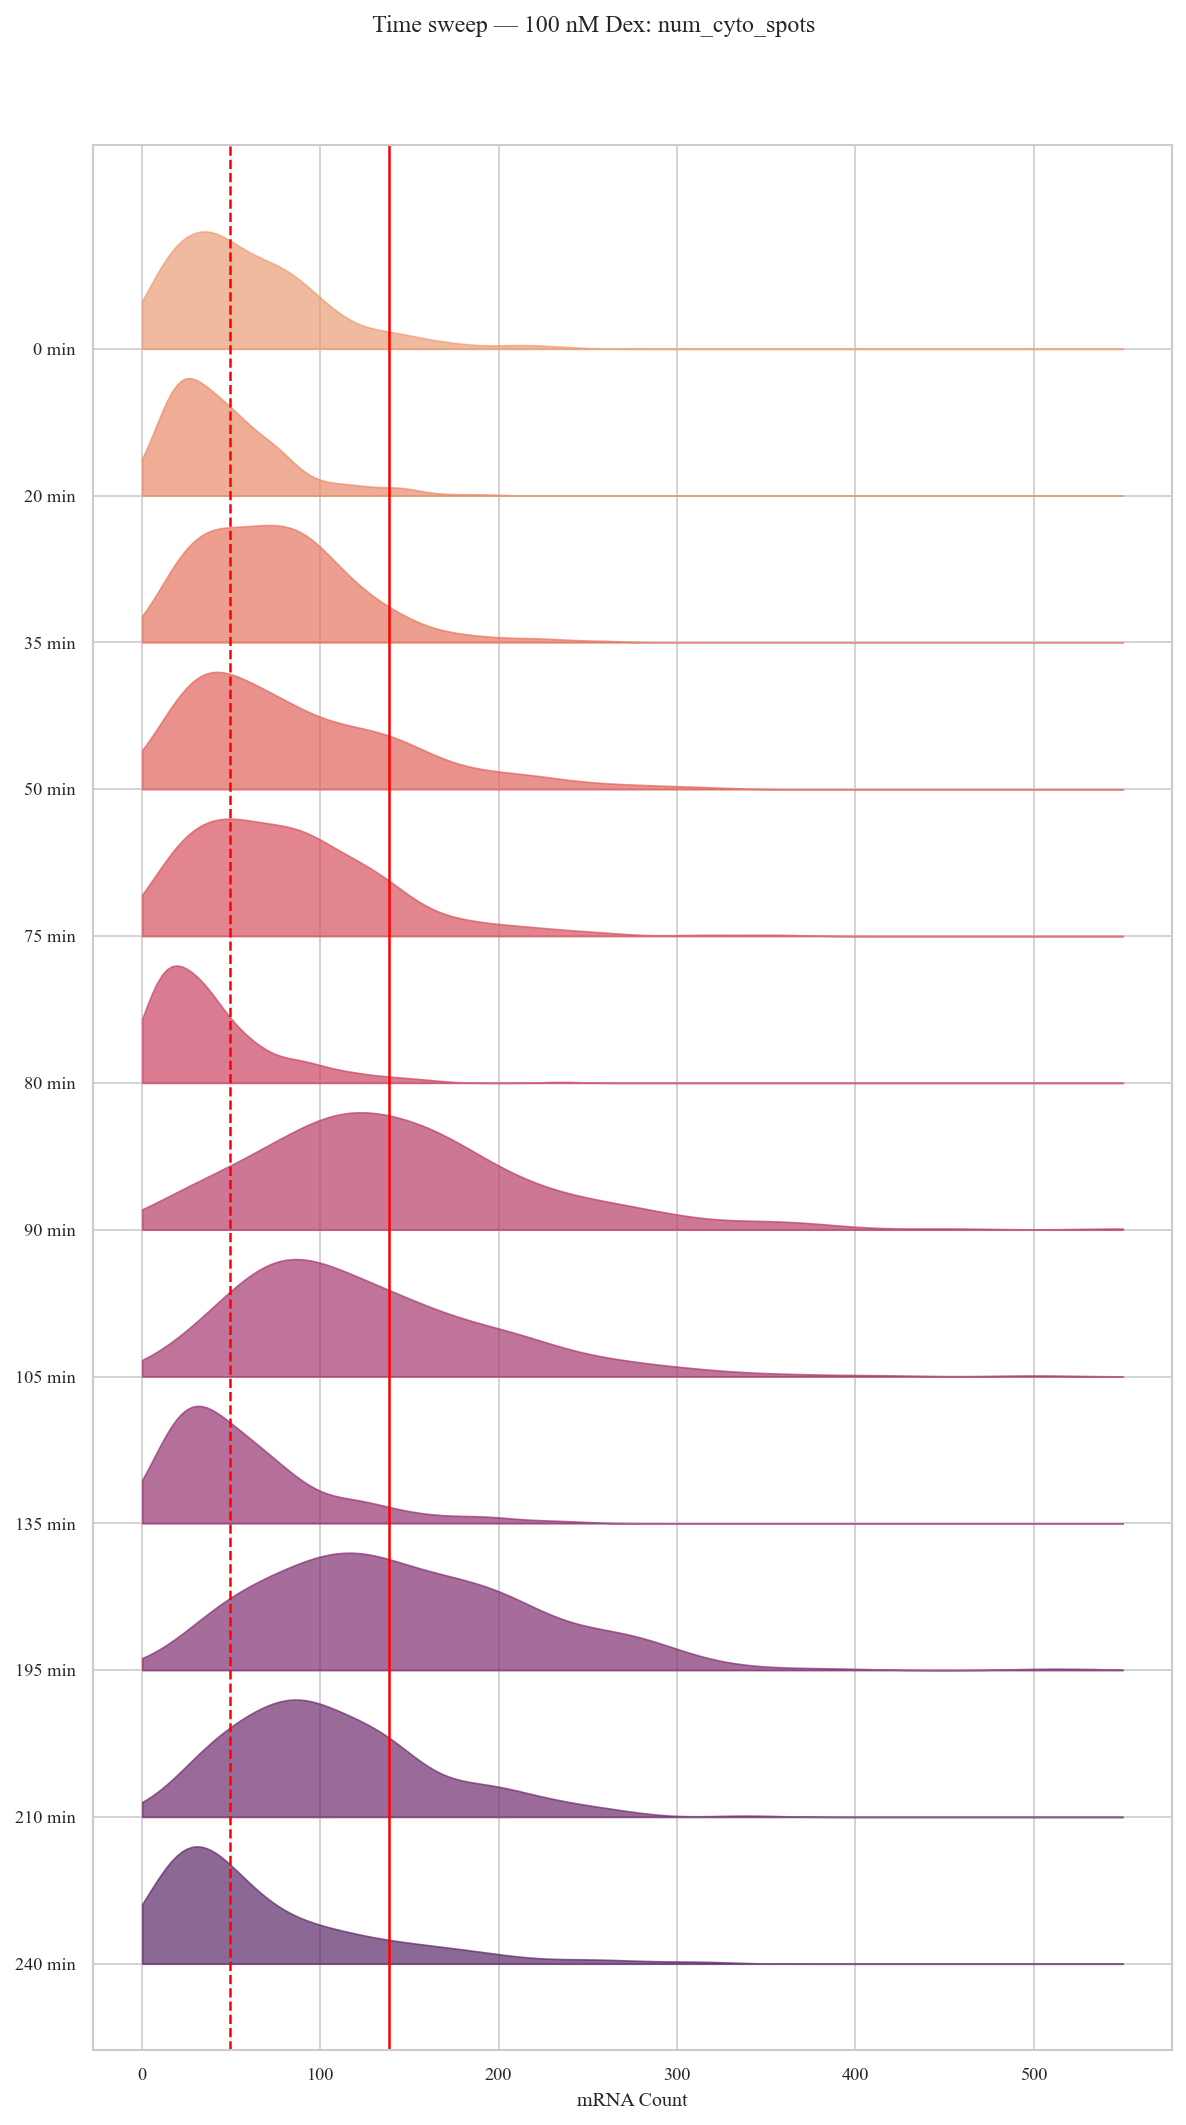

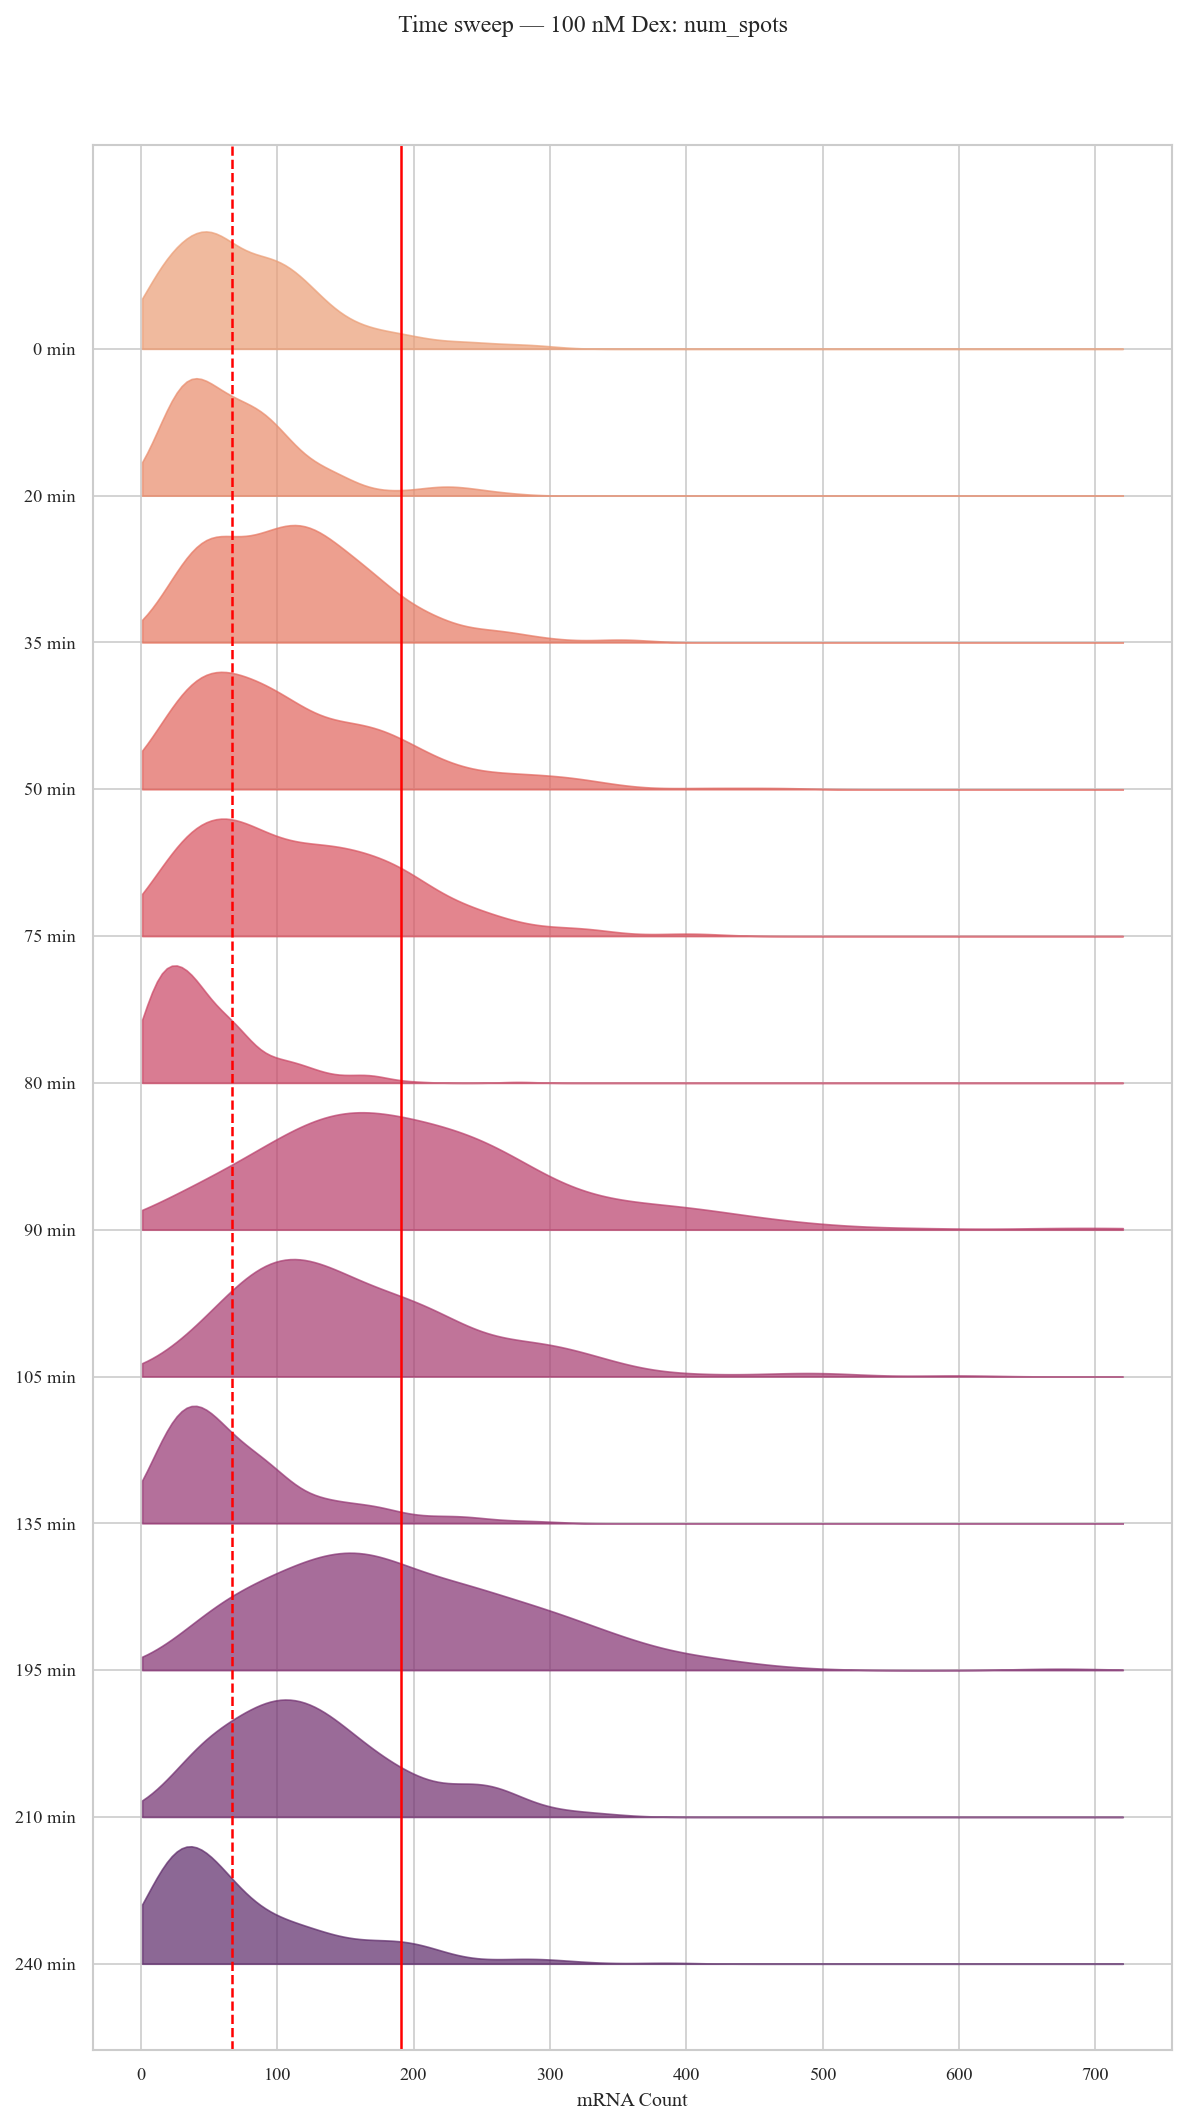

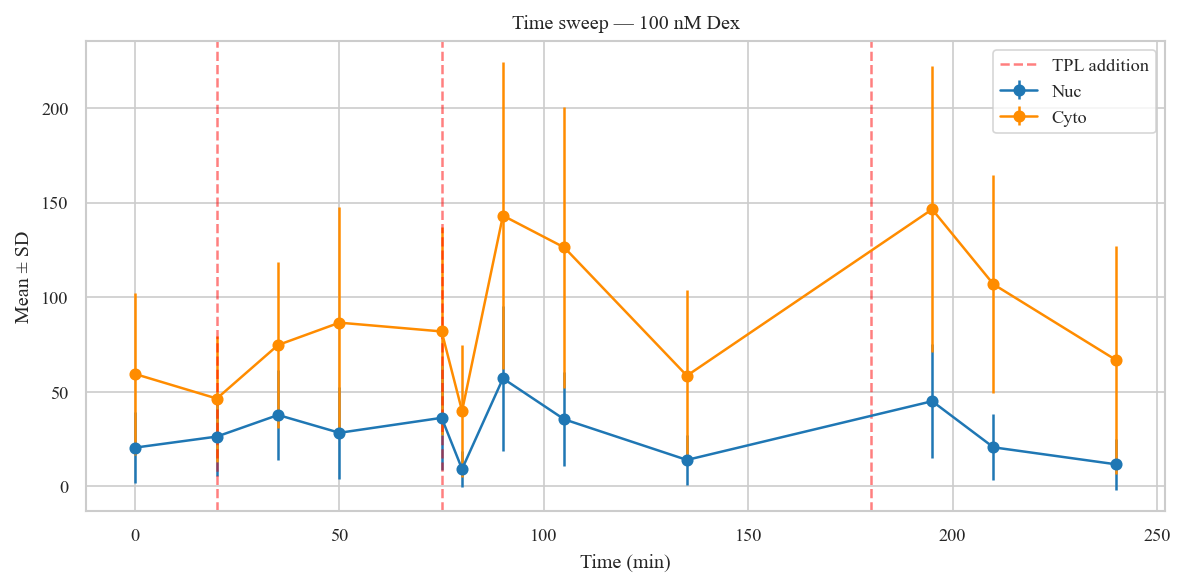

In [16]:
# ─── 1) pull in all slides  ──────────────────────────────────────────
analysis_names = [
    'DUSP1_P_BFmean_slide1_062025',
    'DUSP1_P_BFmean_slide2_062025',
    'DUSP1_P_BFmean_slide3_062025',
    'DUSP1_P_BFmean_slide4_062025',
    'DUSP1_P_BFmean_slide5_062025',
    'DUSP1_P_BFmean_slide6_062025',
    'DUSP1_P_BFmean_slide7_062025',
    'DUSP1_P_BFmean_slide8_062025',
    'DUSP1_P_BFmean_slide9_062025',
    'DUSP1_P_BFmean_slide10_062025',
    'DUSP1_P_BFmean_slide11_062025',
    'DUSP1_P_BFmean_slide12_062025',
    'DUSP1_P_BFmean_slide23_062025',
    'DUSP1_P_BFmean_slide14_062025',
    'DUSP1_P_BFmean_slide15_062025',
    'DUSP1_P_BFmean_slide16_062025',         
]

# build and use the combined manager
dm = make_combined_manager(loc, log_location, mac, analysis_names)

spots_df    = dm.select_datasets("spotresults",      dtype="dataframe")
clusters_df = dm.select_datasets("clusterresults",   dtype="dataframe")
props_df    = dm.select_datasets("cell_properties",  dtype="dataframe")
dm.close()    

print(f"Loaded and concatenated {len(analysis_names)} days:")
print(f"  spots:   {spots_df.shape}")
print(f"  clusters:{clusters_df.shape}")
print(f"  props:   {props_df.shape}")

# ─── 2) SNRAnalysis → DUSP1Measurement ────────────────────────────────────────
abs_threshold = 6
mg_threshold  = 3

snr = SNRAnalysis(spots_df, props_df, clusters_df,
                  abs_threshold=abs_threshold,
                  mg_threshold=mg_threshold)
merged_spots_df, merged_clusters_df, merged_cellprops_df = snr.get_results()

dusp = DUSP1Measurement(merged_spots_df,
                        merged_clusters_df,
                        merged_cellprops_df,
                        is_tpl=True)
cell_level_results = dusp.measure(abs_threshold=abs_threshold,
                                  mg_threshold=mg_threshold)

# ─── 3) Prefix unique IDs (prefix=70 for K replicate) ─────────────────────────
max_id     = merged_cellprops_df['unique_cell_id'].max()
num_digits = len(str(max_id))
rep_prefix = 140
prefix     = rep_prefix * (10 ** num_digits)

for df in (merged_spots_df, merged_clusters_df, merged_cellprops_df, cell_level_results):
    df['unique_cell_id'] += prefix

max_spot_id  = merged_spots_df['unique_spot_id'].max()
spot_prefix  = rep_prefix ** len(str(max_spot_id))
merged_spots_df   ['unique_spot_id'] += spot_prefix

max_cluster_id = merged_clusters_df['unique_cluster_id'].max()
cluster_prefix = rep_prefix ** len(str(max_cluster_id))
merged_clusters_df['unique_cluster_id'] += cluster_prefix

# ─── 4) Filtering ───────────────────────────────────────────────────────────────
filterer = DUSP1_filtering(method=method,
                           abs_threshold=abs_threshold,
                           mg_threshold=mg_threshold,
                           is_tpl=True)
filtered_spots, filtered_clusters, filtered_cellprops, SSITcellresults, removed_spots = \
    filterer.apply_all(spots=merged_spots_df,
                       clusters=merged_clusters_df,
                       cellprops=merged_cellprops_df)

# ─── 5) main display ──────────────────────────────────────────────────────────
# build a fresh manager so the display code can find every HDF5
dm_disp = make_combined_manager(loc, log_location, mac, analysis_names)
display_manager = DUSP1DisplayManager(
    dm_disp,
    cell_level_results=SSITcellresults,
    spots=filtered_spots,
    clusters=filtered_clusters,
    cellprops=filtered_cellprops,
    removed_spots=removed_spots
)
display_manager.default_display(
    per_h5=1,
    show=False,                 # Preview in notebook
    save=True,                 # Save PNGs
    outdir=img_dir,
    dpi_notebook=120,          # lighter for notebook
    dpi_save=600,              # publication quality
    show_removed=True,         # overlay removed spots in crops
    removed_color="red"  # distinct color for removed
)
dm_disp.close()

# ─── 6) Save final, post‐filter results to CSV ─────────────────────────────────
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
rep_string = 'DUSP1_P_BFmean_tpl'
base = f"{rep_string}_MG{mg_threshold}_Abs{abs_threshold}_{date_str}_{method}"

SSITcellresults  .to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
filtered_spots   .to_csv(os.path.join(output_dir, f"{base}_FinalSpots.csv"),      index=False)
filtered_clusters.to_csv(os.path.join(output_dir, f"{base}_FinalClusters.csv"),  index=False)
filtered_cellprops.to_csv(os.path.join(output_dir, f"{base}_FinalCellProps.csv"), index=False)
removed_spots    .to_csv(os.path.join(output_dir, f"{base}_RemovedSpots.csv"),   index=False)

print("Saved final results to:", output_dir)

# ─── 7) Post‐processing plots with PostProcessingPlotter ──────────────────────
plotter = PostProcessingPlotter(
    clusters_df=filtered_clusters,
    cellprops_df=filtered_cellprops,
    ssit_df=SSITcellresults,
    is_tpl=True
)

print(f"\n>>> 100nM Dex TPL for P replicate")
plotter.plot_time_sweep(
    dex_conc=100,
    save_dir=img_dir,
    display=True
)

## GR Confirmation

In [ ]:
import os
import numpy as np
import pandas as pd
from src.Analysis_GR import AnalysisManager, GR_Confirmation

loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'
mac = True


def touching_border(df, image_height, image_width):
    """
    Returns a boolean Series indicating which cells are touching any image border (no margin).

    Expects df to have columns:
      'cell_bbox-0' => min_row
      'cell_bbox-1' => min_col
      'cell_bbox-2' => max_row (exclusive)
      'cell_bbox-3' => max_col (exclusive).
    """
    min_row = df['cell_bbox-0']
    min_col = df['cell_bbox-1']
    max_row = df['cell_bbox-2']
    max_col = df['cell_bbox-3']

    return (
        (min_row == 0)
        | (min_col == 0)
        | (max_row == image_height)
        | (max_col == image_width)
    )


def filter_GR(name, rep_prefix: int):
    # 1) set up
    am = AnalysisManager(location=loc, log_location=log_location, mac=True)
    am.select_analysis(name)
    GR = GR_Confirmation(am)
    GR.get_data()

    # 2) get image dims for border-touching
    image0 = GR.corrected_images[0]
    h, w = image0.shape[-2:]

    # 3) make a simple local index for each cell
    local_ids = np.arange(len(GR.cellprops))

    # 4) compute how many digits that index has
    max_local = local_ids.max()
    num_digits = len(str(max_local))

    # 5) build the rep-specific offset
    offset = rep_prefix * (10 ** num_digits)

    # 6) assign your global unique_cell_id
    GR.cellprops['unique_cell_id'] = local_ids + offset

    # 7) remove border-touching cells as before
    GR.cellprops['touching_border'] = touching_border(
        GR.cellprops, image_height=h, image_width=w
    )
    GR.cellprops = GR.cellprops[~GR.cellprops['touching_border']].copy()  # <-- keep a copy

    am.close()

    # 8) return your SSIT-style frame
    return measure_GR(GR.cellprops)


def measure_GR(cellprops) -> pd.DataFrame:
    results = pd.DataFrame(
        columns=[
            'unique_cell_id', 'nuc_area', 'nucGRint', 'cytoGRint', 'time',
            'dex_conc', 'replica', 'fov', 'nas_location', 'h5_idx',
            'background_p1', 'background_p3', 'background_p5', 'background_p10',
            'background_otsu_thresh', 'background_mean_otsu',
            'background_median_otsu', 'background_std_otsu'
        ]
    )

    # Sort cellprops by unique_cell_id
    props = cellprops.sort_values(by='unique_cell_id').copy()

    # unique cell id
    cell_ids = props['unique_cell_id']
    # nuc area
    nuc_area = props['nuc_area']
    # avg int nuc
    nucGRint = props['nuc_intensity_mean-0']
    # avg int pseudocyto mask
    cytoGRint = props['cyto_intensity_mean-0']
    # time (experiment)
    time = props['time']
    # Dex conc
    dex_conc = props['Dex_Conc']
    # Replica
    replica = props['replica']
    # identifiers
    fov = props['fov']
    nas_location = props['NAS_location']
    h5_idx = props['h5_idx']

    results['unique_cell_id'] = cell_ids.values
    results['nuc_area'] = nuc_area.values
    results['nucGRint'] = nucGRint.values
    results['cytoGRint'] = cytoGRint.values
    results['time'] = time.values
    results['dex_conc'] = dex_conc.values
    results['replica'] = replica.values
    results['fov'] = fov.values
    results['nas_location'] = nas_location.values
    results['h5_idx'] = h5_idx.values

    # background
    results['background_p1'] = props['background_p1'].values
    results['background_p3'] = props['background_p3'].values
    results['background_p5'] = props['background_p5'].values
    results['background_p10'] = props['background_p10'].values
    results['background_otsu_thresh'] = props['background_otsu_thresh'].values
    results['background_mean_otsu'] = props['background_mean_otsu'].values
    results['background_median_otsu'] = props['background_median_otsu'].values
    results['background_std_otsu'] = props['background_std_otsu'].values

    # Final QC: keep only rows that have BOTH nucGRint and cytoGRint
    results = results.dropna(subset=['nucGRint', 'cytoGRint']).copy()

    # keep unique_cell_id as both column and index
    results['unique_cell_id'] = results['unique_cell_id'].astype('int64')
    results.set_index('unique_cell_id', inplace=True, drop=False)  # <-- preserve column

    return results

In [ ]:
GR_RepA = filter_GR('GR_wIC_sig50_A_082125', rep_prefix=150)

In [ ]:
GR_RepB = filter_GR('GR_wIC_sig50_B_082125', rep_prefix=160)

In [ ]:
GR_RepC = filter_GR('GR_wIC_sig50_C_082125', rep_prefix=170)

In [ ]:
# Concatenate without reindexing and without rebuilding unique_cell_id
GR_ALL = pd.concat([GR_RepA, GR_RepB, GR_RepC], ignore_index=False, sort=False)
GR_ALL.set_index('unique_cell_id', drop=False, inplace=True)

# Save
output_dir = save_dir
os.makedirs(output_dir, exist_ok=True)
base = f"GR_mergedReps_noBorderCells_preGate_preNorm_{date_str}"
GR_ALL.to_csv(os.path.join(output_dir, f"{base}_SSITcellresults.csv"), index=False)
print("Saved final GR results to:", output_dir)

## Visualization and Correlation Inspection

In [ ]:
# Load GR Results
GR_ALL = pd.read_csv(r'/Volumes/share/Users/Eric/GR_DUSP1_AllData/FinalAnalysis_GR_DUSP1/GR_mergedReps_noBorderCells_preGate_preNorm_Aug25_SSITcellresults.csv')

In [ ]:
GR_ALL.keys()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Filter out timepoints with only one replica
rep_counts = (
    GR_ALL
    .groupby(['dex_conc', 'time'])['replica']
    .nunique()
    .reset_index(name='n_replicas')
)
valid = rep_counts[rep_counts['n_replicas'] > 1][['dex_conc', 'time']]
GR_valid = pd.merge(GR_ALL, valid, on=['dex_conc', 'time'], how='inner')

# 2) Define your background metrics
background_metrics = [
    'background_p1',
    'background_p3',
    'background_p5',
    'background_p10',
    'background_otsu_thresh',
    'background_mean_otsu',
    'background_median_otsu',
    'background_std_otsu'
]

sns.set_theme(style="whitegrid")

for bg in background_metrics:
    # determine global x‐limits for this background metric
    x_min, x_max = GR_valid[bg].min(), GR_valid[bg].max()
    # determine global y‐limits for nucGRint and cytoGRint
    y_min_n, y_max_n = GR_valid['nucGRint'].min(), GR_valid['nucGRint'].max()
    y_min_c, y_max_c = GR_valid['cytoGRint'].min(), GR_valid['cytoGRint'].max()

    # plot nucGRint
    g = sns.FacetGrid(
        GR_valid,
        row='dex_conc', col='time',
        hue='replica',
        margin_titles=True,
        sharex=True, sharey=True,  # share scales across all panels
        height=3, aspect=1.2
    )
    g.map_dataframe(sns.scatterplot, x=bg, y='nucGRint', alpha=0.6)
    g.set_axis_labels(bg, 'nucGRint')
    g.set(xlim=(x_min, x_max), ylim=(y_min_n, y_max_n))
    g.add_legend(title="Replica")
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle(f"nucGRint vs {bg} (Faceted by Dex × Time)", y=1.02)
    plt.show()

    # plot cytoGRint
    f = sns.FacetGrid(
        GR_valid,
        row='dex_conc', col='time',
        hue='replica',
        margin_titles=True,
        sharex=True, sharey=True,
        height=3, aspect=1.2
    )
    f.map_dataframe(sns.scatterplot, x=bg, y='cytoGRint', alpha=0.6)
    f.set_axis_labels(bg, 'cytoGRint')
    f.set(xlim=(x_min, x_max), ylim=(y_min_c, y_max_c))
    f.add_legend(title="Replica")
    plt.subplots_adjust(top=0.9)
    f.figure.suptitle(f"cytoGRint vs {bg} (Faceted by Dex × Time)", y=1.02)
    plt.show()

## Background Normalization


Three intensity categories
Ibg = Background intensity (backgound metric columns)
Icyt = Pseudo-Cyto intensity (raw value in dataframe 'cytoGRint')
Inuc = Nuclear intensity (raw value in dataframe 'nucGRint')

CDF plots of intensities could identify bg, cyto, and nuclear intensity ranges. (Ibg is lowst intensity values, Ibg < Icyt ≤ Inuc ) 

Otsu threshold at 0min should identify actual Ibg value/treshold (However, cells with low nuc GR could be an issuse)... all other time/conc could have a mix of cyto and background.

Collected per fov background metrics:
    'background_p1', - 1st percentile intensity
    'background_p3', - 3rd percentile
    'background_p5', - 5th percentile
    'background_p10', - 10th percentile
    'background_otsu_thresh',
    'background_mean_otsu',
    'background_median_otsu',
    'background_std_otsu'


Mulplicitive (Microscope Related - Laser power, camera temp, etc)
 IcytNorm = Icty / Ibg
 InucNorm = Inuc / Igb
 IbgNorm = 1